# Simulated Slidequakes

This notebook accompanies the article *Simulated slidequakes: Insights from DEM simulations into the high-frequency seismic signal generated by geophysical granular flows* ([Arran et al., 2024](https://doi.org/10.1029/2023JF007455)), including not only all the code necessary to reproduce that article's figures and results, but also explanations and tentative interpretations. Results here go beyond those of the article, which was subject to length restrictions, and the code can be used as the starting point for further analyses. However, the article includes further and more rigorous explanation, interpretation and discussion of the results derived here, and should be considered the version of record.

For both the article and this notebook, we aimed to simulate the dense, steady flow of slightly polydisperse spherical particles on an inclined plane, to examine the link between the flow's parameters (material properties, particle size, inertial number, flow depth &c) and the properties of the seismogenic forces exerted by the flow on its base (in particular, those forces' power spectra).

In [1]:
from IPython.display import display, HTML, Math

import warnings
warnings.filterwarnings("ignore", message="indexing past lexsort depth may impact performance")

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle the raw code on or off, click <a href="javascript:code_toggle()">here</a>.''')

## 1. Review of contact laws

See article for details.

To perform a simulation using the discrete element method, the interactions between particles must be specified. If long-range forces are neglected, a pair of spheres will interact if and only if they are in contact, and the interactions across this contact are conventionally assumed to be independent of all other particles. This assumption is inexact, since the deformation of a first particle due to its contact with a second will affect the force exerted on any third particle it contacts, but these second-order effects are negligible whenever particle deformation is small. Sufficiently small deformations also imply that each particle's consituent material remains in its elastic regime, while sufficiently large particles are relatively unaffected by adhesive effects such as Van der Waals forces and liquid bridging. We therefore consider only binary, contact-mediated interactions between particles, without adhesion or plastic deformation.

Previous authors have described and used a wide range of such interactions, depending on the situation modelled and the properties of interest. In our simulations, we model:

  1. a normal, visco-elastic reaction force between each two particles in contact,
  2. a tangential, friction-limited, visco-elastic reaction force to the relative motion of each side of such a contact,
  3. an effective couple tangential to the contact, resisting the particles' rolling,
  4. an effective couple normal to the contact, resisting torsional deformation of the contact.

## 2. Details of simulations

### 2.1. Simulation method

We conduct simulations using [SimSlidequakesMercuryDPM](https://gitlab.com/M_Arran/mymercurydpm) ([Arran, 2023](https://doi.org/10.5281/zenodo.8125567)), a fork of [MercuryDPM](http://www.mercurydpm.org/), a molecular dynamics package originally developed by Anthony Thornton and Thomas Weinhart at the University of Twente, using the formalism described by [Luding (2008)](https://doi.org/10.1080/19648189.2008.9693050). Instructions for downloading the C++ source code and for building the shared libraries that compose the MercuryDPM kernel are [here](http://mercurydpm.org/downloads/downloading-and-installing23/downloading-and-installing254), while documentation is available at http://docs.mercurydpm.org/Release/0.11/. In the simulations, each particle's position and orientation evolves according to Newton's laws of motion, as integrated using the velocity Verlet algorithm, with force and couple imposed by gravity and by each particle's interactions with its neighbours.

In all simulations, we model interactions corresponding to those between spherical particles composed of soda lime glass, with density $\rho = 2530$ kg m$^{-3}$, Young's modulus $E = 74$ GPa, Poisson's ratio $\nu = 0.22$, and shear modulus $G = E / 2(1 + \nu)$. Each simulated particle's radius is taken from a normal distribution with mean $\bar{r} = 1$ mm and standard deviation $\Delta r = 0.05$ mm. In a physical example of such glass, neglecting its $O(10^5)$-year structural relaxation at room temperature, the Rayleigh wave velocity would be $4900$ m s$^{-1}$ and the strain relaxation time would be of order $10^{-9}$ s ([Hunklinger, 2012](https://books.google.fr/books?id=1H\_ksoDvmiMC)). In comparison, particles in a gravitational flow will collide at velocities of order $\sqrt{g\bar{r}} \approx 0.1$ m s$^{-1}$ and Hertzian collision durations will consequently be of order $4 \times 10^{-6}$ s, so it is reasonable to assume particles deform quasi-statically during collisions, and Hertz theory will be applicable. While true collisions are likely to involve plastic deformation, with the peak contact pressure under Hertz theory of order $700$ MPa and the compressive yield stress of soda lime glass of order $\sigma_y = 250$ MPa to $4.5$ GPa ([Meredith & Swab, 2020](https://apps.dtic.mil/sti/citations/AD1117665)), we show in Appendix A that the plastic yield consistent with experimentally observed coefficients of restitution will have a negligible effect on particle collisions, and so use a small ad hoc viscous dissipation.

In [2]:
import numpy as np
from scipy.optimize import root_scalar

# Approximate density, Young's modulus, and Poisson ratio
rho, E, nu = 2500, 70e9, 0.2
# Calculation of Rayleigh wave velocity
eta = (2 - nu) / (2 * (1 - nu))
def Rayleigh_function(zeta):
    return zeta**3 - 8 * zeta**2 + 8 * (3 - 2 * eta) * zeta - 16 * (1 - eta)
cR = np.sqrt(E / (2 * (1 - nu) * rho)) * root_scalar(Rayleigh_function, bracket=[0,2]).root
print("Rayleigh velocity: {} m/s".format(cR))

# Hertzian collision duration
r_bar, v0 = 0.001, 0.1
M = 4./3. * np.pi * rho * r_bar**3
K = 4./3. * E / (2 * (1 - nu**2)) * np.sqrt(r_bar/2)
tc = (M**2 / (v0 * K**2))**0.2
print("Collision duration: {} s".format(tc))
# Hertsian pressure maximum
delta_n = (M**2 * v0**4 / K**2)**0.2
p0 = 2 / np.pi * E / (2 * (1 - nu**2)) * np.sqrt(2 * delta_n / r_bar)
print("Max pressure: {:e} Pa".format(p0))

Rayleigh velocity: 4731.030340666478 m/s
Collision duration: 3.922141223638381e-06 s
Max pressure: 6.500602e+08 Pa


Given the applicability of Hertz theory and noting that the particles are close to spherical, we define their interactions appropriately. Specifically, we assume the viscoelastic normal force introduced by [Kuwabara and Kono (1987)](https://doi.org/10.1143%2Fjjap.26.1230); the incremental Mindlin tangential sliding resistance described as the TM model in [Thornton et al. (2013)](https://doi.org/10.1016/j.powtec.2012.08.012)), but with consistent, quasi-static viscous dissipation; and an incremental, linearised [Lubkin (1951)](https://doi.org/10.1115/1.4010273) friction-limited torsional elasticity with viscous dissipation as described by [Dintwa et al. (2005)](https://doi.org/10.1007/s10035-005-0207-0). Parameters are derived from the glass beads' material properties, listed above, with the exception of the dissipation constant and the coefficient of sliding friction, which are selected for consistency with [Foerster et al. (1994)](https://doi.org/10.1063/1.868282)'s measurements of the coefficient of restitution and with the glass beads' angle of repose, respectively. The particles' resistance to rolling is dominated by their imperfect sphericity, and to model it we use the simple, general, and conventional [Iwashita and Oda (1998)](https://doi.org/10.1061/(ASCE)0733-9399(1998)124:3(285)) model, of Coulomb friction with visco-elastic phase-in. The equation for the stiffness is given by Bardet and Huang (1993) (*Rotational stiffness of cylindrical particle contacts*, Proc., Second Int. Conf. on Micromechanics of Granular Media) and that for the damping by [Brilliantov and Pöschel (1998)](https://doi.org/10.1209%2Fepl%2Fi1998-00281-7), with parameters derived from single-bead experiments.

The schematic below illustrates the four interactions simulated between particles in contact, while Appendix B describes them in detail and Appendix C describes the selection of simulation parameters.

<img src="./Figures/DEM_schematic.png">

### 2.2. Simulation domain

We conduct simulations in 3D, with a rigid, frictional basal boundary at $z = -2 \bar{r}$ and a domain periodic in the downslope and cross-slope directions, $x$ and $y$. The extent of the domain in $x$ and $y$ directions is an integer number of mean particle diameters, $2 n_x \bar{r}$ and $2 n_y \bar{r}$, with different simulations having $n_x = n_y = 10$, $n_x = n_y = 14$, and $n_x = n_y = 20$. Interactions with the base are identical to those with a particle with infinite radius, while interactions across the periodic boundary are handled using 'virtual' particles: copies of near-boundary particles translated in $x$ and/or $y$ as applicable, for which all interactions are calculated and then applied to the original particles.

For comparison with the experiments of [Arran et al. (2021)](https://doi.org/10.1029/2021JF006172), we also simulate flow in a channel. In this case, we take $n_x = 10$ and $n_y = 50$ and simulate a PMMA wall at $y=0$ and a plane of symmetry at $y=2 n_y \bar{r}$, by setting interaction parameters as described in Appendix C.

For each domain size, a preparatory simulation is conducted to produce a rough bed, composed of fixed particles with radii taken from the same distribution described above and with the same material parameters. A number $2 n_x n_y$ of non-intersecting particles are initialised above the base, with uniformly distributed random offsets in $x$ and $y$ from a pattern of regular lines. These are allowed to settle under a uniform, vertical gravitational force, with particles fixed in place if and when they make contact with the base. When motion has ceased, we record the positions and radii of all those fixed particles, which are used as a fixed, rough base in future simulations, and so are henceforth referred to as basal particles.

### 2.3. Attainment of a steady state

To ensure that analysis is performed on a steady state flow, we perform a preparatory simulation for each domain size, bed angle, and flow depth. To attain a flow of depth $2 n_z \bar{r}$ in a domain of size $2n_x \bar{r}$ by $2n_y \bar{r}$, we initialise and fix in place the corresponding basal particles, before initialising $n_x n_y n_z$ particles with uniformly distributed offsets in $x$ and $y$ from a pattern of regular lines. We define a uniform gravitational force, directed at an angle $\theta$ to the vertical in the $x$-$z$ plane, and run the simulation with parameters identical to those that will be used for the main experiment.

As the simulation progresses, we record the mean particle velocity every $10^{-3}$ simulated seconds and calculate the mean and standard deviation of this mean velocity over consecutive 2-second intervals. The simulated flow is considered to have attained a steady state at the end of an interval over which this mean and standard deviation are both within 5% of their values over the previous 2-second interval, as in the example below, for $\theta = 23.5\degrees$ and $n_z = 11$.

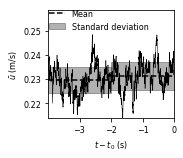

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
figure_folder = './Figures/'

# Load example of simulation preparation data
steadiness_example_file = './Data_simulation/10dx10d/th23.5h11/Steady.u'
steadiness_data = pd.read_csv(steadiness_example_file, sep=' ')
uBar = steadiness_data.uBar.to_numpy().reshape([2, -1])
uBar_mean = uBar.mean(axis=1)
uBar_std = uBar.std(axis=1)
ylim = uBar_mean.mean() + np.array([-3, 5]) * uBar_std.mean()
t = steadiness_data.t.to_numpy()[[0, -1]]

# Plot mean velocity
fig = plt.figure(figsize=[2.5, 2])
ax = fig.add_axes([0.25, 0.2, 0.7, 0.75], xlim=t - t[1], ylim=ylim)
ax.plot(steadiness_data.t - t[-1], steadiness_data.uBar, '-k', linewidth=0.5)
ax.plot([t[0] - t[-1], t.mean() - t[-1]], uBar_mean[0] * np.ones(2), '--k')
ax.fill_between([t[0] - t[-1], t.mean() - t[-1]],
                 (uBar_mean[0] - uBar_std[0]) * np.ones(2),
                 (uBar_mean[0] + uBar_std[0]) * np.ones(2),
                 color='k', alpha=0.3)
l = ax.plot([t.mean() - t[-1], t[1] - t[-1]], uBar_mean[1] * np.ones(2), '--k')[0]
r = ax.fill_between([t.mean() - t[-1], t[1] - t[-1]],
                    (uBar_mean[1] - uBar_std[1]) * np.ones(2),
                    (uBar_mean[1] + uBar_std[1]) * np.ones(2),
                    color='k', alpha=0.3)
fig.legend([l, r], ['Mean', 'Standard deviation'],
           loc=[0.25, 0.78], frameon=False, fontsize=8)
ax.set_xlabel(r'$t - t_0$ (s)', fontsize=8)
ax.set_ylabel(r'$\bar{u}$ (m/s)', fontsize=8)
ax.tick_params('both', labelsize=8)
fig.savefig(figure_folder + 'steadiness_example.pdf')
plt.show()

Simulations that attained a steady state, without the flow stopping entirely, are indicated in the figure below.

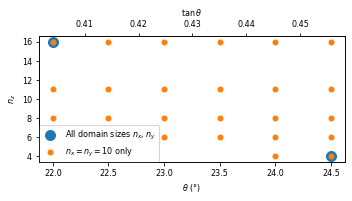

In [4]:
# Simulation domains {n_x}dx{n_y}d and the sim_ids of simulations ran for each
modes = ['steady']
domains = ['10dx10d', '14dx14d', '20dx20d', '10dx50d_wall']
sim_id_list = [['th22.0h08', 'th22.0h11', 'th22.0h16',
                'th22.5h08', 'th22.5h11', 'th22.5h16',
                'th23.0h06', 'th23.0h08', 'th23.0h11', 'th23.0h16',
                'th23.5h06', 'th23.5h08', 'th23.5h11', 'th23.5h16',
                'th24.0h04', 'th24.0h06', 'th24.0h08', 'th24.0h11', 'th24.0h16',
                'th24.5h04', 'th24.5h06', 'th24.5h08', 'th24.5h11', 'th24.5h16'],
               ['th22.0h16', 'th24.5h04'],
               ['th22.0h16', 'th24.5h04'],
               ['th22.0h16', 'th24.5h04']]

# Dataframe to store simulation properties
simulations = pd.DataFrame([pd.Series({'mode': mode, 'domain': domain, 'sim_id': sim_id,
                                       'th': 25.0 if mode == 'steep' else float(sim_id[2:6]),
                                       'nz': int(sim_id[7:]),
                                       'A': (float(domain[:2]) * float(domain[4:6])
                                             * (0.5 if domain == '10dx50d_wall' else 1))})
                            for mode in modes
                            for domain, sim_ids in zip(domains, sim_id_list)
                            for sim_id in sim_ids]).set_index(['mode', 'domain', 'sim_id'])
simulations.sort_index(inplace=True)

# Plot the $\theta-n_z$ phase space of simulations
fig = plt.figure(figsize=[5, 2.5])
ax_th = fig.add_axes([0.1, 0.15, 0.85, 0.7])
ax_th.scatter(simulations.loc['steady', '20dx20d'].th, simulations.loc['steady', '20dx20d'].nz,
              s=100, label=r'All domain sizes $n_x$, $n_y$')
ax_th.scatter(simulations.loc['steady', '10dx10d'].th, simulations.loc['steady', '10dx10d'].nz,
              s=25, label=r'$n_x = n_y = 10$ only')
ax_th.set_xlabel(r'$\theta$ $(\degree)$', fontsize=8)
ax_th.set_ylabel(r'$n_z$', fontsize=8)
ax_th.legend(loc=[0,0], fontsize=8)
ax_th.tick_params('both', labelsize=8)
ax_grad = ax_th.twiny()
ax_grad.set_xlim([np.tan(th * np.pi / 180) for th in ax_th.get_xlim()])
ax_grad.set_xlabel(r'$\tan \theta$', fontsize=8)
ax_grad.tick_params('both', labelsize=8)
fig.savefig(figure_folder + 'parameter_space.pdf')
plt.show()

### 2.4. Measurement of the steady state

Once each flow is steady, we simulate a further $\Delta t = 2$ seconds of flow, recording the properties of the flow, of the collisions between particles within it, and of the forces it applies to the base. Specifically, we record each particle's position, orientation, velocity, and angular velocity every $10^{-3}$ simulated seconds, as well as the list of contacts between particles. Whenever a particle collides with another particle or with the base, we record the time of the collision, the position of the point of contact, and the normal and tangential relative velocities of the colliding particles. And finally, at each timestep of $\delta t = 2.5\times 10^{-7}$ simulated seconds, we record the total force $\mathbf{F}$ exerted by the flow on the basal particles and, in the few places where these basal particles do not screen the base from the flow, on the base itself.

From these recorded data, for each simulation, we reconstruct base-normal profiles of the flow's kinematic and collisional properties, and calculate the effective friction coefficient between the flow and the base, the mean base-normal force exerted on the base by the flow, and the power spectrum of this base-normal force. Noting that $z = 0$ at the surface of the roughened base, profiles of mean volume fraction $\phi(z)$, particle velocity $\mathbf{u}(z)$, and granular temperature $T(z)$ are calculated from the particle position and velocity records using MercuryDPM's inbuilt coarse-graining program, with a Gaussian coarse-graining function of width $\bar{r}$. Using a newly written implementation of the same coarse-graining procedure, records of particle positions are combined with the lists of contacts to calculate, as a function of $z$, the proportion $P_c(z)$ of particles that are connected to the base by a chain of contacts, while collision records are used to calculate the mean number $n_I(z)$ of interparticle collisions per unit volume and unit time, as well as the mean squared normal and tangential relative velocities of colliding particles, $\langle \dot{\delta}_n^2 \rangle(z)$ and $\langle ||\dot{\mathbf{\delta}}_t||^2 \rangle(z)$, at the point of contact and at the instant of collision. These coarse-graining calculations are described fully in Appendix D, while the power spectrum $P_F$ of the base-normal force exerted by the flow is calculated by taking the discrete Fourier transform of $F_z$, as
$$
P_F(j/\Delta t) = \frac{\delta t^2}{\Delta t} \left| \sum_{k=0}^{\Delta t / \delta t - 1} F_z(k\delta t) e^{- 2 \pi i j k \delta t /\Delta t} \right|^2
$$

In simulating flow in a channel, we divide the domain into an outer region $y < n_y \bar{r}$ and an inner region $y > n_y \bar{r}$, and calculate two separate sets of profiles for each simulation, including in a region's averages only those particles with centres in that region, and those collisions with contact points in that region. Similarly, we record the forces exerted by the flow on both the outer region's base and the inner region's base, separated by the contact point through which the force is exerted, and calculate power spectra for the base-normal component of each force. We also record the force on the sidewall.

### 2.5. Note on timescales

In most simulations of granular flows, the aim is to examine macroscopic properties of the flow. Consequently, particles are often simulated with a lower stiffness than is realistic, permitting the use of longer timesteps and hence the simulation of more particles over a longer period of simulated time. Here, because we are concerned with high-frequency signals, we choose to ensure microscopic particle interactions are simulated as realistically as possible, using very small timesteps. As a result, there are significant differences between the timescales of flow evolution, of particle rearrangement, and of particle collisions. This is illustrated by the schematic below and by two movies, generated through steady-state simulations with $\theta = 22\degree$, $n_z = 8$ and $\theta = 24.5\degree$, $n_z = 8$. The schematic represents the typical timescales of different processes within a granular flow, and the typical frequencies of any corresponding signals. In each frame of each movie, corresponding to one timestep of a simulation, each line links the centres of two particles which are in contact, with its color corresponding to the normal force between them. Forces can be seen to evolve rapidly, with deformation at the contact point, while the relative positions of particle centres change much more slowly. The maximum of particles' total displacement between the first and last frame of the first movie is $0.009d$, while the corresponding maximum for the second movie is $0.04d$. Forces in the second movie often exceed $400\rho g d^3$, with the maximum normal force around $2500 \rho g d^3$. 

<img src="./Figures/timescales_schematic.png">
<tr>    
<td> <video width="450" src="./Figures/force_chains/th22.0h08/force_chains.mp4" controls> </video> </td>
<td> <video width="450" src="./Figures/force_chains/th24.5h08/force_chains.mp4" controls> </video> </td>
</tr>  


In [5]:
from scipy.integrate import odeint

## Calculate results from Hertz theory
#   Hertz modulus, bead mass, collision timescale, in rho, g, d units
k = 1/3. * E / (1 - nu**2)
m = np.pi / 6
tau = lambda v_n: (m**2 / (k**2 * v_n))**0.2
#   Non-dimensional power spectral density of normal force
#       Timestep for Hertzian force integration
hertz_dt = 0.002
#       Number of points in Fourier transform
hertz_nfft = 2**20
#       Calculate the normal force throughout a non-dimensionalised impact
def hertz_ode(s, t):
    return np.array([s[1], (-s[0])**1.5 if s[0] < 0 else 0])
#       Calculate the force's spectral density
hertz_t = np.arange(0, 5, hertz_dt)
solution = odeint(hertz_ode, np.array([0, -1]), hertz_t)
hertz_F_t = np.array([((-s)**1.5 if s < 0 else 0) for s in solution[:,0]])
hertz_f = np.arange(hertz_nfft) / (hertz_nfft * hertz_dt)
hertz_P_F = np.abs(np.fft.fft(hertz_F_t, n=hertz_nfft) * hertz_dt)**2
#       Non-dimensional function for spectral density
def zeta(f0):
    return np.interp(f0, hertz_f, hertz_P_F / 4)
#       Non-dimensional corner frequency
fid_c = np.argmax(hertz_P_F[::2] < 0.1 * hertz_P_F[:hertz_nfft//2])
hertz_f_c = hertz_f[fid_c]
zeta_f_c = zeta(hertz_f_c)

print('For a normal Hertzian collision between individual particles, the power spectrum has:')
print(' -Corner frequency $\hat{{f}}_c = {:.3f} / \\tau(v_n)$'
      .format(hertz_f_c))
print(' -Relative amplitude at this point $\zeta(\hat{{f}}_c) / \zeta(0) = {:.3f}$'
      .format(zeta_f_c))

For a normal Hertzian collision between individual particles, the power spectrum has:
 -Corner frequency $\hat{f}_c = 0.200 / \tau(v_n)$
 -Relative amplitude at this point $\zeta(\hat{f}_c) / \zeta(0) = 0.529$


## 3. Results

To illustrate the underlying physics, we non-dimensionalise all quantities by density $\rho$, gravitational acceleration $g$, and mean particle diameter $d$.

In [6]:
from scipy.optimize import curve_fit

# Particle density (km m^-3) and mean diameter (m), gravitational acceleration (m s^-2)
rho, d, g = 2530, 2e-3, 9.81
# Particle Young's modulus (rho g d), Poisson's ratio
E, nu = 74e9 / (rho * g * d), 0.22
# Simulation duration (rt(d / g))
Dt = 2 * np.sqrt(g / d)
# Particle mass (rho d**3)
m = np.pi / 6

## Locations of input and output files
data_folder = './Data_simulation/{}/{}/'
def data_filename(mode, domain, sim_id):
    return (data_folder.format(domain, sim_id)
            + ('RunWall' if domain == "10dx50d_wall" else 'RunSteady'))
experimental_data_folder = './Data_experiment/'
experimental_summary_filename = experimental_data_folder + 'results.txt'
experimental_profile_filename = experimental_data_folder + 'profiles/{:s}.txt'
transitional_regime_keys = np.array(['g0.46_h10', 'g0.48_h14', 'g0.50_h20',
                                     'g0.52_h28', 'g0.54_h40'])

# Read profiles of kinematic and collision variables into two lists of dicts
# and calculate derived properties of flow depth, pressure head, and flux
data = []
for mode, domain, sim_id in simulations.index:
    try:
        # Read the profiles of raw kinematic properties
        prof = pd.read_csv(data_filename(mode, domain, sim_id) + '.stat', sep=' ',
                           skiprows=[0,2], usecols=[2,3,5,6,7,17,20,22])
        # Create a dict of non-dimensionalised kinematic properties
        pf_k = {'z':prof.Z / d - (0 if mode == 'smooth' else 1),
                'phi':prof.Nu,
                'u':(prof.MomentumX / (rho * np.sqrt(g * d) * prof.Nu)),
                'T':(((prof.MomentumFluxXX + prof.MomentumFluxYY + prof.MomentumFluxZZ)
                      - (prof.MomentumX**2 + prof.MomentumY**2 + prof.MomentumZ**2) / (rho * prof.Nu))
                      / (3 * rho * g * d * prof.Nu)).clip(lower=0)}

        # Read the profiles of raw collisional properties
        prof = pd.read_csv(data_filename(mode, domain, sim_id) + '.cstat', sep=' ', skiprows=1)
        # Create a dict of non-dimensionalised collisional properties
        pf_c = {'z':prof.z / d - (0 if mode == 'smooth' else 1),
                'P_c':prof.P_c,
                'n_I':prof.f_I / np.sqrt(g / d**7),
                '<v_n^2>':prof['<v_n^2>'] / (g * d),
                '<v_t^2>':prof['<v_t^2>'] / (g * d)}
        
        # Read the power spectrum of base-normal force exerted on the base
        F_data = np.loadtxt(data_filename(mode, domain, sim_id) + '.P_F', max_rows=1, usecols=[1,3])
        prof = pd.read_csv(data_filename(mode, domain, sim_id) + '.P_F', skiprows=1, sep=' ')
        # Create a dict of non-dimensionalised power spectrum
        P_F = {'f': prof.f / np.sqrt(g / d),
               'P_Fx': prof.P_Fx * np.sqrt(g / d) / (rho * g * d**3)**2,
               'P_Fx_bar': prof.P_Fx_bar * np.sqrt(g / d) / (rho * g * d**3)**2,
               'P_Fy': prof.P_Fy * np.sqrt(g / d) / (rho * g * d**3)**2,
               'P_Fy_bar': prof.P_Fy_bar * np.sqrt(g / d) / (rho * g * d**3)**2,
               'P_Fz': prof.P_Fz * np.sqrt(g / d) / (rho * g * d**3)**2,
               'P_Fz_bar': prof.P_Fz_bar * np.sqrt(g / d) / (rho * g * d**3)**2}
        
        # Calculate derived quantities:
        #    the flow depth, overburden/pressure head, and flux
        #    the decay length of the particle contact network
        #    the mean base-normal stress applied on the base and the associated effective friction
        #    the corner frequency and spectral amplitude of the high-frequency component of P_F
        phi_m, id_m = pf_k['phi'].max(), pf_k['phi'].idxmax()
        h = pf_k['z'].iloc[(pf_k['phi'][id_m:] <= .5 * phi_m).idxmax()]
        ids = (0 <= pf_c['z']) & (pf_c['z'] <= h)
        decay_length = curve_fit(lambda z, l: np.exp(-(z + 0.5) / l),
                                 pf_c['z'][ids], pf_c['P_c'][ids],
                                 bounds=(0, np.inf))[0][0]
        fid_2 = (P_F['f'] >= 2 * P_F['f'].iloc[0]).idxmax()
        fid_c = (P_F['P_Fz_bar'].shift(-fid_2) < 0.1 * P_F['P_Fz_bar']).idxmax()
        P_Fx_intermed = np.interp(10, P_F['f'], P_F['P_Fx_bar'])
        P_Fy_intermed = np.interp(10, P_F['f'], P_F['P_Fy_bar'])
        P_Fz_intermed = np.interp(10, P_F['f'], P_F['P_Fz_bar'])

        data.append(pd.Series({'mode': mode, 'domain': domain, 'sim_id': sim_id,
                               'h': h,
                               'H': (pf_k['phi'] * pf_k['z'].diff().shift(-1)).sum(),
                               'q': (pf_k['phi'] * pf_k['u'] * pf_k['z'].diff().shift(-1)).sum(),
                               'l_d': decay_length,
                               'F_n': F_data[0] / (rho * g * d**3),
                               'mu': F_data[1],
                               'f_c': P_F['f'][fid_c],
                               'P_F0': P_F['P_Fz_bar'][fid_c] / zeta_f_c,
                               'P_F_y_i_ratio': zeta_f_c * P_Fy_intermed / P_F['P_Fz_bar'][fid_c],
                               'P_F_z_i_ratio': zeta_f_c * P_Fz_intermed / P_F['P_Fz_bar'][fid_c],
                               'P_F_xz_ratio': P_F['P_Fx_bar'][fid_c] / P_F['P_Fz_bar'][fid_c],
                               'P_F_i_xz_ratio': P_Fx_intermed / P_Fz_intermed,
                               'dF2': (P_F['P_Fz_bar'] * P_F['f'].diff()).sum(),
                               'pf_k': pd.DataFrame(pf_k),
                               'pf_c': pd.DataFrame(pf_c),
                               'P_F': pd.DataFrame(P_F)}))
        
    except OSError:
        print(f'Missing data for {mode} flow in {domain} domain, with simulation id {sim_id}')

# Combines all results into a dataframe
data = pd.DataFrame(data).set_index(['mode', 'domain', 'sim_id']).join(simulations)
# Adds inertial number estimate and gradient
data['I_hat'] = ((5 * data.q)
                 / (2 * data.h * data.H**1.5
                    * np.sqrt(np.cos(np.pi / 180 * data.th))))
data['grad'] = np.tan(np.pi / 180 * data.th)

# Read (dimensional) summary data from experiments
exp_data = pd.read_csv(experimental_summary_filename, skiprows=[1], sep='\s*,\s*',
                       engine='python')
exp_data.index = ['g{:.2f}_h{:02d}_{:d}'
                  .format(exp['Gradient'], int(exp['Gap']), int(exp['Repeat']))
                  for _, exp in exp_data.iterrows()]
exp_data['trans'] = [index[:-2] in transitional_regime_keys
                     for index in exp_data.index]
exp_data['dense'] = np.logical_not(exp_data.trans)
exp_data['A'] = 0.18 * 0.1
exp_data['th'] = np.arctan(exp_data.Gradient)
exp_data['u_bar'] = exp_data.q / exp_data.m
exp_data['F_n'] = exp_data.A * exp_data.m * g * np.cos(exp_data.th)
# Read experimental flow depths from (dimensionless) PTV results
h = []
for index in exp_data.index:
    pf = pd.read_csv(experimental_profile_filename.format(index),
                     skiprows=[1], sep='\s*,\s*', engine='python')
    h.append(pf.z[(pf.phi[pf.phi.idxmax():] < 0.5 * pf.phi.max()).idxmax()])
exp_data['h'] = np.array(h) * d
exp_data['phi'] = exp_data.m / (rho * exp_data.h)

### 3.1. Kinematic profiles

*Note: The majority of this section probably won't be relevant to the article, with the important points being a) that we can extract profiles of all the kinematic properties, b) that we can try to parametrise them, to link a few simple properties of the flow to the seismic signal, and c) that there's approximately zero slip at the base (c.f. the experiments, where we didn't know whether there was basal slip)*

Profiles of kinematic properties $\phi$, $u$, and $T$ can be seen below (or, if this is a static instance of the notebook, in the repository folder `./plots/`). In all simulations, volume fraction $\phi$ is approximately constant throughout the flow, before decreasing to zero over a distance of approximately $d = 2\bar{r}$. This allows a flow depth to be defined, as the $z$-value at which $\phi$ drops to half its maximum value,
$$
h = \min\{z > \argmax(\phi)|\phi(z) < \max \phi / 2\}
$$
For a flow with constant particle volume fraction below a level surface, this exactly corresponds to the intuitive flow depth, and the line $z = h$ is marked as a black dashed line in plots. Together with the pressure head and the volumetric flux,
$$
H = \int_{-\infty}^\infty \phi \text{ d}z,\qquad q = \int_{-\infty}^\infty \phi u \text{ d}z,
$$
this can be used to parametrise the flow. For example, the blue dashed line corresponds to the bulk volume fraction $H / h$

The downslope velocity $u(z)$ increases with $z$ from approximately zero at $z = 0$, with a convex profile where $z$ is close to 0 and greater than $h$. In between, profiles develop from approximately linear (blue dotted line) to approximately Bagnoldian (blue dashed line) with increasing slope angle $\theta$ and particle depth $n_z$, and this is reflected by the inertial number $I$ varying less from its bulk estimator (red dashed line),
$$
\hat{I} = \frac{5 d q}{2 h H \sqrt{g H \cos \theta}}.
$$
*This development probably corresponds to the diminishing influence of 'non-local' effects, as 'granular fluidity' increases*

Similarly, with increasing flow depth and slope angle, profiles of granular temperature $T$ develop from being monotonically increasing with $z$ to being S-shaped, with a peak near $z = 0$ followed by a monotonic decrease in $T$ until $z$ is approximately $h - 2d$. In the process, the profile of $T$ more closely approximates the prediction of kinetic theory (black dashed line), which is that
$$
T(z) \propto (d \partial_z u)^2,
$$
with the constant of proportionality dependent on the distribution functions and approximately equal to $g_T^2 = (0.3/\tan \theta)^2$ (see e.g. [this paper](https://people.maths.bris.ac.uk/~maajh/PDFPapers/JFMGranularChute1.pdf)). We note that $T$ is typically of the order of magnitude of $(2 d g_T q / h^2)^2$ (red dotted line), corresponding to the above relation for a linear velocity profile, and approaches the Bagnoldian prediction (red dashed line), $(g_T \hat{I})^2 gH \cos \theta (1 - z/h)$, with increasing $\theta$ and $n_z$.

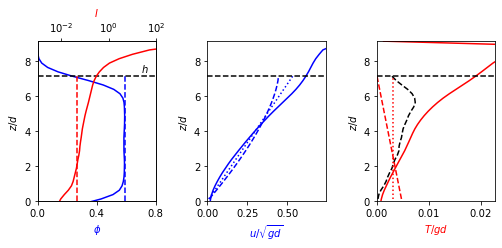

In [7]:
from ipywidgets import interact, fixed
from IPython.display import Image, display

# Dictionary to link domain ids and descriptions
domain_dict = {'10dx10d': 'n_x = n_y = 10',
               '14dx14d': 'n_x = n_y = 14',
               '20dx20d': 'n_x = n_y = 20',
               '10dx50d_wall': 'n_x = 10, n_y = 50'}

# Function called by drop-down menu for domain selection, creating menu for slope angle selection
def set_mode(plot, mode):
    domain_dropdown = interact(set_domain,
                               plot=fixed(plot),
                               mode=fixed(mode),
                               domain=[(domain_dict[domain], domain)
                                       for domain in data.index.get_level_values('domain').unique()])
    
def set_domain(plot, mode, domain):
    th_dropdown = interact(set_theta,
                           plot=fixed(plot),
                           mode=fixed(mode),
                           domain=fixed(domain),
                           theta=sorted(set([(sim_id[2:6] + ' degrees', sim_id[2:6])
                                             for sim_id in data.loc[mode, domain].index])))

# Function called by drop-down menu for slope angle selection, creating menu for depth selection
def set_theta(plot, mode, domain, theta):
    nz_dropdown = interact(set_nz,
                           plot=fixed(plot),
                           mode=fixed(mode),
                           domain=fixed(domain),
                           theta=fixed(theta),
                           nz=[data.loc[mode, domain, sim_id].nz
                               for sim_id in data.loc[mode, domain].index if sim_id[2:6]==theta])

# Function called by drop-down menu for flow depth selection, creating the appropriate plots
def set_nz(plot, mode, domain, theta, nz):
    sim_id = 'th{:}h{:02d}'.format(theta, nz)
    if (plot == 'kinematics'):
        plot_kinematics(mode, domain, sim_id)
    elif (plot == 'collisions'):
        plot_collisions(mode, domain, sim_id)
    elif (plot == 'P_F'):
        plot_P_F(mode, domain, sim_id)
    elif (plot == 'integrand'):
        plot_integrand(mode, domain, sim_id)
    else:
        print('Plot type {} not identified'.format(plot))
    plt.show()

# Function to plot the kinematic quantities' sim.pf_kiles, for a given selection
def plot_kinematics(mode, domain, sim_id):
    sim = data.loc[mode, domain, sim_id]
    
    # Calculate prefactor for temperature-shear^2 relation and overburden pressure
    g_T = 0.3 / np.tan(np.pi / 180 * sim.th)
    sigma0 = sim.H * np.cos(np.pi / 180 * sim.th)
    # Calculate properties for bulk inertial number and mean shear rate
    sigma = sigma0 * (1 - (sim.pf_k['phi'] * sim.pf_k['z'].diff().shift(-1)).cumsum() / sim.H)
    I = sim.pf_k['u'].diff() / (sim.pf_k['z'].diff() * np.sqrt(sigma))
    I_hat = (5 * sim.q) / (2 * sim.h * sim.H * np.sqrt(sigma0))
    gamma = 2 * sim.q / (sim.h * sim.H)
    
    # Plot volume fraction
    ids = (0 <= sim.pf_k['z']) & (sim.pf_k['z'] <= sim.h)
    fig = plt.figure(figsize=[18 / 2.52, 8 / 2.52])
    ax_phi = fig.add_axes([0.1, 0.15, 0.23, 0.7],
                          xlim=[0,0.8], xticks=[0, 0.4, 0.8],
                          ylim=[0, sim.h + 2])
    ax_I = ax_phi.twiny()
    ax_phi.plot(sim.pf_k['phi'], sim.pf_k['z'], '-b',
                sim.H / sim.h * np.ones(2), [0, sim.h], '--b',
                ax_phi.get_xlim(), sim.h * np.ones(2), '--k')
    ax_phi.set_xlabel(r'$\phi$', color='b')
    ax_phi.set_ylabel(r'$z / d$')
    ax_phi.text(0.7, sim.h + 0.25, r'$h$')
    ax_I.plot(I, sim.pf_k['z'], '-r',
              I_hat * np.ones(2), [0, sim.h], '--r')
    ax_I.set_xscale('log')
    ax_I.set_xlim([1e-3, 1])
    ax_I.set_xticks([1e-2, 1, 1e2])
    ax_I.set_xlabel(r'$I$', color='r')
    ax_I.set_ylim([0, sim.h + 2])
    
    # Plot velocity and its theoretical linear and Bagnoldian sim.pf_kiles
    ax_u = fig.add_axes([0.43, 0.15, 0.23, 0.7], ylim=[0, sim.h + 2],
                        xlim=[0, 1.2 * sim.pf_k['u'][ids].max()])
    ax_u.plot(sim.pf_k['u'], sim.pf_k['z'], '-b',
              gamma * sim.pf_k['z'][ids], sim.pf_k['z'][ids], ':b',
              (2./3. * I_hat * sim.h * np.sqrt(sigma0)
               * (1 - (1 - sim.pf_k['z'][ids] / sim.h)**1.5)), sim.pf_k['z'][ids], '--b',
              ax_u.get_xlim(), sim.h * np.ones(2), '--k')
    ax_u.set_xlabel(r'$u / \sqrt{g d}$', color='b')
    ax_u.set_ylabel(r'$z / d$')
    
    # Plot granular temperature and its theoretical sim.pf_kiles
    ax_T = fig.add_axes([0.76, 0.15, 0.23, 0.7], ylim=[0, sim.h + 2],
                        xlim=[0, 1.2 * sim.pf_k['T'][ids].max()])
    ax_T.plot(sim.pf_k['T'], sim.pf_k['z'], '-r',
              (g_T * sim.pf_k['u'].diff() / sim.pf_k['z'].diff())[ids]**2, sim.pf_k['z'][ids], '--k',
              (g_T * gamma)**2 * np.ones(ids.sum()), sim.pf_k['z'][ids], ':r',
              (g_T * I_hat)**2 * sigma0 * (1 - sim.pf_k['z'][ids] / sim.h), sim.pf_k['z'][ids], '--r',
              ax_T.get_xlim(), sim.h * np.ones(2), '--k')
    ax_T.set_xlabel(r'$T / gd$', color='r')
    ax_T.set_ylabel(r'$z / d$')

# Create drop down menu for domain selection, to eventually plot kinematics
dropdown = interact(set_domain, plot=fixed('kinematics'), mode=fixed('steady'),
                    domain=data.index.get_level_values('domain').unique())

### 3.2. Collisional profiles

*Note: Again, the majority of this section won't be relevant to the article. The important points are that a) collisional and kinematic properties are fairly consistent with each other, so that b) we can try to parametrise them.*

Profiles of collisional properties can be seen below (or, if this is a static notebook, in the repository folder `./plots/`). For all flows, the probability $P_c(z)$ that a particle is connected to the base decreases dramatically with height from $P_c(-d/2) \approx 1$, with the initial phase of this decrease increasingly close to a fitted exponential decay $\hat{P}_c = e^{-(2z + d)/2\lambda d}$ (blue dotted line) as slope angle $\theta$ and particle depth $n_z$ increase. The non-dimensional decay length $\lambda$ decreases with $\theta$.

*These changes likely correspond to decreasing 'non-locality'/increasingly constant $I$, such that the proportion of particles connected to the layer below is approx. constant with depth, and to decreasing cluster size/increasing 'granular fluidity' with $I$.*

Profiles of the mean squared normal relative velocity of collisions $\langle v_n^2 \rangle$ are similar to those of the doubled granular temperature $2T$ (black dashed line), as are those of the halved, mean squared tangential relative velocity $\langle v_t^2 \rangle / 2$, corresponding to the mean squared value of a single random, non-normal component of relative velocity. Mean squared velocities are of the same order of magnitude as the prediction assuming constant shear $2 (2 d g_T q / h^2)^2$ (blue dotted line), while at the highest values of $\theta$ and $n_z$, they're well approximated in the flow's bulk by the prediction assuming a Bagnoldian velocity profile, $2 g H \cos \theta (g_T I_b)^2 (1 - z/h)$ (blue dashed line).

*We'd expect $\langle v_n^2 \rangle = \langle v_t^2 \rangle / 2 = 2T$ if the velocities of colliding particles were completely uncorrelated, so that each component of two particles' relative velocity had mean zero and variance $2 T$. It makes sense that this is closer to being true for the tangential component, since the normal component determines whether there will be a collision, introducing correlation beyond that between the velocities of neighbouring particles.*

The number $n_I$ of interparticle collisions per unit volume and time is approximately consistent with that required to bear the portion of overburden pressure that's not borne by connections to the base. Noting that the steady-state overburden pressure at a height $z$ will be
$$
\sigma_{zz}(z) = \rho g \cos \theta \int_z^\infty \phi(z') \text{ d}z',
$$
and supposing that a proportion $P_c(z)$ of this is borne by prolonged contacts forming a force chain to the base, the vertical impulse that must be transferred by impacts, per unit area and time, through a surface of constant $z$, is $(1 - P_c)\sigma_{zz}$. Taking impacts to be perfectly elastic, dominated by normal interactions, and equally likely anywhere on a particle's surface, the mean vertical impulse transferred by a collision will be $\frac{1}{2}m \sqrt{\langle v_n^2 \rangle}$, for $m = \pi \rho d^3 / 6$, and this will be transferred over an average vertical distance $d/2$. The number of collisions will then be
$$
n_I(z) = \frac{4(1 - P_c) \sigma_{zz}}{d m \sqrt{\langle v_n^2 \rangle}}.
$$
This is marked by the black dashed line, with the red dotted and dashed lines marking the theoretical predictions for linear and Bagnoldian velocity profiles,
$$
n_{\text{linear}}(z) = \frac{48 g h^2 H \cos \theta}{\pi d^5 g_T q} (1 - \hat{P}_c)(1 - z / h)
$$
and
$$
n_{\text{Bagnold}}(z) = \frac{24 \sqrt{g H \cos \theta}}{\pi d^4 g_T I_b} (1 - \hat{P}_c)\sqrt{1 - z / h}.
$$

*Note: We should probably consider the proportion of particles connected to particles below them, rather than the proportion connected to the base, should probably offset this by $d/4$ to account for the difference between particle centres and their contact points. Or perhaps we should consider the kinetic stress directly, since Mercury DPM allows this.*

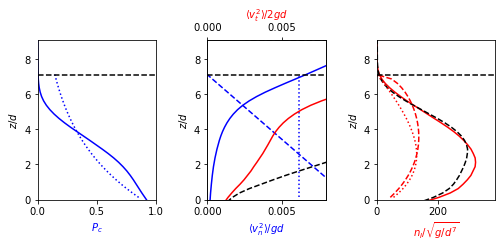

In [8]:
# Function to plot the kinematic quantities' profiles, for a given selection
def plot_collisions(mode, domain, sim_id):
    # Examine the data for the corresponding simulation
    sim = data.loc[mode, domain, sim_id]
    
    # Calculate prefactor for temperature-shear^2 relation and overburden pressure
    g_T = 0.3 / np.tan(np.pi / 180 * sim.th)
    sigma0 = sim.H * np.cos(np.pi / 180 * sim.th)
    sigma = sigma0 * (1 - (sim.pf_k['phi'] * sim.pf_k['z'].diff()).cumsum() / sim.H)
    # Calculate properties for bulk inertial number and mean shear rate
    I_hat = (5 * sim.q) / (2 * sim.h * sim.H * np.sqrt(sigma0))
    gamma = 2 * sim.q / (sim.h * sim.H)
    
    # Ids corresponding to positions within the flow
    ids = (0 <= sim.pf_c['z']) & (sim.pf_c['z'] <= sim.h)

    # Profile of P_c for a depth-constant proportion connected to an underlying particle
    P_c_exp = np.exp(-(sim.pf_c['z'][ids] + 0.5) / sim.l_d)
    
    # Theoretical profiles for collision frequency density, using kinetic theory
    # kt, linear, bagnold correspond to recorded, linear, and Bagnold velocity profiles
    n_I_kt = (4 * np.interp(sim.pf_c['z'], sim.pf_k['z'], sigma) * (1 - sim.pf_c['P_c'])
              / (m * np.sqrt(sim.pf_c['<v_n^2>'])))
    n_I_linear = (4 * sigma0 * (1 - sim.pf_c['z'][ids] / sim.h) * (1 - P_c_exp)
                  / (m * np.sqrt(2) * g_T * gamma))
    n_I_bagnold = (4 * np.sqrt(sigma0 * (1 - sim.pf_c['z'][ids] / sim.h)) * (1 - P_c_exp)
                   / (m * np.sqrt(2) * g_T * I_hat))
    
    # Set up figure for collisional properties
    fig = plt.figure(figsize=[18 / 2.52, 8 / 2.52])
    # Plot proportions of particles connected to the base, recorded and theoretical
    ax_P_c = fig.add_axes([0.1, 0.15, 0.23, 0.7],
                          xlim=[0, 1], ylim=[0, sim.h + 2])
    ax_P_c.plot(sim.pf_c['P_c'], sim.pf_c['z'], '-b',
                P_c_exp, sim.pf_c['z'][ids], ':b',
                ax_P_c.get_xlim(), sim.h * np.ones(2), '--k')
    ax_P_c.set_xlabel(r'$P_c$', color='b')
    ax_P_c.set_ylabel(r'$z / d$')
    # Plot normal and tangential impact velocities, recorded and according to each theory
    ax_v_n = fig.add_axes([0.43, 0.15, 0.23, 0.7],
                          xlim=[0, 1.2 * sim.pf_c['<v_n^2>'][ids].max()],
                          ylim=[0, sim.h + 2])
    ax_v_t = ax_v_n.twiny()
    ax_v_t.set_xlim([0, 1.2 * sim.pf_c['<v_n^2>'][ids].max()])
    ax_v_n.plot(sim.pf_c['<v_n^2>'], sim.pf_c['z'], '-b',
                2 * sim.pf_k['T'], sim.pf_k['z'], '--k',
                2 * (g_T * gamma)**2 * np.ones(ids.sum()), sim.pf_c['z'][ids], ':b',
                2 * (g_T * I_hat)**2 * sigma0 * (1 - sim.pf_c['z'][ids] / sim.h), sim.pf_c['z'][ids], '--b',
                ax_v_n.get_xlim(), sim.h * np.ones(2), '--k')
    ax_v_n.set_xlabel(r'$\langle v_n^2 \rangle / gd$', color='blue')
    ax_v_n.set_ylabel(r'$z / d$')
    ax_v_t.plot(sim.pf_c['<v_t^2>'] / 2, sim.pf_c['z'], '-r')
    ax_v_t.set_xlabel(r'$\langle v_t^2 \rangle / 2gd$', color='red')
    ax_v_t.set_ylim([0, sim.h + 2])
    # Plot impact frequency density, recorded and according to each theory
    ax_n_I = fig.add_axes([0.76, 0.15, 0.23, 0.7],
                          xlim=[0, 1.2 * sim.pf_c['n_I'][ids].max()],
                          ylim=[0, sim.h + 2])
    ax_n_I.plot(sim.pf_c['n_I'], sim.pf_c['z'], '-r',
                n_I_kt, sim.pf_c['z'], '--k',
                n_I_linear, sim.pf_c['z'][ids], ':r',
                n_I_bagnold, sim.pf_c['z'][ids], '--r',
                ax_n_I.get_xlim(), sim.h * np.ones(2), '--k')
    ax_n_I.set_xlabel(r'$n_I / \sqrt{g / d^7}$', color='r')
    ax_n_I.set_ylabel(r'$z / d$')

dropdown = interact(set_domain, plot=fixed('collisions'), mode=fixed('steady'),
                    domain=data.index.get_level_values('domain').unique())

In [9]:
# Plot Figure for publication, of kinematic and collisional properties' depth profiles

mode = 'steady'
domain = '10dx10d'
sim_ids = ['th22.0h08', 'th24.5h16']
labels = [['a', 'b', 'c', 'd', 'e', 'f'],
          ['g', 'h', 'i', 'j', 'k', 'l']]

y_extents = np.array([data.loc[mode, domain, sim_id].h for sim_id in sim_ids])
y_extents *= 0.6 / y_extents.sum()
y_positions = [0.3 + y_extents[1], 0.1]

fig = plt.figure(figsize=[23 / 2.52, 11.5 / 2.52])
for y_pos, y_ext, label, sim_id in zip(y_positions, y_extents, labels, sim_ids):
    sim = data.loc[mode, domain, sim_id]
    ids_k = (0 <= sim.pf_k['z']) & (sim.pf_k['z'] <= sim.h)
    ids_c = (0 <= sim.pf_c['z']) & (sim.pf_c['z'] <= sim.h)
    yticks = range(0, int(sim.h + 2), 5)
    
    # Plot volume fraction
    ax_phi = fig.add_axes([0.05, y_pos, 0.13, y_ext],
                          xlim=[0,0.8], xticks=[0, 0.4, 0.8],
                          ylim=[0, sim.h + 2], yticks=yticks)
    ax_phi.plot(sim.pf_k['phi'], sim.pf_k['z'], '-k',
                sim.H / sim.h * np.ones(2), [0, sim.h], ':k',
                ax_phi.get_xlim(), sim.h * np.ones(2), ':k')
    ax_phi.set_xlabel(r'$\phi$', fontsize=8)
    ax_phi.set_ylabel(r'$z / d$', fontsize=8)
    ax_phi.tick_params('both', labelsize=8)
    ax_phi.text(0.8 * sim.H / sim.h, sim.h + 0.4, r'$z = h$', fontsize=8)
    ax_phi.text(sim.H / sim.h + 0.04, 0.8 * sim.h, r'$\bar{\phi}$', fontsize=8)
    fig.text(0.03, y_pos + y_ext, label[0], fontsize=10, fontweight='bold')
    
    # Plot downslope velocity
    ax_u = fig.add_axes([0.21, y_pos, 0.13, y_ext],
                        xlim=[0, 1.2 * sim.pf_k['u'][ids_k].max()],
                        ylim=[0, sim.h + 2], yticks=yticks)
    ax_u.plot(sim.pf_k['u'], sim.pf_k['z'], '-k',
              ax_u.get_xlim(), sim.h * np.ones(2), ':k')
    ax_u.set_xlabel(r'$u_x / \sqrt{g d}$', fontsize=8)
    ax_u.tick_params('both', labelsize=8)
    fig.text(0.19, y_pos + y_ext, label[1], fontsize=10, fontweight='bold')
    
    # Plot granular temperature
    T_hat = (0.3 / np.tan(np.pi / 180 * sim.th)
             * sim.pf_k['u'].diff() / sim.pf_k['z'].diff())[ids_k]**2
    ax_T = fig.add_axes([0.37, y_pos, 0.13, y_ext],
                        xlim=[0, 1.2 * sim.pf_k['T'][ids_k].max()],
                        ylim=[0, sim.h + 2], yticks=yticks)
    lines = ax_T.plot(sim.pf_k['T'], sim.pf_k['z'], '-k',
                      T_hat, sim.pf_k['z'][ids_k], '--k')
    ax_T.plot(ax_T.get_xlim(), sim.h * np.ones(2), ':k')
    ax_T.set_xlabel(r'$T / gd$', fontsize=8)
    ax_T.tick_params('both', labelsize=8)
    fig.text(0.35, y_pos + y_ext, label[2], fontsize=10, fontweight='bold')
    
    # Plot probability of connection to the base
    P_c_hat = np.exp(-(sim.pf_c['z'][ids_c] + 0.5) / sim.l_d)    
    ax_P_c = fig.add_axes([0.53, y_pos, 0.13, y_ext],
                          xlim=[0, 1],
                          ylim=[0, sim.h + 2], yticks=yticks)
    ax_P_c.plot(sim.pf_c['P_c'], sim.pf_c['z'], '-k',
                P_c_hat, sim.pf_c['z'][ids_c], '--k',
                ax_P_c.get_xlim(), sim.h * np.ones(2), ':k')
    ax_P_c.set_xlabel(r'$\mathcal{P}_c$', fontsize=8)
    ax_P_c.tick_params('both', labelsize=8)
    fig.text(0.51, y_pos + y_ext, label[3], fontsize=10, fontweight='bold')
    
    # Plot mean squared impact velocities
    ax_v_n = fig.add_axes([0.69, y_pos, 0.13, y_ext],
                          xlim=[0, 2.4 * sim.pf_k['T'][ids_k].max()],
                          ylim=[0, sim.h + 2], yticks=yticks)
    ax_v_n.plot(sim.pf_c['<v_n^2>'], sim.pf_c['z'], '-k',
                2 * sim.pf_k['T'], sim.pf_k['z'], '--k',
                ax_v_n.get_xlim(), sim.h * np.ones(2), ':k')
    ax_v_n.set_xlabel(r'$\langle \dot{\delta}_n^2 \rangle / gd$', fontsize=8)
    ax_v_n.tick_params('both', labelsize=8)
    ax_v_t = ax_v_n.twiny()
    ax_v_t.plot(sim.pf_c['<v_t^2>'], sim.pf_c['z'], '-r')
    ax_v_t.set_xticks([2.0 * x for x in ax_v_n.get_xticks()])
    ax_v_t.set_xlim([2.0 * x for x in ax_v_n.get_xlim()])
    ax_v_t.set_xlabel(r'$\langle \dot{\delta}_t^2 \rangle / gd$', color='red', fontsize=8)
    ax_v_t.tick_params('both', labelsize=8, color='red', labelcolor='red')
    fig.text(0.67, y_pos + y_ext, label[4], fontsize=10, fontweight='bold')
    
    # Plot impact rate
    p_hat0 = sim.H * np.cos(np.pi / 180 * sim.th)
    p_hat = p_hat0 * (1 - (sim.pf_k['phi'] * sim.pf_k['z'].diff()).cumsum() / sim.H)
    n_I_hat = (4 * np.interp(sim.pf_c['z'], sim.pf_k['z'], p_hat) * (1 - sim.pf_c['P_c'])
               / (m * np.sqrt(sim.pf_c['<v_n^2>'])))
    ax_n_I = fig.add_axes([0.85, y_pos, 0.13, y_ext],
                          xlim=[0, 1.2 * sim.pf_c['n_I'][ids_c].max()],
                          ylim=[0, sim.h + 2], yticks=yticks)
    ax_n_I.plot(sim.pf_c['n_I'], sim.pf_c['z'], '-k',
                n_I_hat, sim.pf_c['z'], '--k',
                ax_n_I.get_xlim(), sim.h * np.ones(2), ':k')
    ax_n_I.set_xlabel(r'$n_I / \sqrt{g / d^7}$', fontsize=8)
    ax_n_I.tick_params('both', labelsize=8)
    ax_u_dash = ax_n_I.twiny()
    ax_u_dash.plot((sim.pf_k['u'].diff() / sim.pf_k['z'].diff())[ids_k], sim.pf_k['z'][ids_k], '-r')
    ax_u_dash.set_xlim([0, ax_u_dash.get_xlim()[1]])
    ax_u_dash.set_xlabel(r"$u_x'(z) / \sqrt{g / d}$", color='red', fontsize=8)
    ax_u_dash.tick_params('both', labelsize=8, color='red', labelcolor='red')
    fig.text(0.83, y_pos + y_ext, label[5], fontsize=10, fontweight='bold')

fig.legend(lines, ['Observation', 'Theoretical approximant'],
           loc=[0.36, y_positions[0] - 0.15], fontsize=8, ncol=2)
plt.savefig(figure_folder + 'depth_profiles.pdf')
plt.close()

In [10]:
# Plot Figure for publication, of effect of domain size

mode = 'steady'
domains = ['10dx10d', '14dx14d', '20dx20d', '10dx50d_wall']
sim_ids = ['th22.0h16', 'th24.5h04']
select_color = lambda A: np.ones(3) * 0.8 * (1 - A / data.A.max())
#from matplotlib import colormaps
#select_color = lambda A: colormaps['viridis'](A / data.A.max())
repeat_sims = [('10dx10d', 'th24.5h04')]
labels = [['a', 'b'], ['c', 'd']]

# Read kinematic and collisional profiles for the repeat simulations
repeat_data = []
for domain, sim_id in repeat_sims:
    try:
        prof = pd.read_csv(data_filename(mode, domain, sim_id + '_repeat') + '.stat',
                           sep=' ', skiprows=[0,2], usecols=[2,3,5,6,7,17,20,22])
        pf_k = pd.DataFrame({'z':prof.Z / d -  1,
                             'phi':prof.Nu,
                             'u':(prof.MomentumX / (rho * np.sqrt(g * d) * prof.Nu))})
        phi_m, id_m = pf_k['phi'].max(), pf_k['phi'].idxmax()
        h = pf_k['z'].iloc[(pf_k['phi'][id_m:] <= .5 * phi_m).idxmax()]
        prof = pd.read_csv(data_filename(mode, domain, sim_id + '_repeat') + '.cstat',
                           sep=' ', skiprows=1)
        pf_c = pd.DataFrame({'z':prof.z / d - 1,
                             'P_c':prof.P_c})
        repeat_data.append(pd.Series({'mode': mode, 'domain': domain, 'sim_id': sim_id,
                                      'h': h,
                                      'pf_k': pd.DataFrame(pf_k),
                                      'pf_c': pd.DataFrame(pf_c)}))
    
    except OSError:
        print(f'Missing data for {mode} flow in {domain} domain, with simulation id {sim_id}_repeat')

# Combines all results into a dataframe
repeat_data = pd.DataFrame(repeat_data).set_index(['mode', 'domain', 'sim_id'])

y_lims = data.loc[mode, domains, sim_ids].h.groupby('sim_id').max() + 2
y_extents = 0.65 * y_lims / y_lims.sum()
y_positions = [0.3 + y_extents[1], 0.15]

fig = plt.figure(figsize=[8 / 2.52, 8 / 2.52])
for sim_id, y_pos, y_ext, y_lim, label in zip(sim_ids, y_positions, y_extents, y_lims, labels):
    y_ticks = np.arange(0, y_lim, 5)
    
    # Plot downslope velocity
    ax_u = fig.add_axes([0.15, y_pos, 0.35, y_ext],
                        ylim=[0, y_lim], yticks=y_ticks)
    ax_P_c = fig.add_axes([0.6, y_pos, 0.35, y_ext],
                      xlim=[0, 1], xticks=[0, .5, 1],
                      ylim=[0, y_lim], yticks=y_ticks)
    x_lim, lines = [], []
    for domain in domains:
        sim = data.loc[mode, domain, sim_id]
        color = select_color(sim.A)
        lstyle = '--' if sim.A == 250 else '-'
        if (mode, domain, sim_id) in repeat_data.index:
            r_sim = repeat_data.loc[mode, domain, sim_id]
            h = 0.5 * (r_sim.h + sim.h)
            dh = np.sqrt(2) * np.abs(r_sim.h - h)
            r_u = np.interp(sim.pf_k['z'], r_sim.pf_k['z'], r_sim.pf_k['u'])
            u = 0.5 * (r_u + sim.pf_k['u'])
            du = np.sqrt(2) * np.abs(r_u - u)
            r_P_c = np.interp(sim.pf_c['z'], r_sim.pf_c['z'], r_sim.pf_c['P_c'])
            P_c = 0.5 * (r_P_c + sim.pf_c['P_c'])
            dP_c = np.sqrt(2) * (r_P_c - P_c)
        else:
            h, dh = sim.h, 0
            u, du = sim.pf_k['u'], 0
            P_c, dP_c = sim.pf_c['P_c'], 0
        
        ids_k = (0 <= sim.pf_k['z']) & (sim.pf_k['z'] <= h)
        x_lim.append(1.2 * (u + du)[ids_k].max())
        lines.append(ax_u.plot(u, sim.pf_k['z'],
                               lstyle, c=color, label=f'{sim.A:.0f}')[0])
        ax_u.fill_betweenx(sim.pf_k['z'], u - du, u + du,
                           facecolor=color, edgecolor=None, alpha=0.5)
        ax_u.plot(ax_u.get_xlim(), h * np.ones(2), ':', c=color)
        ax_u.fill_between(ax_u.get_xlim(), (h - dh) * np.ones(2), (h + dh) * np.ones(2),
                          color=color, alpha=0.5)
        ids_c = (0 <= sim.pf_c['z']) & (sim.pf_c['z'] <= h)
        ax_P_c.plot(P_c, sim.pf_c['z'], lstyle, c=color)
        ax_P_c.fill_betweenx(sim.pf_c['z'], P_c - dP_c, P_c + dP_c, color=color, alpha=0.5)
        ax_P_c.plot(ax_P_c.get_xlim(), h * np.ones(2), ':', c=color)
        ax_P_c.fill_between(ax_P_c.get_xlim(), (h - dh) * np.ones(2), (h + dh) * np.ones(2),
                            color=color, alpha=0.5)
    ax_u.set_xlim([0, max(x_lim)])
    ax_u.set_xlabel(r'$u_x / \sqrt{g d}$', fontsize=8)
    ax_u.set_ylabel(r'$z / d$', fontsize=8)
    ax_u.tick_params('both', labelsize=8)
    fig.text(0.1, y_pos + y_ext, label[0], fontsize=10, fontweight='bold')
    ax_P_c.set_xlabel(r'$\mathcal{P}_c$', fontsize=8)
    ax_P_c.tick_params('both', labelsize=8)
    fig.text(0.55, y_pos + y_ext, label[1], fontsize=10, fontweight='bold')

fig.legend(handles=lines, loc=[0.75, 0.6], fontsize=8,
           title=r'$A/d^2$',title_fontsize=8)
plt.savefig(figure_folder + 'domain_profiles.pdf')
plt.close()

### 3.3. Power spectrum of the base-normal basal force

Plots of the power spectra $P_{F_\cdot}(f)$ of basal force components $F_x$, $F_y$, and $F_z$ (the thin red, green, and blue lines, respectively) can be seen below (or, if this is a static notebook, in the repository folder `./plots/`).

The power spectra at zero frequency are related to the mean base-normal force exerted by the flow, with
$$
P_{F_\cdot}(0) = \langle F_\cdot \rangle_{\Delta t}^2 \Delta t,
$$
and the figure below shows the mean base-normal force approximated extremely well by the weight of overlying particles, so that
$$
\langle F_z \rangle_{\Delta t} \approx m g n_x n_y n_z \cos \theta.
$$
This follows from the steadiness required of the simulated flows, as does the observation that the effective friction $\mu = \langle F_x \rangle_{\Delta t} / \langle F_z \rangle_{\Delta t}$ is approximated extremely well by $\tan \theta$.

*At low frequencies, $f \ll \sqrt{g/d}$, different particles' contributions to $\tilde{F}_z$ are correlated with the mean flow properties, which vary slightly over the duration of the simulation. Consequently, the contributions are correlated and $P_F$ scales with $(n_x n_y)^2$. As $f$ increases, these correlations decrease and so $P_F$ decreases likewise.*

At high frequencies, $f \gg \sqrt{g/d}$, spectra $P_{F_\cdot}$ are noisy, but their moving averages $\langle P_{F_\cdot} \rangle_{\Delta f}$ over a frequency range $\Delta f = \sqrt{g/d}$ (the thick red, green, and blue lines) have the same form as the (appropriately scaled) power spectrum of the Hertzian normal forces exerted during the collisions of individual particles. Since the moving average of $P_{F_z}$ is consistently larger than those of $P_{F_x}$ and $P_{F_y}$, we focus on the base-normal force component's power spectrum.

We first defined the corner frequency $f_c$ as the frequency at which a frequency doubling corresponds to a 10 dB decrease in $P_{F_z}$, so that $\langle P_{F_z} (2f_c) \rangle_{\Delta f} = \langle P_{F_z}(f_c) \rangle_{\Delta f} / 10$. If $(2 m v_n)^2 \zeta(f)$ is the spectrum of the normal force exerted during a normal, perfectly elastic, Hertzian collision of two mass $m$, diameter $d$ particles at relative velocity $v_n$, then $\zeta(0) = 1$ and the corner frequency of $\zeta$ will be
$$
\hat{f}_c = 0.2 / \tau(v_n) \text{ for } \tau(v_n) =  \left(\frac{m^2}{k_n^2 v_n}\right)^{1/5},
$$
where the stiffness constant $k_n$ is defined in relation to the particles' material's Young's modulus $E$ and Poisson ratio $\nu$ by $k_n = E \sqrt{d} / 3 (1 - \nu^2)$. Since $\zeta(\hat{f}_c) = 0.5 = 0.5 \zeta(0)$, I correspondingly define the high-frequency power spectral amplitude as $P_F^0 = 2 P_{F_z}(f_c)$. The corner frequency $f_c$ and the power spectral amplitude $P_F^0$ are marked by blue dashed lines and the Hertzian curve is $P_F^0 \zeta(0.2 f / f_c)$ (solid black line).

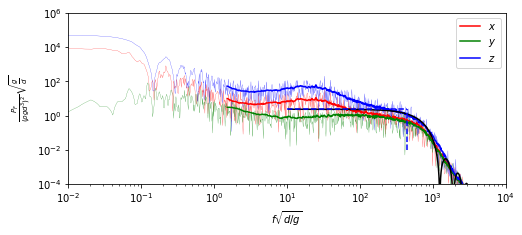

In [11]:
# Compare the mean force with the overlying particle weight
F_n_hat = m * data.A * data.nz * np.cos(np.pi / 180 * data.th)

fig = plt.figure(figsize=[8, 3])

ax_Fn = fig.add_axes([0.1, 0.2, 0.3, 0.76], xscale='log', yscale='log',
                     xlim=[1e2, 1e4], ylim=[1e2, 1e4])
sc = ax_Fn.scatter(F_n_hat.loc['steady'], -data.loc['steady'].F_n,
                   s=0.2*data.loc['steady'].A,
                   c=data.loc['steady'].H, cmap='plasma', vmin=0, vmax=10)
ax_Fn.plot([F_n_hat.min(), F_n_hat.max()], [F_n_hat.min(), F_n_hat.max()], '--k')
ax_Fn.set_xlabel(r'$m g n_x n_y n_z \cos \theta$', fontsize=8)
ax_Fn.set_ylabel(r'$-\langle F_z \rangle$', fontsize=8)

# Compare the slope gradient with the effective friction
grad = np.tan(np.pi / 180 * data.th)
ax_mu = fig.add_axes([0.5, 0.2, 0.3, 0.76], xlim=[0.4, 0.46])
ax_mu.scatter(grad.loc['steady'], data.loc['steady'].mu,
              s=0.2*data.loc['steady'].A,
              c=data.loc['steady'].H, cmap='plasma', vmin=0, vmax=10)
ax_mu.plot([grad.min(), grad.max()], [grad.min(), grad.max()], '--k')
ax_mu.set_xlabel(r'$\tan \theta$', fontsize=8)
ax_mu.set_ylabel(r'$\mu$', fontsize=8)

ax_c = fig.add_axes([0.85, 0.2, 0.02, 0.76])
fig.colorbar(sc, ax_c)
ax_c.set_ylabel(r'$H / d$', fontsize=8)
ax_c.yaxis.set_label_coords(4, 0.5)
ax_c.tick_params(labelsize=8)

plt.show()

# Function to plot the power spectra of basal forces, for a given simulation
def plot_P_F(mode, domain, sim_id):
    sim = data.loc[mode, domain, sim_id]
    
    fid_hf = (sim.f_c * hertz_f / hertz_f_c) > 10
    
    fig = plt.figure(figsize=[18 / 2.52, 8 / 2.52])
    ax = fig.add_axes([0.1, 0.2, 0.85, 0.75], xscale='log', yscale='log',
                      xlim=[1e-2, 1e4], ylim=[1e-4, 1e6])
    ax.plot(sim.P_F['f'], sim.P_F['P_Fx'], '-r',
            sim.P_F['f'], sim.P_F['P_Fy'], '-g',
            sim.P_F['f'], sim.P_F['P_Fz'], '-b',
            linewidth=0.2)
    lines = ax.plot(sim.P_F['f'], sim.P_F['P_Fx_bar'], '-r',
                    sim.P_F['f'], sim.P_F['P_Fy_bar'], '-g',
                    sim.P_F['f'], sim.P_F['P_Fz_bar'], '-b')
    ax.plot(hertz_f[fid_hf] / hertz_f_c * sim.f_c, hertz_P_F[fid_hf] / 4 * sim.P_F0, '-k',
            sim.f_c * np.ones(2), [1e-2, sim.P_F0], '--b',
            [10, sim.f_c], sim.P_F0 * np.ones(2), '--b')
    ax.set_xlabel(r'$f \sqrt{d / g}$')
    ax.set_ylabel(r'$\frac{P_F}{(\rho g d^3)^2} \sqrt{\frac{g}{d}}$')
    ax.legend(lines, [r'$x$', r'$y$',r'$z$'], loc = 'upper right')

dropdown = interact(set_domain, plot=fixed('P_F'), mode=fixed('steady'),
                    domain=data.index.get_level_values('domain').unique())

In [12]:
# Plot Figure for publication, of basal forces' power spectra

mode = 'steady'
domain = '10dx10d'
sim_ids = ['th22.0h08', 'th24.5h16']
labels = ['a', 'b']
y_positions = [0.58, 0.12]
    
fig = plt.figure(figsize=[15 / 2.52, 10 / 2.52])
for ax_id, (sim_id, y_pos, label) in enumerate(zip(sim_ids, y_positions, labels)):
    sim = data.loc[mode, domain, sim_id]
    
    fid_hf = (sim.f_c * hertz_f / hertz_f_c) > 10

    ax = fig.add_axes([0.12, y_pos, 0.85, 0.4], xscale='log', yscale='log',
                      xlim=[1e-2, 1e4], ylim=[1e-4, 1e6])
    ax.plot(sim.P_F['f'], sim.P_F['P_Fx'], '-r',
            sim.P_F['f'], sim.P_F['P_Fy'], '-g',
            sim.P_F['f'], sim.P_F['P_Fz'], '-b',
            linewidth=0.2)
    lx = ax.plot(sim.P_F['f'], sim.P_F['P_Fx_bar'], '-', color='r')[0]
    ly = ax.plot(sim.P_F['f'], sim.P_F['P_Fy_bar'], '-', color='darkgreen')[0]
    lz = ax.plot(sim.P_F['f'], sim.P_F['P_Fz_bar'], '-', color='b')[0]
    hertz = ax.plot(hertz_f[fid_hf] / hertz_f_c * sim.f_c, hertz_P_F[fid_hf] / 4 * sim.P_F0,
                    '-k', linewidth=0.5)[0]
    asymp = ax.plot([sim.f_c, 1e4], 0.33 * sim.P_F0 * np.array([1, 1e4 / sim.f_c])**-5, '--k')[0]
    ax.plot(sim.f_c * np.ones(2), [1e-4, sim.P_F0], ':b',
            [1e-2, sim.f_c], sim.P_F0 * np.ones(2), ':b')
    ax.text(2e-2, 1e-2 * sim.P_F0, r'$P_F = P_F^0$', fontsize=8, color='b')
    ax.text(0.4 * sim.f_c, 1e-3, r'$f = f_c$', fontsize=8, color='b')
    ax.set_ylabel(r'$\frac{P_F}{(\rho g d^3)^2} \sqrt{\frac{g}{d}}$', fontsize=8)
    ax.tick_params('both', labelsize=8)
    if (ax_id == 0):
        ax.legend([lx, ly, lz],
                  [r'$F_x$, downslope', r'$F_y$, cross-slope', r'$F_z$, base-normal'],
                  loc = 'upper right', fontsize=8)
    else:
        ax.legend([hertz, asymp], ['Hertzian $P_F$', 'Asymptote'], loc = 'upper right', fontsize=8)
    fig.text(0.02, y_pos + 0.35, label, fontsize=10, fontweight='bold')
ax.set_xlabel(r'$f \sqrt{d / g}$', fontsize=8)


plt.savefig(figure_folder + 'power_spectra.pdf')
plt.close()

#### 3.3.1 Intermediate-frequency signals

At lower slope angles, $P_F$ has an additional contribution at intermediate frequencies $f \approx 10\sqrt{g/d}$, with magnitude 20 times the high-frequency contribution at $\theta = 22 \degree$. As $\theta$ increases, however, this contribution decreases in significance relative to the high-frequency spectral amplitude $P_F^0$.

*This could be associated a) the collisions of individual particles, if their contributions to the basal force decay strongly with frequency and distance from the base, b) correlations between different collisions' contributions, or c) variations in force chains involving several particles, with such force chains having higher masses and hence slower variation than individual particles. In any case, it's likely to be hard to model and probably beyond the scope of the paper.*

In [13]:
v_n = lambda tau: m**2 / (k**2 * tau**5)
print('Impact velocity associated with corner frequency 100\sqrt{{g/d}}: {}\sqrt{{gd}}'
      .format(v_n(hertz_f_c / 100)))

Impact velocity associated with corner frequency 100\sqrt{g/d}: 1.4576913276068971e-08\sqrt{gd}


### 3.4. The inertial number and the ratio of fluctuating to mean forces

'Local' $\mu(I)$ theory suggests that, in a flow of hard grains, all local, non-dimensional quantities are functions of the local, non-dimensional inertial number $I$. If this is true throughout a steady, uniform flow on an inclined plane, such as those we simulate, then a force balance implies that $I$ will be constant and equal to its bulk estimator,
$$
\hat{I} = \frac{5 d q}{2 h H \sqrt{g H \cos \theta}}.
$$

Furthermore, this $\hat{I}$ will directly determine the local, non-dimensional properties of the particles' contact network, including the decay length $\lambda$. Plotting $\lambda$ against $\hat{I}$, we see that this is indeed the case.

Considering the forces exerted by the flow, $\hat{I}$ will directly determine the local, non-dimensional ratio $\delta \mathcal{F}^2$ between a) the mean squared high-frequency fluctuations of the base-normal force exerted on a basal particle and b) the squared mean of this basal force. Considering only the high-frequency component of the fluctuating force (that having a power spectrum consistent with individual particles' Hertzian collisions), and supposing that this component of the force is uncorrelated between particles, the mean squared fluctuating base-normal force on a single basal particle will be approximately $2 P_F^0 f_c / n_x n_y$. Meanwhile, the mean base-normal force on such a particle will be approximately $\rho g d^2 H \cos \theta$. Therefore, we can make the approximation
$$
\delta \mathcal{F}^2 \approx \frac{2 P_F^0 f_c}{n_x n_y (\rho g d^2 H \cos \theta)^2}
$$
and see below that this is indeed well-determined by $\hat{I}$.

*Alternatively, we can take a broader definition of 'high-frequency fluctuations' and define
$$
\delta \mathcal{F}^2 \approx \frac{2 \int_0^\infty P_F \text{ d}f}{n_x n_y (\rho g d^2 H \cos \theta)^2}.
$$
In this case we observe a different relation $\delta \mathcal{F}^2(\hat{I})$.*

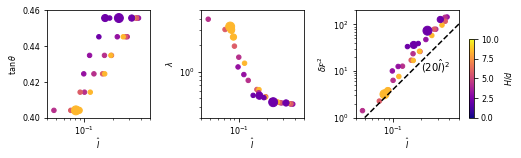

In [14]:
## Produce plots of the bulk inertial number vs. dimensionless parameters
@interact(include_low_frequencies=False, include_experimental_data=False, include_transitional_regime=False)
def plot_dF2(include_low_frequencies, include_experimental_data, include_transitional_regime):
    #fig = plt.figure(figsize=[27 / 2.52, 8 / 2.52])
    fig = plt.figure(figsize=[18 / 2.52, 5 / 2.52])
    # Plot I against channel inclination
    ax_g = fig.add_axes([0.08, 0.225, 0.2, 0.75], xscale='log',
                        xlim=[0.04, 0.5], ylim=[0.40, 0.46],
                        yticks=[0.40, 0.42, 0.44, 0.46])
    sc = ax_g.scatter(data.loc['steady'].I_hat, data.loc['steady'].grad,
                      marker='o', s=0.2*data.loc['steady'].A,
                      c=data.loc['steady'].H, cmap='plasma', vmin=0, vmax=10)
    # Label axes
    ax_g.set_xlabel(r'$\hat{I}$', fontsize=8)
    ax_g.xaxis.set_label_coords(0.5, -0.175)
    ax_g.set_ylabel(r'$\tan \theta$', fontsize=8)
    ax_g.tick_params(axis='both', which='both', labelsize=8)

    # Plot I against lambda
    ax_lambda = fig.add_axes([0.38, 0.225, 0.2, 0.75],
                             xscale='log', yscale='log',
                             xlim=[0.04, 0.5], ylim=[0.3, 5])
    ax_lambda.scatter(data.loc['steady'].I_hat, data.loc['steady'].l_d,
                      marker='o', s=0.2*data.loc['steady'].A,
                      c=data.loc['steady'].H, cmap='plasma', vmin=0, vmax=10)
    # Label axes
    ax_lambda.set_xlabel(r'$\hat{I}$', fontsize=8)
    ax_lambda.xaxis.set_label_coords(0.5, -0.175)
    ax_lambda.set_ylabel(r'$\lambda$', fontsize=8)
    ax_lambda.tick_params(axis='both', which='both', labelsize=8)
    
    # Calculate ratio DF2 of mean square fluctuating force to squared mean force
    if include_low_frequencies:
        DF2 = (2 * data.A * data.dF2 / data.F_n**2)
    else:
        DF2 = (2 * data.A * data.P_F0 * data.f_c / data.F_n**2)
        
    # Plot I against DF2
    ax_dF = fig.add_axes([0.68, 0.225, 0.2, 0.75],
                         xscale='log', yscale='log',
                         xlim=[0.04, 0.5], ylim=[1, 200])
    ax_dF.scatter(data.loc['steady'].I_hat, DF2.loc['steady'],
                  marker='o', s=0.2*data.loc['steady'].A,
                  c=data.loc['steady'].H, cmap='plasma', vmin=0, vmax=10)
    ax_dF.plot([0.05, 5], [1, 1e4], '--k')
    ax_dF.text(0.2, 10, r'$(20\hat{I})^2$')
    # Label axes
    ax_dF.set_xlabel(r'$\hat{I}$', fontsize=8)
    ax_dF.xaxis.set_label_coords(0.5, -0.175)
    ax_dF.set_ylabel(r'$\delta \mathcal{F}^2$', fontsize=8)
    ax_dF.tick_params(axis='both', which='both', labelsize=8)

    #cax = fig.add_axes([0.92, 0.225, 0.01, 0.55])
    cax = fig.add_axes([0.9, 0.225, 0.01, 0.55])
    cbar = fig.colorbar(sc, cax=cax)
    cbar.set_label(r'$H / d$', fontsize=8)
    cax.tick_params(labelsize=8)
    
    if include_experimental_data:
        I_hat = (2.5 * d * exp_data.u_bar
                 / (exp_data.h * np.sqrt(exp_data.phi * g * np.cos(exp_data.th) * exp_data.h)))
        ax_g.scatter(I_hat[exp_data.dense], exp_data.Gradient[exp_data.dense], marker='s', s=20,
                     c=exp_data.m[exp_data.dense] / (rho * d), cmap='plasma', vmin=0, vmax=10)
        ax_g.set_ylim([0.4, 0.55])
        ax_g.set_yticks([0.4, 0.44, 0.48, 0.52])
        
        DF2 = (2 * exp_data.A / d**2 * exp_data.P_F0 * exp_data.f_c / exp_data.F_n**2)
        ax_dF.scatter(I_hat[exp_data.dense], DF2[exp_data.dense], marker='s', s=20,
                      c=exp_data.m[exp_data.dense] / (rho * d), cmap='plasma', vmin=0, vmax=10)
        if include_transitional_regime:
            sc_t = ax_g.scatter(I_hat[exp_data.trans], exp_data.Gradient[exp_data.trans], marker='s', s=20,
                                c=exp_data.m[exp_data.trans] / (rho * d), cmap='plasma', vmin=0, vmax=10)
            ax_g.set_xlim([0.04, 6])
            
            ax_lambda.set_xlim([0.04, 6])
            
            sc_t = ax_dF.scatter(I_hat[exp_data.trans], DF2[exp_data.trans], marker='s', s=20,
                                 c=exp_data.m[exp_data.trans] / (rho * d), cmap='plasma', vmin=0, vmax=10)
            ax_dF.set_xlim([0.04, 6])
            ax_dF.set_ylim([1, 1e5])
        else:
            ax_g.set_xlim([0.04, 2])
            ax_lambda.set_xlim([0.04, 2])
            ax_dF.set_xlim([0.04, 2])
            ax_dF.set_ylim([1, 1e4])

    plt.show()

In [15]:
# Plot Figure for publication, of the relation to the bulk inertial number of:
# - the simulation slope gradient
# - the contact network's base-normal decay length
# - the non-dimensionalised magnitude of fluctuating forces

import statsmodels.api as sm
from matplotlib.lines import Line2D

labels = ['a', 'b', 'c']
x_positions = [0.58, 0.12]

fig = plt.figure(figsize=[15 / 2.52, 5 / 2.52])
Ilim = np.array([0.04, 2])

# Calculate experimental bulk inertial numbers
I_hat_exp = (2.5 * d * exp_data.u_bar
             / (exp_data.h * np.sqrt(exp_data.phi * g * np.cos(exp_data.th) * exp_data.h)))

# Plot I against channel inclination
ax_g = fig.add_axes([0.1, 0.225, 0.2, 0.7], xscale='log')
sc_g_exp = ax_g.scatter(I_hat_exp[exp_data.dense], exp_data.Gradient[exp_data.dense],
                        marker='$\u25EF$', s=20, cmap='plasma', vmin=0, vmax=16,
                        c=exp_data.m[exp_data.dense] * 6 / (np.pi * rho * d))
#sc_g_exp.set_facecolor("none")
sc_g = ax_g.scatter(data.loc['steady'].I_hat, data.loc['steady'].grad,
                    marker='o', s=0.2*data.loc['steady'].A,
                    c=data.loc['steady'].nz, cmap='plasma', vmin=0, vmax=16)

# Label axes
ax_g.set_xlabel(r'$\hat{I}$', fontsize=8)
ax_g.xaxis.set_label_coords(0.5, -0.175)
ax_g.set_ylabel(r'$\tan \theta$', fontsize=8)
ax_g.tick_params(axis='both', which='both', labelsize=8)

# Add a legend for marker type
fig.legend(handles = [Line2D([], [], marker='o', color='k', markersize=5,
                             linestyle='None', label='Simulation'),
                      Line2D([], [], marker='$\u25EF$', color='k', markersize=5,
                             linestyle='None', label='Experiment')],
           loc=[0.085, 0.75], fontsize=8, frameon=False, handletextpad=-0.2)

# Plot I against lambda
ax_lambda = fig.add_axes([0.4, 0.225, 0.2, 0.7],
                         xscale='log', yscale='log')
sc_l = ax_lambda.scatter(data.loc['steady'].I_hat, data.loc['steady'].l_d,
                         marker='o', s=0.2*data.loc['steady'].A,
                         c=data.loc['steady'].nz, cmap='plasma', vmin=0, vmax=16)
# Label axes
ax_lambda.set_xlabel(r'$\hat{I}$', fontsize=8)
ax_lambda.xaxis.set_label_coords(0.5, -0.175)
ax_lambda.set_ylabel(r'$\lambda$', fontsize=8)
ax_lambda.tick_params(axis='both', which='both', labelsize=8)

# Add a legend for element size
handles, labels = sc_l.legend_elements(prop="sizes", func=lambda s:5 * s)
fig.legend(handles, labels, loc=[0.5, 0.5], fontsize=8, frameon=False,
           title = r'$A/d^2$', title_fontsize = 8)
#fig.text(0.55, 0.85, r'$A/d^2$', fontsize=8)

# Calculate ratio DF2 of mean square fluctuating force to squared mean force
DF2 = (2 * data.A * data.P_F0 * data.f_c / data.F_n**2)
DF2_exp = (2 * exp_data.A / d**2 * exp_data.P_F0 * exp_data.f_c / exp_data.F_n**2)

# Fit power law to simulation data
DF2_model = sm.OLS(np.log(DF2.loc['steady']),
                   sm.add_constant(np.log(data.loc['steady'].I_hat)))
results = DF2_model.fit()
constant, exponent = np.exp(results.params[0]), results.params[1]
approx_constant = round(constant, int(1 - np.log10(constant)))
print(f'$\delta \mathcal{{F}}^2 \approx {constant}\hat{{I}}^{exponent:.1f}$')
print('  Error factor {}'.format(np.exp(np.sqrt(np.mean(results.resid**2)))))

# Plot I against DF2
ax_dF = fig.add_axes([0.7, 0.225, 0.2, 0.7],
                     xscale='log', yscale='log',
                     xlim=Ilim, ylim=[1, 200])
sc_DF_exp = ax_dF.scatter(I_hat_exp[exp_data.dense], DF2_exp[exp_data.dense],
                          marker='$\u25EF$', s=20,
                          c=exp_data.m[exp_data.dense] * 6 / (np.pi * rho * d),
                          cmap='plasma', vmin=0, vmax=16)
#DF_exp.set_facecolor("none")
sc_DF = ax_dF.scatter(data.loc['steady'].I_hat, DF2.loc['steady'],
                      marker='o', s=0.2*data.loc['steady'].A,
                      c=data.loc['steady'].nz, cmap='plasma', vmin=0, vmax=16)
ax_dF.plot(Ilim, constant * Ilim**exponent, '--k')
ax_dF.text(0.3, 20, rf'${approx_constant:.0f}\hat{{I}}^{{{exponent:.1f}}}$',
           fontsize = 8)
# Label axes
ax_dF.set_xlabel(r'$\hat{I}$', fontsize=8)
ax_dF.xaxis.set_label_coords(0.5, -0.175)
ax_dF.set_ylabel(r'$\delta \mathcal{F}^2$', fontsize=8)
ax_dF.tick_params(axis='both', which='both', labelsize=8)

cax = fig.add_axes([0.92, 0.225, 0.01, 0.55])
cbar = fig.colorbar(sc_DF, cax=cax)
cbar.set_label(r'$n_z$', fontsize=8)
cax.tick_params(labelsize=8)

ax_g.set_ylim([0.4, 0.55])
ax_g.set_yticks([0.4, 0.44, 0.48, 0.52])

ax_g.set_xlim(Ilim)
ax_lambda.set_xlim(Ilim)
ax_dF.set_xlim(Ilim)
ax_dF.set_ylim([1, 1e4])

plt.savefig(figure_folder + 'I_hat.pdf')
plt.close()

$\delta \mathcal{F}^2 pprox 1722.5378132471478\hat{I}^2.4$
  Error factor 1.3104503608041769


## 4. Analysis

### 4.1. Comparison of existing models

We compare the extracted values of $P_F^0$ and $f_c$ to the predictions of existing models, as described in section 2.3 of [Arran et al. (2021)](https://doi.org/10.1029/2021JF006172), but now with $\bar{u} = q/H$ and with the base-normal profiles of $u$ and $T$ calculated as described above rather than from particle tracking at an experimental channel wall. Below, we list the model parameters that result in the best-fit predictions for $P_F^0$, in a logarithmic least-squares sense, along with the geometric standard error $\epsilon$ those best-fit predictions.

| Model               | Equation | Best-fit parameter | $\epsilon$ |
|---------------------|----------|--------------------|------------|
| [Kean et al. (2015)](https://doi.org/10.1002/2015GL064811)  |          | $K = 0.015d^5 / g$ |         3.6|
| [Lai et al. (2018)](https://doi.org/10.1029/2018GL077683)   |          | n/a                |         8.7|
| [Farin et al. (2019)](https://doi.org/10.1002/esp.4677) |          |                    |            |
| 'thick-flow'        |          | $\nu = 21$         |         1.7|
| 'thin-flow'         |          | $\nu = 1.1$        |         4.6|
| [Bachelet et al.](https://doi.org/10.1029/2022JF006990)     |          | $\gamma = 0 / d$   |         1.9|

Unlike in experiments, [Farin et al. (2019)](https://doi.org/10.1002/esp.4677)'s thin-flow model is poor at predicting $P_F^0$. [Farin et al. (2019)](https://doi.org/10.1002/esp.4677)'s 'thick-flow' model makes the most accurate predictions, but only for an unrealistically high value of $\nu$; the above profiles of kinematic properties indicate that the standard deviation of basal particles' velocities is smaller than these velocities' mean, rather than over 20 times larger, and this discrepancy is demonstrated by this model's overestimates of $f_c$.

*For me, this indicates that there was basal slip in experiments, with $\bar{u}$ then the relevant velocity for basal impacts and other impacts less significant. In simulations, where there's no basal slip and hence the basal velocity scales with $\bar{u}/h$, taking this velocity to be relevant does indeed lead to a better data collapse. On the other hand, there's clearly an issue with at least the prefactor of the Farin et al. (2019) 'thick-flow' model.*

Analysing steady flows...

Fitting Kean (2015) model:
  Best fit: prefactor K = 1.5e-02 d^5 / g
Fitting Farin (2019) thick-flow model:
  Best fit for P_F0: du/u_x = 2.0e+01
Fitting Farin (2019) thin-flow model:
  Best fit for P_F0: du/u_x = 1.1e+00
Fitting Bachelet (2019) model, with gamma
  Best fit: gamma = 1.4e-13 / d
Geometric standard errors:
[3.6072660890166586, 9.008087297494352, 1.6588235720491533, 4.602966560567396, 1.877852072057968]
Akaike information criteria:
[102.08604674 132.39253437  46.27607856 112.52286389  59.42643162]
Akaike Information Criterion minimised by the Farin et al. (2019): `thick-flow' model
Relative probabilities of minimising information loss:
[7.60360231e-13 1.99548846e-19 1.00000000e+00 4.11806639e-15
 1.39455971e-03]


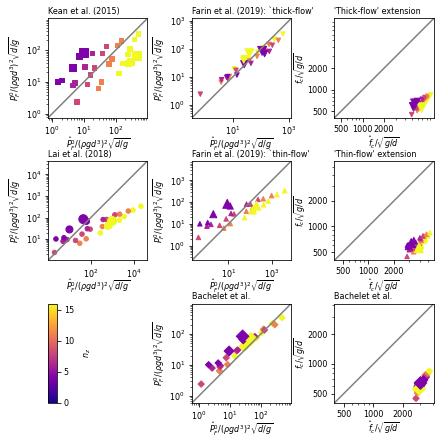

In [16]:
from scipy.optimize import least_squares
from matplotlib.ticker import ScalarFormatter, NullFormatter

data['phi'] = data.H / data.h
data['u_bar'] = data.q / data.H

## Functions to calculate predictions of existing models
def Kean_model(indices=data.index, K=1, fit=False):
    ## Kean et al. (2015): uses model of Tsai et al. (2012) with
    ##     u ~ u(h) (so ~ u_bar), Delta p ~ F_z
    pP_F0 = (data.loc[indices].A * data.loc[indices].u_bar
             * (data.loc[indices].F_n / data.loc[indices].A)**2)
    if (fit == True):
        print('Fitting Kean (2015) model:')
        # Calculate log least squares fit for free parameter K
        K = np.exp(np.log(data.loc[indices].P_F0 / pP_F0).mean())
        print('  Best fit: prefactor K = {:.1e} d^5 / g'.format(K))
    # Return predictions for P_F0
    output = pd.DataFrame({'P_F0': K * pP_F0}, index=data.loc[indices].index)
    return output

def Lai_model(indices=data.index):
    ## Lai et al. (2018): uses model of Tsai et al. (2012) with
    ##     u = u_bar, Delta p = 2 m u_bar
    P_F0 = 4 * m**2 * data.loc[indices].A * data.loc[indices].u_bar**3
    f_c = hertz_f_c / tau(data.loc[indices].u_bar)
    output = pd.DataFrame({'P_F0': P_F0, 'f_c': f_c}, index=data.loc[indices].index)
    # Return predictions for P_F0 and f_c
    return output

def Farin_fz2(du):
    ## Farin et al. (2019)'s prefactor for P_F, for varying impact geometry
    return 0.23**2 * (1 + du**2 / 0.18)

def Farin_factors(du):
    ## Expansion of Farin et al. (2019)'s model to P_F0, f_c prefactors
    # Simulate N impacts, to calc. P_F at non-dim frequencies freq_hat
    N = 10000
    freq_hat = hertz_f_c * 2**np.arange(-1, 2 + 0.2 * np.log2(1 + du), 0.05)
    # Polar and azimuthal angles for impact velocities and impact locations
    alpha = np.pi/6 * np.random.random(N)
    psi = np.pi * np.random.random(N)
    alphaT = 2 * np.pi * np.random.random(N)
    psiT = 2 * np.pi * np.random.random(N)
    # Normal impact velocities
    un = ((1 + du * np.sin(psi) * np.cos(psiT))
          * np.sin(alpha) * np.cos(alphaT)
          + du * np.sin(psi) * np.sin(psiT) * np.sin(alpha) * np.sin(alphaT)
          + du * np.cos(psi) * np.cos(alpha))
    # Squared vertical impulses
    Iz2 = (un * np.cos(alpha))**2
    # Mean power spectrum of vertical force
    P_F_hat = np.array([((Iz2 * zeta(f_hat * np.abs(un)**-0.2)
                          * np.sin(alpha) * np.sin(psi))[un > 0].sum()
                         / (np.sin(alpha) * np.sin(psi))[un > 0].sum())
                        for f_hat in freq_hat])
    # Calculate the implied non-dimensional prefactors for P_F0 and f_c
    fid_c_hat = np.argmax(P_F_hat[:-20] > 10 * P_F_hat[20:])
    P_F0_hat, f_c_hat = P_F_hat[fid_c_hat] / zeta_f_c, freq_hat[fid_c_hat]
    return np.array([P_F0_hat, f_c_hat])

def Farin_thin_model(indices=data.index, du=1, e=0.9, fit=False):
    ##    Farin et al. (2019) 'thin flow': uses model of Tsai et al. (2012)
    ##        with u = u_bar, Delta p = (1 + e) * m * u * fz(du)
    pP_F0 = (data.loc[indices].A * data.loc[indices].phi
             * (1 + e)**2 * m**2 * data.loc[indices].u_bar**3)
    pf_c = 1 / tau(data.loc[indices].u_bar)
    # log ratio between P_F0 data and predictions for prefactor equal to 1
    logA = np.log(data.loc[indices].P_F0 / pP_F0)
    
    if (fit == True):
        print('Fitting Farin (2019) thin-flow model:')
        # Calculate log least squares fit of P_F(0) for du
        sid_use = np.isfinite(logA)
        du = least_squares(lambda du:(np.log(Farin_fz2(du)) - logA)[sid_use],
                           1, method='lm', xtol=5e-2).x[0]
        print('  Best fit for P_F0: du/u_x = {:.1e}'.format(du))
    # Calculate the corresponding prefactors for P_F0 and f_c
    P_F0_hat, f_c_hat = Farin_factors(du)
    # Return predictions for P_F0 and f_c
    output = pd.DataFrame({'P_F0': P_F0_hat * pP_F0, 'f_c': f_c_hat * pf_c},
                          index=data.loc[indices].index)
    return output

def Farin_thick_model(indices=data.index, chi=1.25, du=1, e=0.9, fit=False):
    ##    Farin et al. (2019) 'thin flow': uses model of Tsai et al. (2012)
    ##        with u = p u d / h, Delta p = (1 + e) * m * u * fz(du)
    pP_F0 = (data.loc[indices].A * data.loc[indices].phi * (1 + e)**2 * m**2
             * (chi * data.loc[indices].u_bar / data.loc[indices].h)**3)
    pf_c = 1 / tau(data.loc[indices].u_bar)
    # log ratio between P_F0 data and predictions for prefactor equal to 1
    logA = np.log(data.loc[indices].P_F0 / pP_F0)
    
    if (fit == True):
        print('Fitting Farin (2019) thick-flow model:')
        # Calculate log least squares fit of P_F(0) for du
        sid_use = np.isfinite(logA)
        du = least_squares(lambda du:(np.log(Farin_fz2(du)) - logA)[sid_use],
                           1, method='lm', xtol=5e-2).x[0]
        print('  Best fit for P_F0: du/u_x = {:.1e}'.format(du))
    # Calculate the corresponding prefactors for P_F0 and f_c
    P_F0_hat, f_c_hat = Farin_factors(du)
    # Return predictions for P_F0 and f_c
    output = pd.DataFrame({'P_F0': P_F0_hat * pP_F0, 'f_c': f_c_hat * pf_c},
                          index=data.loc[indices].index)
    return output

def Bachelet_P_F0(indices=data.index, gamma=5):
    ##    Bachelet (2018) model for P_F0, with full-depth contributions
    ##        with n_I = 4 phi du/dz / pi d^3, Delta p = 2 * m * sqrt(T),
    ##        and exponential attenuation exp(-gamma z)
    output = []
    # For each experiment's index, volume fraction, and channel-wall profiles,
    for index, sim in data.loc[indices].iterrows():
        if np.isfinite(sim.h):
            # ... find the indices corresponding to positions within the flow
            id_use = (0 <= sim.pf_k['z']) & (sim.pf_k['z'] <= sim.h)
            # ... and integrate contributions with depth
            # (while accounting for Bachelet's use of Var(\mathbf{u}) = 3T),
            P_F0 = (48 / np.pi * m**2 * sim.A * sim.phi
                    * (sim.pf_k['u'].diff().shift(-1) * sim.pf_k['T']
                       * np.exp(-gamma * sim.pf_k['z']))[id_use].sum())
            output.append(pd.Series({'P_F0': P_F0}, name=index))
        else:
            output.append(pd.Series({'P_F0': np.nan}, name=index))
    # Return predictions for P_F0
    return pd.DataFrame(output)

def Bachelet_model(indices=data.index, gamma=5, fit=False):
    ##    Bachelet (2018) model for P_F0, f_c, with full-depth contributions
    ##        with n_I = 4 phi du/dz / pi d^3, Delta p = 2 * m * sqrt(T),
    ##        and exponential attenuation exp(-gamma z)
    if (fit == True):
        print('Fitting Bachelet (2019) model, with gamma')
        # Calculate log least squares fit of P_F(0) for gamma
        sid_use = np.isfinite(data.loc[indices].P_F0)
        gamma = least_squares(lambda gamma: np.log(Bachelet_P_F0(indices, gamma).P_F0
                                                   / data.loc[indices].P_F0)[sid_use],
                              x0=5, bounds=(0, np.inf), xtol=0.001).x[0]
        print('  Best fit: gamma = {:.1e} / d'.format(gamma))
    # Calculate the corresponding predictions for P_F0 and f_c, by,
    freq = hertz_f_c / tau(1) * 2**np.arange(-2, 3, 0.05)
    output = []
    # for each experiment's index, volume fraction, and channel-wall profiles,
    for index, sim in data.loc[indices].iterrows():
        if np.isfinite(sim.h):
            # ... find the indices corresponding to positions within the flow
            id_use = (0 <= sim.pf_k['z']) & (sim.pf_k['z'] <= sim.h)
            # ... integrating contributions with depth at each frequency
            # (while accounting for Bachelet's use of Var(\mathbf{u}) = 3T),
            P_F = (48 / np.pi * m**2 * sim.A * sim.phi
                   * np.array([(sim.pf_k['u'].diff().shift(-1)
                                * sim.pf_k['T'] * np.exp(-gamma * sim.pf_k['z'])
                                * zeta(f * tau(np.sqrt(3 * sim.pf_k['T']))) )[id_use]
                               .sum() for f in freq]))
            # ... and extracting corner frequency f_c, power spectral density P_F0
            fid_c = np.argmax(P_F[:-20] > 10 * P_F[20:])
            P_F0, f_c = P_F[fid_c] / zeta_f_c, freq[fid_c]
            output.append(pd.Series({'P_F0': P_F0, 'f_c': f_c}, name=index))
        else:
            output.append(pd.Series({'P_F0': np.nan, 'f_c': np.nan}, name=index))
    # Return predictions for P_F0 and f_c
    return pd.DataFrame(output)

## Compare the predictions of the existing models
# Existing model names
e_models = ['Kean et al. (2015)', 'Lai et al. (2018)',
            'Farin et al. (2019): `thick-flow\'',
            'Farin et al. (2019): `thin-flow\'',
            'Bachelet et al.']
e_fc_models = [None, None,
               "'Thick-flow' extension",
               "'Thin-flow' extension",
               "Bachelet et al."]
# Number of fitting parameters and their names
e_n_param = [1, 0, 1, 1, 1]
# Axes positions within figure
pos = [[0.099, 0.74],
       [0.099, 0.41],
       [0.432, 0.74],
       [0.432, 0.41],
       [0.432, 0.08]]
# Markers within figure
e_markers = ['s', 'o', 'v', '^', 'D']

for mode in ['steady']:
    print(f'Analysing {mode} flows...')
    print()
    # Extract predictions, using above functions
    e_predictions = [Kean_model(indices=mode, fit=True),
                     Lai_model(indices=mode),
                     Farin_thick_model(indices=mode, chi=1.25, e=0.9, fit=True),
                     Farin_thin_model(indices=mode, e=0.9, fit=True),
                     Bachelet_model(indices=mode, fit=True)]
    # Calculate geometric standard error
    epsilon = [np.exp(np.sqrt(np.mean(np.log(data.loc[mode].P_F0 / pred.P_F0)**2)))
               for pred in e_predictions]
    print('Geometric standard errors:')
    print(epsilon)
    # Calculate Akaike Information criterion (up to a constant)
    AIC = np.array([2 * k + data.loc[mode].shape[0]
                    * (1 + np.log(2 * np.pi * np.mean(np.log(data.loc[mode].P_F0
                                                             / pred.P_F0)**2)))
                    for k, pred in zip(e_n_param, e_predictions)])
    print('Akaike information criteria:')
    print(AIC)
    # Calculate the implied probabilities of minimising information loss
    rel_p_min = np.exp(0.5 * (AIC.min() - AIC))
    print('Akaike Information Criterion minimised by the {} model'
          .format(e_models[np.argmin(AIC)]))
    print('Relative probabilities of minimising information loss:')
    print(rel_p_min)
    # Set up figure comparing models
    obs_PF0_range = [0.5 * data.loc[mode].P_F0.min(),
                     2 * data.loc[mode].P_F0.max()]
    obs_fc_range = [0.9 * data.loc[mode].f_c.min(),
                    1.1 * data.loc[mode].f_c.max()]
    fig = plt.figure(figsize=[6, 6])
    # Iterate over the models
    for m_id in range(len(e_models)):
        # Set up new axes for the power spectral density P_F0
        thy_PF0_range = [0.5 * e_predictions[m_id].P_F0.min(),
                         2 * e_predictions[m_id].P_F0.max()]
        PF0_range = [min(obs_PF0_range[0], thy_PF0_range[0]),
                     max(obs_PF0_range[1], thy_PF0_range[1])]
        ax1 = fig.add_axes([pos[m_id][0], pos[m_id][1], 0.23, 0.23],
                            xscale='log', yscale='log',
                            xlim=PF0_range, ylim=PF0_range)
        # Plot perfect agreement for P_F0
        ax1.plot(PF0_range, PF0_range, color=[0.5, 0.5, 0.5])
        # Plot predictions for P_F0 against observations
        sc = ax1.scatter(e_predictions[m_id].P_F0, data.loc[mode].P_F0,
                         marker=e_markers[m_id], s=0.2*data.loc[mode].A,
                         c=data.loc[mode].nz, cmap='plasma', vmin=0, vmax=16)
        # Label axes
        ax1.set_xlabel(r'$\hat{P}_F^0 / (\rho g d^3)^2 \sqrt{d/g}$', fontsize=8)
        ax1.xaxis.set_label_coords(0.5, -0.17)
        ax1.set_ylabel(r'$P_F^0 / (\rho g d^3)^2 \sqrt{d/g}$', fontsize=8)
        ax1.yaxis.set_label_coords(-0.25, 0.5)
        ax1.tick_params(axis='both', labelsize=8)
        # Add a title
        fig.text(pos[m_id][0], pos[m_id][1]+0.24,
                 e_models[m_id], fontsize=8)
        # If the model makes a prediction for the corner frequency
        if (e_fc_models[m_id]):
            # set up new axes for the corner frequency f_c,
            thy_fc_range = [0.9 * e_predictions[m_id].f_c.min(),
                            1.11 * e_predictions[m_id].f_c.max()]
            fc_range = np.array([min(obs_fc_range[0], thy_fc_range[0]),
                                 max(obs_fc_range[1], thy_fc_range[1])])
            ticks = ([500, 1000, 2000] if fc_range[1] > 2000 else
                     [600, 800, 1000] if fc_range[1] > 1000 else
                     [500, 700, 900])
            ax2 = fig.add_axes([pos[m_id][0]+0.33, pos[m_id][1], 0.23, 0.23],
                                xscale='log', yscale='log',
                                xticks=ticks, yticks=ticks,
                                xlim=fc_range, ylim=fc_range)
            # plot perfect agreement for f_c,
            ax2.plot(fc_range, fc_range, color=[0.5, 0.5, 0.5])
            # plot predictions for f_c against observations,
            ax2.scatter(e_predictions[m_id].f_c, data.loc[mode].f_c,
                        marker=e_markers[m_id], s=0.2*data.loc[mode].A,
                        c=data.loc[mode].nz, cmap='plasma', vmin=0, vmax=16)
            # label axes,
            ax2.set_xlabel(r'$\hat{f}_c / \sqrt{g/d}$', fontsize=8)
            ax2.xaxis.set_label_coords(0.5, -0.17)
            ax2.xaxis.set_major_formatter(ScalarFormatter())
            ax2.xaxis.set_minor_formatter(NullFormatter())
            ax2.set_ylabel(r'$f_c / \sqrt{g/d}$', fontsize=8)
            ax2.yaxis.set_label_coords(-0.27, 0.5)
            ax2.yaxis.set_major_formatter(ScalarFormatter())
            ax2.yaxis.set_minor_formatter(NullFormatter())
            ax2.tick_params(axis='both', which='both', labelsize=8)
            # and add a title,
            fig.text(pos[m_id][0]+0.33, pos[m_id][1]+0.24,
                     e_fc_models[m_id], fontsize=8)
    # Add a colorbar
    ax_c = fig.add_axes([0.099, 0.08, 0.02, 0.23])
    fig.colorbar(sc, ax_c)
    ax_c.set_ylabel(r'$n_z$', fontsize=8)
    ax_c.yaxis.set_label_coords(4, 0.5)
    ax_c.tick_params(labelsize=8)
    plt.show()

### 4.2. Comparison of predictions derived from collisional properties

Given the limitations of existing models, we derive a new model linking the properties of the flow to those of its seismic signal. Supposing that the high-frequency signal is generated by the uncorrelated normal components of the forces exerted during elastic, Hertzian collisions of individual particles, the total power spectral density of the basal force will be
$$
\hat{P}_F(f) = \frac{1}{\Delta t} \sum_j (2 m v_{n, j})^2 \zeta(f \tau(v_{n, j})) \iota_j \xi(f)^{\frac{z_j}{d}},
$$
where $v_{n, j}$ and $z_j$ are the normal relative velocity and base-normal position of the $j$th collision during a time interval $\Delta t$, $\iota_j$ is a binary variable indicating whether the force exerted during this collision is transmitted to the base via a network of connected particles, and $\xi$ is the fraction of the spectral power transmitted a distance $d$ towards the base via this network.

To relate this expression to the profiles of collisional properties, we first suppose that, over collisions with contact point at a base-normal position $z$, the proportion for which force is transmitted to the base is equal to the proportion of impacted particles that are connected to the base by a force chain. We further suppose that the attenuation of spectral power is purely geometric, due to the altitudinal deviation $\psi$ of one contact's normal from the normal of that below it (see schematic below). Assuming that, for a given contact, the contact distributing force onwards is equally likely to be anywhere in the opposing hemisphere, the fraction of the force's spectral power that will be passed to the next contact is 
$$
\int_0^{\pi / 2} \cos^2 \psi \sin \psi \text{ d} \psi = \frac{1}{3}.
$$
Since the next contact will be, on average, a distance $d/2$ closer to the base, we take $\xi = 1/9$, so that
$$
\hat{P}_F(f) = 4 m^2 A \int_0^\infty 9^{-z/d} n_I \langle v_n^2 \rangle \zeta\left(f \tau\left(\sqrt{\langle v_n^2 \rangle}\right)\right) P_c\left(z - d/4\right) \text{ d}z
$$
where $n_I$(z), $\langle v_n^2 \rangle$(z), and $P_c(z)$ are, as described above, the number of collisions per unit volume and unit time at a base-normal position $z$, the mean squared normal relative velocity of such collisions, and the probability that a particle at a base-normal position $z$ is connected to the base via a chain of particles in contact.

Comparison of the derived predictions $\hat{P}_F^0$ and $\hat{f}_c$ to the measured values $P_F^0$ and $f_c$, representing spectral amplitude and corner frequency respectively, demonstrates excellent agreement even with no fitting parameters.

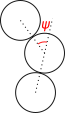

Analysing steady flows...



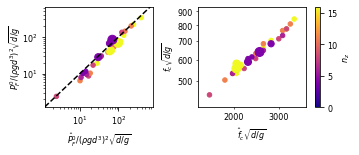

Geometric standard error epsilon = 1.4
Akaike information criterion = 14.2

Geometric error range for f_c: 0.23673496147947695 - 0.28348505755963277


In [17]:
display(Image(filename='./Figures/chain_schematic.png'))

# Function implementing the minimal model
def collision_model(indices=data.index, xi=1./9.):
    ## Calculate predictions for P_F^0, f_c from recorded collision statistics
    ## Assumes force chains transmit forces of elastic Hertzian impacts, with
    ## impact rate f_I, mean square impulse 4m<v_n>^2, transmission prob. P_c
    freq = hertz_f_c / tau(1) * 2**np.arange(-2, 3, 0.05)
    output = []
    # for each experiment's index, volume fraction, and channel-wall profiles,
    for index, sim in data.loc[indices].iterrows():
        if np.isfinite(sim.h):
            offset = int(0.25 / sim.pf_c['z'].diff().mean())
            # ... integrating contributions with depth at each frequency,
            P_F = (4. * sim.A * m**2
                   * np.array([(sim.pf_c['n_I'] * sim.pf_c['P_c'].shift(offset)
                                * sim.pf_c['<v_n^2>'] * xi**sim.pf_c['z']
                                * zeta(f * tau(np.sqrt(sim.pf_c['<v_n^2>'])))
                                * sim.pf_c['z'].diff())[sim.pf_c['z'] >= 0].sum()
                               for f in freq]))
            # ... and extracting corner frequency f_c, power spectral density P_F0
            fid_c = np.argmax(P_F[:-20] > 10 * P_F[20:])
            P_F0, f_c = P_F[fid_c] / zeta_f_c, freq[fid_c]
            output.append(pd.Series({'P_F0': P_F0, 'f_c': f_c}, name=index))
        else:
            output.append(pd.Series({'P_F0': np.nan, 'f_c': np.nan}, name=index))
    return pd.DataFrame(output)

# Function to compare a model's predictions with the results from simulations
def plot_comparison(prediction, indices=data.index):
    Px_range = (0.5 * prediction.P_F0.min(), 2 * prediction.P_F0.max())
    Py_range = (0.5 * data.loc[indices].P_F0.min(),
                2 * data.loc[indices].P_F0.max())
    fx_range = (0.9 * prediction.f_c.min(),
                1.11 * prediction.f_c.max())
    fy_range = (0.9 * data.loc[indices].f_c.min(),
                1.11 * data.loc[indices].f_c.max())

    fig = plt.figure(figsize=[5, 2])
    ax_P_F = fig.add_axes([0.125, 0.25, 0.3, 0.7], xscale='log', yscale='log',
                          xlim=Px_range, ylim=Py_range)
    sc = ax_P_F.scatter(prediction.P_F0, data.loc[indices].P_F0,
                        marker='o', s=0.2*data.loc[indices].A,
                        c=data.loc[indices].nz, cmap='plasma', vmin=0, vmax=16)
    ax_P_F.plot(Px_range, Px_range, '--k')
    ax_P_F.tick_params(axis='both', which='both', labelsize=8)
    ax_P_F.set_xlabel(r'$\hat{P}_F^0 / (\rho g d^3)^2 \sqrt{d/g}$', fontsize=8)
    ax_P_F.set_ylabel(r'$P_F^0 / (\rho g d^3)^2 \sqrt{d/g}$', fontsize=8)
    ax_P_F.yaxis.set_label_coords(-0.2, 0.5)
    ax_f_c = fig.add_axes([0.55, 0.25, 0.3, 0.7], xscale='log', yscale='log',
                          xlim=fx_range, ylim=fy_range)
    ax_f_c.scatter(prediction.f_c, data.loc[indices].f_c,
                   marker='o', s=0.2*data.loc[indices].A,
                   c=data.loc[indices].nz, cmap='plasma', vmin=0, vmax=16)
    ax_f_c.plot(fx_range, fx_range, '--k')
    ax_f_c.tick_params(axis='both', which='both', labelsize=8)
    ax_f_c.xaxis.set_major_formatter(ScalarFormatter())
    ax_f_c.xaxis.set_minor_formatter(ScalarFormatter())
    ax_f_c.yaxis.set_major_formatter(ScalarFormatter())
    ax_f_c.yaxis.set_minor_formatter(ScalarFormatter())
    ax_f_c.set_xlabel(r'$\hat{f}_c \sqrt{d/g}$', fontsize=8)
    ax_f_c.set_ylabel(r'$f_c \sqrt{d/g}$', fontsize=8)
    ax_f_c.yaxis.set_label_coords(-0.2, 0.5)

    ax_c = fig.add_axes([0.875, 0.25, 0.015, 0.7])
    cbar = fig.colorbar(sc, cax=ax_c)
    cbar.set_label(r'$n_z$', fontsize=8)
    ax_c.tick_params(labelsize=8)
    plt.show()

# Compare the minimal model with observations
for mode in ['steady']:
    print(f'Analysing {mode} flows...')
    print()
    c_prediction = collision_model(mode, 1./9.)
    plot_comparison(c_prediction, mode)
    # Calculate geometric standard error
    sigma2 = np.mean(np.log(data.loc[mode].P_F0 / c_prediction.P_F0)**2)
    epsilon = np.exp(np.sqrt(sigma2))
    print('Geometric standard error epsilon = {:.1f}'.format(epsilon))
    # Calculate Akaike Information criterion (up to a constant)
    AIC = data.loc[mode].shape[0] * (1 + np.log(2 * np.pi * sigma2))
    print('Akaike information criterion = {:.1f}'.format(AIC))
    print()
    log_error = np.log(data.loc[mode].f_c / c_prediction.f_c)
    print('Geometric error range for f_c: {} - {}'.format(np.exp(log_error.min()), np.exp(log_error.max())))

In [18]:
# Plot Figure for publication, comparing predictions for the high-frequency signal with observations 

fig = plt.figure(figsize=[6, 8])

# Model names
models = e_models + ['Minimal model']
fc_models = e_fc_models + ['Minimal model']
# Axes positions within figure
pos = [[0.095, 0.80],
       [0.095, 0.55],
       [0.428, 0.80],
       [0.428, 0.55],
       [0.428, 0.30],
       [0.428, 0.05],
       [0.095, 0.30],
       [0.095, 0.05]]
# Markers within figure
markers = e_markers + ['*']
# Model predictions
predictions = e_predictions + [c_prediction]

# Iterate over the models
sc = []
for m_id in range(len(models)):
    # Set up new axes for the power spectral density P_F0
    thy_PF0_range = [0.5 * predictions[m_id].P_F0.min(),
                     2 * predictions[m_id].P_F0.max()]
    PF0_range = [min(obs_PF0_range[0], thy_PF0_range[0]),
                 max(obs_PF0_range[1], thy_PF0_range[1])]
    ax1 = fig.add_axes([pos[m_id][0], pos[m_id][1], 0.23, 0.1725],
                        xscale='log', yscale='log',
                        xlim=PF0_range, ylim=PF0_range)
    # Plot perfect agreement for P_F0
    ax1.plot(PF0_range, PF0_range, color=[0.5, 0.5, 0.5])
    # Plot predictions for P_F0 against observations
    sc.append(ax1.scatter(predictions[m_id].P_F0, data.loc[mode].P_F0,
                          marker=markers[m_id], s=0.2*data.loc[mode].A,
                          c=data.loc[mode].nz, cmap='plasma', vmin=0, vmax=16))
    # Label axes
    ax1.set_xlabel(r'$\hat{P}_F^0 / (\rho g d^3)^2 \sqrt{d/g}$', fontsize=8)
    ax1.xaxis.set_label_coords(0.5, -0.17)
    ax1.set_ylabel(r'$P_F^0 / (\rho g d^3)^2 \sqrt{d/g}$', fontsize=8)
    ax1.yaxis.set_label_coords(-0.25, 0.5)
    ax1.tick_params(axis='both', labelsize=8)
    # Add a title
    fig.text(pos[m_id][0], pos[m_id][1]+0.18,
             models[m_id], fontsize=8)
    # If the model makes a prediction for the corner frequency
    if (fc_models[m_id]):
        # set up new axes for the corner frequency f_c,
        thy_fc_range = [0.9 * predictions[m_id].f_c.min(),
                        1.11 * predictions[m_id].f_c.max()]
        fc_range = np.array([min(obs_fc_range[0], thy_fc_range[0]),
                             max(obs_fc_range[1], thy_fc_range[1])])
        ticks = ([500, 1000, 2000] if fc_range[1] > 2000 else
                 [600, 800, 1000] if fc_range[1] > 1000 else
                 [500, 700, 900] if fc_range[0] > 400 else
                 [400, 600, 800])
        ax2 = fig.add_axes([pos[m_id][0]+0.33, pos[m_id][1], 0.23, 0.1725],
                           xscale='log', yscale='log',
                           xticks=ticks, yticks=ticks,
                           xlim=fc_range, ylim=fc_range)
        # plot perfect agreement for f_c,
        ax2.plot(fc_range, fc_range, color=[0.5, 0.5, 0.5])
        # plot predictions for f_c against observations,
        ax2.scatter(predictions[m_id].f_c, data.loc[mode].f_c,
                    marker=markers[m_id], s=0.2*data.loc[mode].A,
                    c=data.loc[mode].nz, cmap='plasma', vmin=0, vmax=16)
        # label axes,
        ax2.set_xlabel(r'$\hat{f}_c / \sqrt{g/d}$', fontsize=8)
        ax2.xaxis.set_label_coords(0.5, -0.17)
        ax2.xaxis.set_major_formatter(ScalarFormatter())
        ax2.xaxis.set_minor_formatter(NullFormatter())
        ax2.set_ylabel(r'$f_c / \sqrt{g/d}$', fontsize=8)
        ax2.yaxis.set_label_coords(-0.27, 0.5)
        ax2.yaxis.set_major_formatter(ScalarFormatter())
        ax2.yaxis.set_minor_formatter(NullFormatter())
        ax2.tick_params(axis='both', which='both', labelsize=8)
        # and add a title,
        fig.text(pos[m_id][0]+0.33, pos[m_id][1]+0.18,
                 fc_models[m_id], fontsize=8)
# Add a legend for element size
handles, labels = sc[0].legend_elements(prop="sizes", func=lambda s:5 * s)
fig.legend(handles, labels, loc=pos[-2], title=r"$A/d^2$", fontsize=8, frameon=False)
# Add a colorbar
ax_c = fig.add_axes(pos[-1] + [0.02, 0.1725])
fig.colorbar(sc[0], ax_c)
ax_c.set_ylabel(r'$n_z$', fontsize=8)
ax_c.yaxis.set_label_coords(4, 0.5)
ax_c.tick_params(labelsize=8)

plt.savefig(figure_folder + 'model_comparison.pdf')
plt.close()

### 4.3. Parametrisation of this collisional model

Whilst the above model is extremely successful, it would be impractical to apply it to real flows, for which the profiles of collisional properties $P_c$, $\langle v_n^2 \rangle$, and $n_I$ are unmeasurable. We therefore substitute theoretical models for these profiles into the above expression, to relate the bulk properties of a flow to the properties of its seismic signal.

Working from sections 3.1 and 3.2, we use three models for the profiles of collisional properties, corresponding to the assumption of constant shear, constant inertial number, and known velocity profile, respectively. In the first model, we assume profiles within the bulk of the flow
$$\begin{align}
\hat{P}_c(z) &= e^{-(2z + d) / 2 \lambda d} \\
\langle \hat{v}_n^2 \rangle(z) &= 8 d^2 g_T^2 q^2 / h^4 \\
\hat{n}_I(z) &= \frac{48 gh^2 H \cos\theta}{\pi d^5 g_T q} \left(1 - \hat{P}_c\right)\left(1 - \frac{z}{h}\right),
\end{align}$$
with $\hat{n}_I = 0$ for $z > h$. In this case, we have
$$
\hat{P}_F(f) = \frac{256}{6} \pi \rho^2 g d^3 \bar{\phi} A q g_T \cos\theta I(\lambda, h/d) \zeta(f \tau ),
$$
where $\bar{\phi} = H/h$, $\tau = \left(\frac{m^2 h^2}{2 d g_T k_n^2 q\sqrt{2}}\right)^{1/5}$ and $I$ is an integral that can be expressed in terms of $\alpha = \frac{h}{\lambda d}$, $\beta = 1 + 2\lambda \ln 3$, and $\gamma = e^{-1/4\lambda}$ as
$$\begin{align}
I(\lambda, h/d) &= \gamma \int_0^1 (1 - \eta)\left(1 - \gamma^2 e^{-\alpha \eta}\right) e^{-\alpha \beta\eta }\text{ d}\eta \\
    &= \frac{\gamma}{\alpha\beta} - \frac{\gamma}{\alpha^2\beta^2} \left(1 - e^{-\alpha\beta}\right) - \frac{\gamma^3}{\alpha(1 + \beta)} + \frac{\gamma^3}{\alpha^2(1 + \beta)^2}\left(1 - e^{-\alpha(1 + \beta)}\right).
\end{align}$$

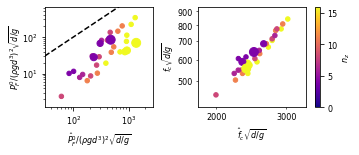

Geometric standard error epsilon = 11.2
Akaike information criterion = 138.1


In [19]:
# Function implementing a parametrisation of the minimal model, working from a linear velocity profile
def shear_kinetic_model(indices=data.index):
    g_T = 0.3 / np.tan(np.pi / 180 * data.loc[indices].th)
    alpha = data.loc[indices].h / data.loc[indices].l_d
    beta = 1 + 2 * data.loc[indices].l_d * np.log(3)
    gamma = np.exp(-0.25 / data.loc[indices].l_d)
    integral = (gamma / (alpha * beta)
                - gamma / (alpha * beta)**2 * (1 - np.exp(-alpha * beta))
                - gamma**3 / (alpha * (1 + beta))
                + gamma**3 / (alpha * (1 + beta))**2 * (1 - np.exp(-alpha * (1 + beta))))
    P_F0 = (256./6. * np.pi * data.loc[indices].phi * data.loc[indices].A
            * data.loc[indices].q * g_T * np.cos(np.pi / 180 * data.loc[indices].th) * integral)
    f_c = hertz_f_c / tau(np.sqrt(8) * data.loc[indices].q * g_T / data.loc[indices].h**2)
    output = pd.DataFrame({'P_F0': P_F0, 'f_c': f_c}, index=data.loc[indices].index)
    # Return predictions for P_F0 and f_c
    return output

prediction = shear_kinetic_model('steady')
plot_comparison(prediction, 'steady')

# Calculate geometric standard error
epsilon = np.exp(np.sqrt(np.mean(np.log(data.loc['steady'].P_F0 / prediction.P_F0)**2)))
print('Geometric standard error epsilon = {:.1f}'.format(epsilon))
# Calculate Akaike Information criterion (up to a constant)
AIC = data.loc['steady'].shape[0] * (1 + np.log(2 * np.pi * np.mean(np.log(data.loc['steady'].P_F0
                                                                           / prediction.P_F0)**2)))
print('Akaike information criterion = {:.1f}'.format(AIC))

In the second model, we assume profiles within the bulk of the flow
$$\begin{align}
\hat{P}_c(z) &= e^{-(2z + d) / 2 \lambda d} \\
\langle \hat{v}_n^2 \rangle(z) &= \frac{25 d^2 q^2 g_T^2}{2 h^2 H^2} \left (1 - \frac{z}{h}\right) \\
\hat{n}_I(z) &= \frac{48 g H^2 h \cos \theta}{5 \pi d^5 q g_T} \left(1 - \hat{P}_c\right)\sqrt{1 - \frac{z}{h}},
\end{align}$$
with $\hat{n}_I = 0$ for $z > h$. In this case, we have
$$
\hat{P}_F(f) = \frac{40}{3} \pi \rho^2 g d^3 A q g_T \cos\theta I_{\zeta}(\lambda, h/d, f),
$$
where
$$\begin{align}
I_{\zeta}(\lambda, h/d, f) &= \gamma \int_0^1 (1 - \eta)^{3/2}\left(1 - \gamma^2 e^{-\alpha \eta}\right) e^{-\alpha \beta\eta } \zeta\left( f \tau \left(\frac{5 d q g_T}{hH}\sqrt{\frac{1 - \eta}{2}}\right)\right) \text{ d}\eta
\end{align}$$

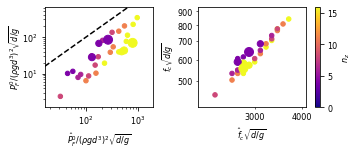

Geometric standard error epsilon = 6.8
Akaike information criterion = 124.0


In [20]:
# Function implementing a parametrisation of the minimal model, working from a Bagnold velocity profile
def Bagnold_kinetic_model(indices=data.index):
    freq = hertz_f_c / tau(1) * 2**np.arange(-2, 3, 0.05)
    eta = pd.Series(np.arange(0, 1, 0.01))
    output = []
    # for each experiment's index, volume fraction, and channel-wall profiles,
    for index, sim in data.loc[indices].iterrows():
        if np.isfinite(sim.h):
            g_T = 0.3 / np.tan(np.pi / 180 * sim.th)
            alpha = sim.h / sim.l_d
            beta = 1 + 2 * sim.l_d * np.log(3)
            gamma = np.exp(-0.25 / sim.l_d)
            # ... integrating contributions with depth at each frequency,
            P_F = (40./3. * np.pi * sim.A * sim.q * g_T * np.cos(np.pi / 180 * sim.th) * gamma
                   * np.array([((1 - eta)**1.5 * (1 - gamma**2 * np.exp(-alpha * eta)) * np.exp(-alpha * beta * eta)
                                * zeta(f * tau(5 * sim.q * g_T * np.sqrt((1 - eta) / 2) / (sim.h * sim.H)))
                                * eta.diff().shift(-1)).sum()
                               for f in freq]))
            # ... and extracting corner frequency f_c, power spectral density P_F0
            fid_c = np.argmax(P_F[:-20] > 10 * P_F[20:])
            P_F0, f_c = P_F[fid_c] / zeta_f_c, freq[fid_c]            
            output.append(pd.Series({'P_F0': P_F0, 'f_c': f_c}, name=index))
        else:
            output.append(pd.Series({'P_F0': np.nan, 'f_c': np.nan}, name=index))
    # Return predictions for P_F0 and f_c
    return pd.DataFrame(output)

prediction = Bagnold_kinetic_model('steady')
plot_comparison(prediction, 'steady')

# Calculate geometric standard error
epsilon = np.exp(np.sqrt(np.mean(np.log(data.loc['steady'].P_F0 / prediction.P_F0)**2)))
print('Geometric standard error epsilon = {:.1f}'.format(epsilon))
# Calculate Akaike Information criterion (up to a constant)
AIC = data.loc['steady'].shape[0] * (1 + np.log(2 * np.pi * np.mean(np.log(data.loc['steady'].P_F0
                                                                           / prediction.P_F0)**2)))
print('Akaike information criterion = {:.1f}'.format(AIC))

In the third model, we assume profiles within the bulk of the flow
$$\begin{align}
\hat{P}_c(z) &= e^{-(2z + d) / 2 \lambda d} \\
\langle \hat{v}_n^2 \rangle(z) &= 2 \left(g_T d \partial_z u\right)^2 \\
\hat{n}_I(z) &= \frac{24 g H \cos \theta}{\pi d^4 \sqrt{\langle \hat{v}_n^2 \rangle(z)}}\left(1 - \hat{P}_c\right)\sqrt{1 - \frac{z}{h}},
\end{align}$$
with $\hat{n}_I = 0$ for $z > h$.

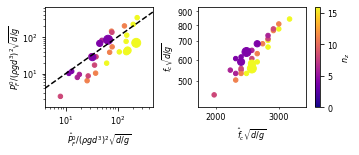

Geometric standard error epsilon = 2.2
Akaike information criterion = 69.5


In [21]:
# Function implementing a parametrisation of the minimal model, working from the observed velocity profile
def velocity_kinetic_model(indices=data.index):
    freq = hertz_f_c / tau(1) * 2**np.arange(-2, 3, 0.05)
    output = []
    # for each experiment's index, volume fraction, and channel-wall profiles,
    for index, sim in data.loc[indices].iterrows():
        if np.isfinite(sim.h):
            g_T = 0.3 / np.tan(np.pi / 180 * sim.th)
            alpha = sim.h / sim.l_d
            beta = 1 + 2 * sim.l_d * np.log(3)
            gamma = np.exp(-0.25 / sim.l_d)
            ids = (0 <= sim.pf_k['z']) & (sim.pf_k['z'] <= sim.h)
            eta = sim.pf_k['z'][ids] / sim.h
            # ... integrating contributions with depth at each frequency,
            P_F = (8./3. * np.sqrt(2) * np.pi * sim.A * sim.h * sim.H * np.cos(np.pi / 180 * sim.th) * g_T * gamma
                   * np.array([((1 - gamma**2 * np.exp(-alpha * eta)) * np.sqrt(1 - eta)
                                * np.exp(-alpha * beta * eta) * (sim.pf_k['u'].diff() / sim.pf_k['z'].diff())[ids]
                                * zeta(f * tau(np.sqrt(2) * g_T * (sim.pf_k['u'].diff() / sim.pf_k['z'].diff())[ids]))
                                * eta.diff().shift(-1)).sum()
                               for f in freq]))
            # ... and extracting corner frequency f_c, power spectral density P_F0
            fid_c = np.argmax(P_F[:-20] > 10 * P_F[20:])
            P_F0, f_c = P_F[fid_c] / zeta_f_c, freq[fid_c]            
            output.append(pd.Series({'P_F0': P_F0, 'f_c': f_c}, name=index))
        else:
            output.append(pd.Series({'P_F0': np.nan, 'f_c': np.nan}, name=index))
    # Return predictions for P_F0 and f_c
    return pd.DataFrame(output)

prediction = velocity_kinetic_model('steady')
plot_comparison(prediction, 'steady')

# Calculate geometric standard error
epsilon = np.exp(np.sqrt(np.mean(np.log(data.loc['steady'].P_F0 / prediction.P_F0)**2)))
print('Geometric standard error epsilon = {:.1f}'.format(epsilon))
# Calculate Akaike Information criterion (up to a constant)
AIC = data.loc['steady'].shape[0] * (1 + np.log(2 * np.pi * np.mean(np.log(data.loc['steady'].P_F0
                                                                           / prediction.P_F0)**2)))
print('Akaike information criterion = {:.1f}'.format(AIC))

*Even worse predictions are recovered by using the empirical relationship of da Cruz et al. (2005), which proposes that $T \approx (\dot{\gamma} d)^2 / 9 \hat{I}$, and other attempts aren't promising. The integral is dominated by contributions from $z/d < 2 \lambda / (1 + 2 \lambda \ln 3)$, but this basal boundary layer is difficult to model. It's likely that the profiles of $T$ can be numerically estimated using full kinetic theory (as in [Kumaran (2008)](https://chemeng.iisc.ac.in/kumaran/publications/2008/vkumaran_jfm599_2008.pdf)) or extended kinetic theory (as in [Gollin et al. (2017)](http://eprints.whiterose.ac.uk/119053/)), but deviations from molecular chaos make it less likely that $\langle v_n^2 \rangle$ can be accurately estimated.

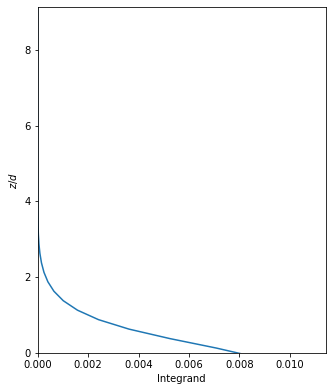

In [22]:
# Function plotting the integrand in the minimal model
def plot_integrand(mode, domain, sim_id):
    sim = data.loc[mode, domain, sim_id]
    ids = sim.pf_c['z'] >= 0
    offset = int(0.25 / sim.pf_c['z'].diff().mean())
    # Calculate contributions to low-frequency amplitude at each depth,
    I = (sim.pf_c['n_I'] * sim.pf_c['P_c'].shift(offset)
         * sim.pf_c['<v_n^2>'] * (1./9.)**sim.pf_c['z']
         * sim.pf_c['z'].diff())
    
    fig = plt.figure(figsize=[5, 6])
    ax = fig.add_axes([0.15, 0.15, 0.8, 0.8],
                      xlim=[0, 1.2 * I.max()],
                      ylim=[0, sim.h + 2])
    ax.plot(I, sim.pf_c['z'])
    ax.set_xlabel(r'Integrand')
    ax.set_ylabel(r'$z / d$')
    plt.show()

dropdown = interact(set_mode, plot=fixed('integrand'), mode=fixed('steady'),
                    domain=data.index.get_level_values('domain').unique())

### 4.4. Empirical relationship

Since parametrisation based on theoretical profiles was unsuccessful, we derive empirical relations for $P_F^0$ and $f_c$. We suppose that i) the exponential decay due to transmitted forces' geometric attenuation dominates variation of the integrand in section 4.2, providing an effective cut-off length $d / \log 3$; and ii) the rate of impacts is given by the relevant equation in section 3.2, with $\sigma_{zz} \approx \rho g H \cos \theta$ below this cut-off length. Consequently
$$\begin{align}
P_F &\approx \frac{8 \pi \rho^2 g d^2}{3} A H \cos \theta \int_0^{d/\log 3} \sqrt{\langle v_n^2} \rangle \zeta\left(f \tau\left(\sqrt{\langle v_n^2 \rangle}\right)\right) (1 - P_c(z)) P_c\left(z - d/4\right) \left(1 -\frac{z \log 3}{d}\right)  \text{ d}z\\
    &\approx \frac{4 \pi \rho^2 g d^3}{3 \log 3} A H p V_c \cos \theta \zeta\left(f \tau(V_c)\right)
\end{align}$$
for some representative collision velocity $V_c$ and factor $p$ accounting for the proportions of particles connected to the bed. I suppose that, for some constants $a$, $b$, and $C$, $pV_c$ is given by
$$
p V_c = C \left(\frac{\bar{u}}{\sqrt{g d}}\right)^a \left(\frac{h}{d}\right)^b \sqrt{gd}.
$$
and conduct an ordinary least squares multilinear regression to fit the model
$$
\log P_F^0 = \log \left(\frac{4 \pi \rho^2 g d^3 \sqrt{gd}}{3 \log 3} A H \cos \theta \right) + \log C + a \log \left(\frac{\bar{u}}{\sqrt{g d}}\right) + b \log \left(\frac{h}{d}\right) + \epsilon,
$$
for $\epsilon$ normally distributed with mean 0 and constant variance.

Further assuming that $P_c$ is also given by the relevant equation in section 3.2, taking a zeroeth order approximation implies that
$$
p \approx (1 - e^{-1/2\lambda})e^{-1/4\lambda},
$$
which permits prediction of $f_c$ from $pV_c$ and $\lambda$.

/usr/lib/python3/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1035.
Date:                Tue, 20 Aug 2024   Prob (F-statistic):           3.04e-26
Time:                        20:53:12   Log-Likelihood:                 19.762
No. Observations:                  30   AIC:                            -33.52
Df Residuals:                      27   BIC:                            -29.32
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5182      0.163      9.325      0.0

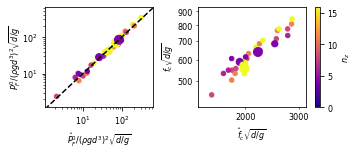

Geometric standard error epsilon = 1.13
Akaike information criterion = -33.5


In [23]:
data['pV_c'] = np.nan
for mode in ['steady']:
    # Perform a linear regression in log space
    gamma = np.exp(-0.25 / data.l_d)
    prefactor = (4 * np.pi / (3 * np.log(3))
                 * data.A * data.H * np.cos(np.pi / 180 * data.th))
    y = np.log(data.loc[mode].P_F0 / prefactor.loc[mode])
    X = sm.add_constant(np.log(data.loc[mode][['u_bar', 'h']]))
    model = sm.OLS(y, X)
    results = model.fit()
    print(results.summary())

    # Use the results to predict the high-frequency signal's properties
    pV_c = np.exp(results.predict())
    data['pV_c'].loc[mode] = pV_c
    prediction = pd.DataFrame({'P_F0': prefactor.loc[mode] * pV_c,
                               'f_c': hertz_f_c / tau(pV_c / (gamma * (1 - gamma**2)).loc[mode])})
    plot_comparison(prediction, mode)

    # Calculate geometric standard error
    sigma2 = np.mean(np.log(data.loc[mode].P_F0 / prediction.P_F0)**2)
    epsilon = np.exp(np.sqrt(sigma2))
    print('Geometric standard error epsilon = {:.2f}'.format(epsilon))
    # Calculate Akaike Information criterion (up to a constant)
    n_params = results.df_model + 1
    AIC = 2 * n_params + data.loc[mode].shape[0] * (1 + np.log(2 * np.pi * sigma2))
    print('Akaike information criterion = {:.1f}'.format(AIC))

In [24]:
# Plot Figure for publication, for the minimal model, of
# - the contributions from different depths to the seismic signal in various parametrisations
# - a comparison between predictions and results, for the semi-empirical parametrisation

mode = 'steady'
domain = '10dx10d'
sim_ids = ['th22.0h08', 'th24.5h16']

x_positions = [0.062, 0.23]
fig = plt.figure(figsize=[6, 2.4])
for plot_id, (x_pos, sim_id) in enumerate(zip(x_positions, sim_ids)):
    sim = data.loc[mode, domain, sim_id]
    yticks = range(0, int(sim.h + 2), 5)
    # Calculate prefactor for temperature-shear^2 relation and overburden pressure
    g_T = 0.3 / np.tan(np.pi / 180 * sim.th)
    sigma0 = sim.H * np.cos(np.pi / 180 * sim.th)
    # Calculate properties for bulk inertial number and mean shear rate
    I_hat = (5 * sim.q) / (2 * sim.h * sim.H * np.sqrt(sigma0))
    gamma = 2 * sim.q / (sim.h * sim.H)
    # Calculate exponential approximation for connection probability
    P_c_exp = np.exp(-(sim.pf_c['z'] + 0.5) / sim.l_d)
    P_c_exp_k = np.exp(-(sim.pf_k['z'] + 0.5) / sim.l_d)

    offset = int(0.25 / sim.pf_c['z'].diff().mean())
    # Calculate contributions to low-frequency amplitude at each depth
    I = (sim.pf_c['n_I'] * sim.pf_c['P_c'].shift(offset)
         * sim.pf_c['<v_n^2>'] * (1./9.)**sim.pf_c['z'])
    I_n_hat = (24 / np.pi * sigma0 * (1 - sim.pf_c['z'] / sim.h)
               * (1 - sim.pf_c['P_c']) * sim.pf_c['P_c'].shift(offset)
               * np.sqrt(sim.pf_c['<v_n^2>']) * (1./9.)**sim.pf_c['z'])
    I_Pc_hat = (24 / np.pi * sigma0 * (1 - sim.pf_c['z'] / sim.h)
                * (1 - P_c_exp) * P_c_exp.shift(offset)
                * np.sqrt(sim.pf_c['<v_n^2>']) * (1./9.)**sim.pf_c['z'])
    I_T = (24 / np.pi * sigma0 * (1 - sim.pf_k['z'] / sim.h)
           * (1 - P_c_exp_k) * P_c_exp_k.shift(offset)
           * np.sqrt(2 * sim.pf_k['T']) * (1./9.)**sim.pf_k['z'])
    I_T_hat = (24 / np.pi * sigma0 * (1 - sim.pf_k['z'] / sim.h)
               * (1 - P_c_exp_k) * P_c_exp_k.shift(offset)
               * np.sqrt(2) * g_T * sim.pf_k['u'].diff() / sim.pf_k['z'].diff() 
               * (1./9.)**sim.pf_k['z'])
    I_emp = (24 / np.pi * sigma0 * sim.pV_c * (1./9.)**sim.pf_c['z'])
        
    xmax = max(np.interp(0, sim.pf_c['z'], I),
               np.interp(0, sim.pf_c['z'], I_n_hat),
               np.interp(0, sim.pf_c['z'], I_Pc_hat),
               np.interp(0, sim.pf_k['z'], I_T))
    # Plot integrand
    ax_I = fig.add_axes([x_pos, 0.26, 0.125, 0.71],
                         xlim=[0, 1.1 * xmax],
                         ylim=[0, 4], yticks=[0,2,4])
    lines = ax_I.plot(I, sim.pf_c['z'], '-k',
                      I_n_hat, sim.pf_c['z'], '--k',
                      I_Pc_hat, sim.pf_c['z'], '-.k',
                      I_T, sim.pf_k['z'], ':k',
                      I_emp, sim.pf_k['z'], '-r')
    labels = [r'$\mathcal{I}$',
              r'$\mathcal{I}_{\hat{n}}$',
              r'$\mathcal{I}_{\hat{\mathcal{P}}_c}$',
              r'$\mathcal{I}_{T}$',
              r'$\mathcal{I}_{\hat{\psi}\hat{V}}$']
    ax_I.set_xlabel(r'$\mathcal{I}_\cdot \sqrt{d^5/g^3}$', fontsize=8)
    ax_I.set_ylabel(r'$z / d$', fontsize=8)
    ax_I.tick_params(labelsize=8)
    if (plot_id == 0):
        ax_I.legend(lines[:4], labels[:4],
                    handlelength=1.8, fontsize=8, frameon=False)
    else:
        ax_I.legend([lines[4]], [labels[4]],
                    handlelength=1.8, fontsize=8, frameon=False)
ax_I.set_ylabel('')

# Plot a comparison of semi-empirical model predictions, and results
thy_PF0_range = (0.5 * prediction.P_F0.min(),
                 2 * prediction.P_F0.max())
obs_PF0_range = (0.5 * data.loc[mode].P_F0.min(),
                 2 * data.loc[mode].P_F0.max())
PF0_range = [min(obs_PF0_range[0], thy_PF0_range[0]),
             max(obs_PF0_range[1], thy_PF0_range[1])]
thy_fc_range = (0.9 * prediction.f_c.min(),
                1.11 * prediction.f_c.max())
obs_fc_range = (0.9 * data.loc[mode].f_c.min(),
                1.11 * data.loc[mode].f_c.max())
fc_range = [min(obs_fc_range[0], thy_fc_range[0]),
            max(obs_fc_range[1], thy_fc_range[1])]

ax_P_F = fig.add_axes([0.455, 0.42, 0.22, 0.55], xscale='log', yscale='log',
                      xlim=PF0_range, ylim=PF0_range)
sc = ax_P_F.scatter(prediction.P_F0, data.loc[mode].P_F0,
                    marker='o', s=0.2*data.loc[mode].A,
                    c=data.loc[mode].nz, cmap='plasma', vmin=0, vmax=16)
ax_P_F.plot(PF0_range, PF0_range, color=[0.5, 0.5, 0.5])
ax_P_F.tick_params(axis='both', which='both', labelsize=8)
ax_P_F.set_xlabel(r'$\hat{P}_F^0 / (\rho g d^3)^2 \sqrt{d/g}$', fontsize=8)
ax_P_F.set_ylabel(r'$P_F^0 / (\rho g d^3)^2 \sqrt{d/g}$', fontsize=8)
ax_P_F.yaxis.set_label_coords(-0.25, 0.5)
ax_f_c = fig.add_axes([0.775, 0.42, 0.22, 0.55], xscale='log', yscale='log',
                      xlim=fc_range, xticks=[400, 600, 800],
                      ylim=fc_range, yticks=[400, 600, 800])
ax_f_c.scatter(prediction.f_c, data.loc[mode].f_c,
               marker='o', s=0.2*data.loc[mode].A,
               c=data.loc[mode].nz, cmap='plasma', vmin=0, vmax=16)
ax_f_c.plot(fc_range, fc_range, color=[0.5, 0.5, 0.5])
ax_f_c.tick_params(axis='both', which='both', labelsize=8)
ax_f_c.xaxis.set_major_formatter(ScalarFormatter())
ax_f_c.xaxis.set_minor_formatter(NullFormatter())
ax_f_c.yaxis.set_major_formatter(ScalarFormatter())
ax_f_c.yaxis.set_minor_formatter(NullFormatter())
ax_f_c.set_xlabel(r'$\hat{f}_c \sqrt{d/g}$', fontsize=8)
ax_f_c.set_ylabel(r'$f_c \sqrt{d/g}$', fontsize=8)
ax_f_c.yaxis.set_label_coords(-0.25, 0.5)

# Add a legend for element size
handles, labels = sc.legend_elements(prop="sizes", func=lambda s:5 * s)
fig.legend(handles, labels, loc=[0.435, 0.06], ncol=2,
           fontsize=8, frameon=False)
fig.text(0.38, 0.14, r'$A/d^2$', fontsize=8)
# Add a colorbar for overburden
ax_c = fig.add_axes([0.775, 0.15, 0.22, 0.04])
cbar = fig.colorbar(sc, cax=ax_c, orientation='horizontal')
cbar.set_label(r'$n_z$', fontsize=8)
ax_c.xaxis.set_label_coords(-0.2, 0.7)
ax_c.tick_params(labelsize=8)

#plt.show()
plt.savefig(figure_folder + 'parametrization.pdf')
plt.close()

## Appendix A: Plastic yield negligible

We calculate the yield parameter necessary to match [Foerster et al. (1994)](https://doi.org/10.1063/1.868282)'s experimental measurements with a Thornton model of elasto-plastic deformation. With such a yield parameter, the plastic deformation will have no effect on the dynamics of individual particles' Hertzian collisions in simulations, unless their normal relative velocity exceeds $0.6 \text{ m s}^{-1} = 4\sqrt{gd}$. Since such normal relative velocities are extremely rare in the simulations, we neglect particle plasticity entirely.

*In actuality, inelasticity of collisions will be, at least in part, due to plasticity at asperities, but it's not clear how this should be modelled.*

y_yield = 0.500000: e = 0.899967
y_yield = 0.537654: e = 0.911738
y_yield = 0.570916: e = 0.921721
y_yield = 0.731785: e = 0.960430
y_yield = 0.771554: e = 0.967874
y_yield = 0.782910: e = 0.969862
y_yield = 0.783699: e = 0.969998
y_yield = 0.783712: e = 0.970000
Yield pressure required: 1.0388e+10 Pa


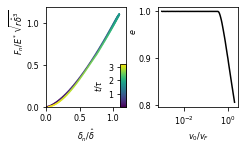

In [25]:
from scipy.integrate import solve_ivp

restitution_required = 0.97
yield0 = 0.5
t_res, t_max = 1e-2, 20

# thornton_ode_function returns rates of change of overlap & relative velocity
# (non-dimensionalised by (m^2 v0^4 (1 - nu^2)^2 / E^2 r)^0.2 and v0, resp.)
def thornton_ode_function(y_yield, t, y):
    global y0, y_max
    F = np.maximum((y[0] - y0), 0)**1.5
    if (y[0] > y_max):
        y_max = y[0]
        F = 0.5 * np.sqrt(y_yield) * (3 * y[0] - y_yield)
        y0 = y[0] - F**(2./3.)
    return [y[1], -F]

# end_contact is an event function indicating the contact has ended
def end_contact(t, y):
    global y0
    return y[0] - y0
end_contact.terminal = True
end_contact.direction = -1

# Excess rebound velocity, compared to experiments
def excess_restitution(y_yield):
    if(y_yield <= 0):
        return -1
    global y0, y_max
    y0, y_max = 0, y_yield
    solution = solve_ivp(lambda t, y: thornton_ode_function(y_yield, t, y),
                         [0, t_max], [0, 1], events=end_contact)
    
    print("y_yield = {:6f}: e = {:6f}".format(y_yield, -solution.y[1, -1]))
    return -solution.y[1, -1] - restitution_required

# Calculate plastic yield necessary for Thornton model to fit Foerster et al. (1994)'s experiments
yield_solution = root_scalar(excess_restitution, x0=0, x1=yield0)
          
y0, y_max = 0, yield_solution.root
solution = solve_ivp(lambda t, y: thornton_ode_function(yield_solution.root, t, y),
                     [0, t_max], [0, 1], t_eval = np.arange(0, t_max, t_res), events=end_contact)
fig = plt.figure(figsize=[8 / 2.52, 5 / 2.52])
ax_F = fig.add_axes([0.15, 0.25, 0.35, 0.7], xlim=[0, 1.2], ylim=[0, 1.2], yticks=[0, 0.5, 1.0])
sc = ax_F.scatter(solution.y[0,1:], -np.diff(solution.y[1,:]) / t_res,
                  marker='o', c=solution.t[1:], s=0.4)
ax_F.set_xlabel("$\delta_n / \hat{\delta}$", fontsize=8)
ax_F.set_ylabel("$F_n / E^* \sqrt{r \hat{\delta}^3}$", fontsize=8)
ax_F.tick_params(axis='both', which='both', labelsize=8)
ax_F.yaxis.set_label_coords(-0.25, 0.75)

ax_c = fig.add_axes([0.475, 0.25, 0.025, 0.3])

fig.colorbar(sc, ax_c, ticklocation='left')
ax_c.set_ylabel(r'$t / \tau$', fontsize=8)
ax_c.tick_params(axis='both', which='both', labelsize=8)

# Parameters for Foerster et al. (1994)'s experiments
rho, E, nu = 2530, 74e9, 0.22
r, v0 = 0.0015, 1
M, K = 4./3. * np.pi * rho * r**3, 2./3. * E / (1 - nu**2) * np.sqrt(r/2)
D = (m * v0**2 / K)**0.4
yield_pressure = E / (np.pi * (1 - nu**2)) * np.sqrt(D * yield_solution.root * 2 / r)

print("Yield pressure required: {:g} Pa".format(yield_pressure))

# Parameters for my DEM
rho, E, nu = 2530, 74e9, 0.22
r, v0 = 0.001, 0.01
M, K = 4./3. * np.pi * rho * r**3, 2./3. * E / (1 - nu**2) * np.sqrt(r/2)
D = (m * v0**2 / K)**0.4
T = (m**2 * K**2 / v0)**0.2
y_yield = 0.5 * r / D * (np.pi * yield_pressure * (1 - nu**2) / E)**2

# Range of incidence velocities investigated
v_min = 1.e-3
v_ratio = 2**0.1
v_max = 2

v_range = v_min * v_ratio**np.arange(0, np.log(v_max/v_min) / np.log(v_ratio) + 1)
th_e_eff = np.array([])

# Non-dimensionalised Hertzian force for non-dimensionalised deflection
def hertz_ode_function(t, y):
    F =  np.maximum(y[0], 0)**1.5
    return [y[1], -F]

# For each impact velocity, calculate the effective restitution for Thornton and Hertz models
for v in v_range:
    y0, y_max = 0, y_yield
    t_max = 5 * (v0/v)**0.2
    thornton_sol = solve_ivp(lambda t, y: thornton_ode_function(y_yield, t, y),
                             [0, t_max], [0, v/v0], events=end_contact, rtol=1e-6)
    th_e_eff = np.append(th_e_eff, -thornton_sol.y[1, -1] / (v/v0))

ax_e = fig.add_axes([0.64, 0.25, 0.35, 0.7], xscale='log', yticks=[0.8, 0.9, 1.0])
ax_e.plot(v_range, th_e_eff, 'k')
ax_e.set_xlabel(r'$v_0 / v_F$', fontsize=8)
ax_e.set_ylabel(r'$e$', fontsize=8)
ax_e.tick_params(axis='both', which='both', labelsize=8)
ax_e.yaxis.set_label_coords(-0.25, 0.75)

plt.savefig(figure_folder + 'plastic_yield.pdf')
plt.show()

## Appendix B: Interactions in DEM

We first describe the normal force between two interacting particles. If two particles have radii $r_1$ and $r_2$, centres at $\mathbf{x}_1$ and $\mathbf{x}_2$ and velocities $\mathbf{v}_1$ and $\mathbf{v}_2$, then they are said to be in contact whenever
$$\delta_n = r_1 + r_2 - ||\mathbf{x}_1 - \mathbf{x}_2|| > 0,$$
with the first particle's outward unit normal to the contact
$$\hat{\mathbf{n}} = (\mathbf{x}_2 - \mathbf{x}_1) / ||\mathbf{x}_2 - \mathbf{x}_1||,$$
and the effective radius for the interaction
$$r = \left(\frac{1}{r_1} + \frac{1}{r_2}\right)^{-1}.$$
At each timestep of this contact, for the dissipation constant $c$ whose value is described below, the normal force of the first particle on the second is specified to be
$$ \mathbf{F}_n = \frac{2 E}{3 (1 - \nu^2)} \sqrt{r \delta_n} (\delta_n + c \dot{\delta}_n)\hat{\mathbf{n}}.$$
This force is taken to act on a point directly between $\mathbf{x}_1$ and $\mathbf{x}_2$, and so is associated with no torque about the second particle's centre.

The tangential force also has viscous and elastic components, but with the elastic force dependent on the history of loading and with the total force limited by Coulomb friction, so that the calculation of the tangential force must be performed algorithmically. Firstly, at the start of each contact, the elastic tangential force is set to be $\mathbf{F}_{te} = \mathbf{0}$. Secondly, at each timestep during the contact, this force is adjusted to account for the rotation of the particle contact plane with respect to an inertial frame, so that, writing $\Delta t$ for the time step and $\cdot^n$ for the value of a given variable at the $n$th timestep,
$$\mathbf{F}^n_{te} = \mathbf{F}^{n-1}_{te} - \frac{\mathbf{F}^{n-1}_{te} \cdot (\mathbf{v}^{n-1}_2 - \mathbf{v}^{n-1}_1)}{||\mathbf{x}^n_2 - \mathbf{x}^n_1||} \Delta t \: \hat{\mathbf{n}}^n.$$
Thirdly, the instantaneous tangential stiffness is set to be
$$k_t = \frac{4 G}{2 - \nu} \sqrt{r \delta_n},$$
and the elastic force is set to its value in the case of zero tangential slip. If the particles' angular velocities are $\mathbf{\omega}_1$ and $\mathbf{\omega}_2$, then the relative tangential velocity across the contact is
$$\dot{\mathbf{\delta}}_t = \mathbf{v}_1 - \mathbf{v}_2 + \dot{\delta}_n \hat{\mathbf{n}} + (r_1 \mathbf{\omega}_1 + r_2 \mathbf{\omega}_2) \times \hat{\mathbf{n}},$$
and so, accounting for the possibility of unloading, this value is
$$\mathbf{F}^{n}_{te} =
    \begin{cases}
        \mathbf{F}^{n-1}_{te} + k^n_t \Delta t \: \dot{\mathbf{\delta}}_t \ \quad & \mathrm{if} \quad ||\mathbf{F}^n_n || \ge ||\mathbf{F}^{n-1}_n || \\
        \frac{k^n_t}{k^{n-1}_t} \mathbf{F}^{n-1}_{te} + k^n_t \Delta t \: \dot{\mathbf{\delta}}_t & \mathrm{ otherwise.}
    \end{cases}$$
Fourthly, the implied tangential force, including viscous resistance, is tested against a Coulomb friction condition, with friction coefficient $\mu$ described below. Specifically, defining for the same dissipation constant $c$ as above,
$$ \mathbf{F}_{t-ns} = \mathbf{F}^{n}_{te} +  k_t c \dot{\mathbf{\delta}}_t,$$
We set the tangential force of the first particle on the second to be
$$\mathbf{F}_t =
    \begin{cases}
        \mathbf{F}_{t-ns} \quad & \mathrm{if} \quad ||\mathbf{F}_{t-ns}|| \le \mu ||\mathbf{F}_n|| \\
        \mu ||\mathbf{F}_n|| \hat{\mathbf{F}}_{t-ns} & \mathrm{ otherwise.}
    \end{cases}    
$$
Finally, in the second case, where tangential slip occurs between the two particles, the elastic component of the tangential force is updated accordingly, as
$$ \mathbf{F}_{te} = \mathbf{F}_{t} - c k_t \dot{\mathbf{\delta}}_t.$$
The tangential force of the first particle on the second is taken to apply a torque about the latter's centre of 
$$ \mathbf{M}_t = (r_2 - \delta_n / 2) \mathbf{F}_t \times \hat{\mathbf{n}},$$
corresponding to the case of symmetric normal deformation.

The torsional torque exerted by the first particle about the second's centre is calculated analogously to the tangential force, except as a scalar multiple of the contact normal $\hat{\mathbf{n}}$ and with different parameter values. Consequently, at the start of the contact, the elastic scalar torque is set to be $M_{ne} = 0$, and $M_{ne}$ need not be updated to account for frame rotation. The contact stiffness is
$$k_n = \frac{16 G}{3} r^{3/2} \delta_n^{3/2},$$
and the scalar relative torsional rotation rate is
$$ \dot{\theta}_n = (\mathbf{\omega}_1 - \mathbf{\omega}_2) \cdot \hat{\mathbf{n}},$$
so, at the $n$th timestep, the elastic scalar torsional torque, in the case of zero torsional slip, is
$$M^{n}_{ne} =
    \begin{cases}
        M^{n-1}_{ne} + k^n_n \dot{\theta}_n \Delta t \ \quad & \mathrm{if} \quad ||\mathbf{F}^n_n || \ge ||\mathbf{F}^{n-1}_n || \\
        \frac{k^n_n}{k^{n-1}_n} M^{n-1}_{ne} + k^n_n \dot{\theta}_n \Delta t & \mathrm{ otherwise.}
    \end{cases}$$  
The effective Coulomb friction coefficient, imposed at the Hertzian contact radius, is $3 \pi \mu / 16$, so defining
$$ M_{n-ns} = M_{ne} +  k_n c \dot{\mathbf{\theta}}_n,$$
we set the torsional vector torque of the first particle on the second to be
$$\mathbf{M}_n =
    \begin{cases}
        M_{n-ns}\hat{\mathbf{n}} \quad & \mathrm{if} \quad |M_{n-ns}| \le \frac{3 \pi \mu}{16} ||\mathbf{F}_n|| \sqrt{r \delta_n} \\
        \frac{3 \pi \mu}{16} ||\mathbf{F}_n|| \sqrt{r \delta_n} \mathrm{sgn}(M_{n-ns})\hat{\mathbf{n}} & \mathrm{ otherwise,}
    \end{cases}
$$
unassociated with any net force between the particles. For consistency, the elastic scalar torsional torque is updated in the second case, as
$$ M_{ne} = (\mathbf{M}_{n} - k_n c \dot{\mathbf{\theta}}_n) \cdot \hat{\mathbf{n}}.$$

Finally, the torque imposed by rolling resistance is also calculated in a manner analagous to the tangential force. Again, the elastic component of the rolling resistance torque is initialised at the start of the contact, by setting $\mathbf{M}_{re} = 0$, and updated at each timestep to account for frame rotation, by setting
$$\mathbf{M}^n_{re} = \mathbf{M}^{n-1}_{re} - \frac{\mathbf{M}^{n-1}_{re} \cdot (\mathbf{v}^{n-1}_2 - \mathbf{v}^{n-1}_1)}{||\mathbf{x}^n_2 - \mathbf{x}^n_1||} \Delta t \: \hat{\mathbf{n}}^n.$$
The rate of rolling is
$$\dot{\mathbf{\theta}}_r = \mathbf{\omega}_1 - \mathbf{\omega}_2 - [(\mathbf{\omega}_1 - \mathbf{\omega}_2) \cdot \hat{\mathbf{n}}] \hat{\mathbf{n}}$$
and the stiffness is, for constant $\kappa$ discussed below,
$$k_r= 2 \kappa||\mathbf{F}_n|| r,$$
so the elastic component of the torque resisting rolling is, at the $n$th time step and in the case of zero slip, 
$$\mathbf{M}^{n}_{re} =
    \begin{cases}
        \mathbf{M}^{n-1}_{re} + k^n_r \dot{\mathbf{\theta}}_r \Delta t \ \quad & \mathrm{if} \quad ||\mathbf{F}^n_n || \ge ||\mathbf{F}^{n-1}_n || \\
        \frac{k^n_r}{k^{n-1}_r} \mathbf{M}^{n-1}_{re} + k^n_r \dot{\mathbf{\theta}}_r \Delta t & \mathrm{ otherwise.}
    \end{cases}$$  
Defining, for the rolling damping coefficient $c_r$ discussed below,
$$ \mathbf{M}_{r-ns} = \mathbf{M}_{re} +  k_r c_r \dot{\mathbf{\theta}}_r,$$
the torque imposed by rolling resistance is, for the empirical rolling friction coefficient $\mu_r$ discussed below,
$$\mathbf{M}_r =
    \begin{cases}
        \mathbf{M}_{r-ns} \quad & \mathrm{if} \quad ||\mathbf{M}_{r-ns}|| \le \mu_r ||\mathbf{F}_n|| r \\
        \mu_r ||\mathbf{F}_n|| r \hat{\mathbf{M}}_{r-ns} & \mathrm{ otherwise.}
    \end{cases}    
$$
Again, the torque is not associated with any net force and is updated in the second case, as
$$ \mathbf{M}_{re} = \mathbf{M}_{r-ns} -  k_r c_r \dot{\mathbf{\theta}}_r.$$

## Appendix C: Selection of simulation parameters

### Choice of damping constant $c$
Since the damping constant $c$ is difficult to measure directly, we seek to calibrate its value using measurements of the coefficient of restitution. Noting that $c$ is a function only of material parameters and has dimensions of time, we use [Foerster et al. (1994)](https://doi.org/10.1063/1.868282)'s experiments on binary collisions of 3-mm diameter soda lime glass spheres ($\rho = 2500$ kg m$^{-3}$, $E = 71$ MPa, $\nu = 0.22$), at normal incidence velocities of up to $1.2$ m s$^{-1}$, for which the coefficient of restitution was $0.97 \pm 0.01$.

The consequent effects of incidence velocity on a) effective restitution coefficient and b) non-dimensionalised contact time are plotted below.

Non-dimensional damping: 0.026520876643640712
Damping constant required: 4.509239698733496e-08 s


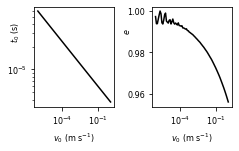

In [26]:
restitution_required = 0.97
c0 = (1 - restitution_required**2) / 2
t_max = 5

# kuwabara_ode_function returns rates of change of overlap & relative velocity
# (non-dimensionalised by (2 rho^2 v0^4 (1 - nu^2)^2 / E^2)^0.2 r and v0, resp.)
def kuwabara_ode_function(c, t, y):
    return [y[1], -np.maximum(y[0], 0)**0.5 * (y[0] + c * y[1])]

# end_contact is an event function indicating the contact has ended
def end_contact(t, y):
    return y[0]
end_contact.terminal = True
end_contact.direction = -1

# Excess rebound velocity, compared to experiments
def excess_restitution(restitution_required, c):
    solution = solve_ivp(lambda t, y: kuwabara_ode_function(c, t, y),
                         [0, t_max], [0, 1], events=end_contact, rtol=1e-6)
    return -solution.y[1, -1] - restitution_required

damping_solution = root_scalar(lambda c: excess_restitution(restitution_required, c), x0=0, x1=c0)

# Parameters for Foerster et al. (1994)'s experiments
rho, E, nu = 2500, 71e9, 0.22
r, v0 = 0.0015, 1.2
T = ((2 * rho**2 * (1 - nu**2)**2) / (E**2 * v0))**0.2 * r
damping_constant = T * damping_solution.root

print(f"Non-dimensional damping: {damping_solution.root}")
print(f"Damping constant required: {damping_constant} s")

# Parameters for my DEM
rho, E, nu = 2530, 74e9, 0.22
r, v0 = 0.001, 0.01
T = ((2 * rho**2 * (1 - nu**2)**2) / (E**2 * v0))**0.2 * r
c = damping_constant / T

# Range of incidence velocities investigated
v_min = 1.e-6
v_ratio = 2**0.25
v_max = 1.

v_range = v_min * v_ratio**np.arange(0, np.log(v_max/v_min) / np.log(v_ratio) + 1)
e_eff = np.array([])
t_coll = np.array([])

# For each impact velocity, apply the Kuwabara and Kono viscous model to a collision,
# then calculate effective restitution coefficient and collision time
for v in v_range:
    t_max = 5 * (v0/v)**0.2
    solution = solve_ivp(lambda t, y: kuwabara_ode_function(c, t, y),
                         [0, t_max], [0, v/v0], events=end_contact, rtol=1e-6)
    e_eff = np.append(e_eff, -solution.y_events[0][0][1] / (v/v0))
    t_coll = np.append(t_coll, solution.t_events[0][0])

fig = plt.figure(figsize=[8 / 2.52, 5 / 2.52])

ax_T = fig.add_axes([0.125, 0.25, 0.35, 0.7], xscale='log', yscale='log')
ax_T.plot(v_range, T * t_coll, 'k')
ax_T.set_xlabel("$v_0$ (m s$^{-1}$)", fontsize=8)
ax_T.set_ylabel("$t_0$ (s)", fontsize=8)
ax_T.tick_params(axis='both', which='both', labelsize=8)
ax_T.yaxis.set_label_coords(-0.15, 0.75)

ax_e = fig.add_axes([0.64, 0.25, 0.35, 0.7], xscale='log', yticks=[0.96, 0.98, 1])
ax_e.plot(v_range, e_eff, 'k')
ax_e.set_xlabel(r'$v_0$ (m s$^{-1}$)', fontsize=8)
ax_e.set_ylabel(r'$e$', fontsize=8)
ax_e.tick_params(axis='both', which='both', labelsize=8)
ax_e.yaxis.set_label_coords(-0.25, 0.75)

plt.savefig(figure_folder + 'damping_effect.pdf')
plt.show()
plt.show()

### Choice of rolling resistance parameters $\kappa$, $c_r$, $\mu_r$

We use experiments on single particles to select values for the non-dimensional rolling stiffness coefficient $\kappa$, the rolling damping timescale $c_r$, and the rolling friction coefficient $\mu_r$. Since rolling resistance arises primarily from the particles' deviations from sphericity, the rolling resistance of a particle on a stiff, flat plane will be approximately the same as that between two particles.

In the first experiment, each of 9 randomly selected particles is, in turn, placed on a flat metal plate. The plate is accelerated and brought to a rapid stop, at which point the particle's inertia and the friction at its contact point cause it to roll. Rolling resistance slows the particle's rotation until it reaches the no-slip regime described above, at which point it displays exponentially decaying harmonic oscillations about a local, stable equilibrium. Filming these oscillations at 250 frames per second, with an Optronis CR600x2 high speed camera, we use cross-correlation between successive images to extract the particle's horizontal velocity $u$. Under the no-slip viscoelastic model for rolling resistance described above, this velocity satisfies, for some constants $u_0$ and $\phi_0$ and for $I$ equal to the particle's moment of inertia,
$$u = u_0 \sin\left(\phi_0 + t\sqrt{\frac{k_r}{I} + \frac{c_r^2 k_r^2}{4 I^2}}\right) \exp\left( - \frac{c_r k_r }{2I} t\right).$$
Therefore, fitting a relation of this form to the decaying oscillations, minimising the sum of squared residuals, and noting that the particle is an approximate sphere under gravity, so that $k_r / I = 5 \kappa g / 2r$, we calculate the $\kappa$ and $c_r$ consistent with the particle's motion. Averaging these over the 9 repeats with different particles, we recover the values
$$\kappa = 0.742$$
$$c_r = 0.0020 \text{ s}.$$

As an example of this workflow, we present its application to an orange, of circumference 28 cm, with code updated for broader applicability.

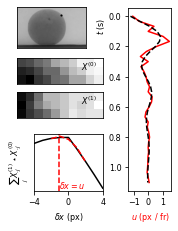

Proportion explained: 0.5020637549349185

$\kappa = 0.512 \pm 0.000$
$c_r = 0.0246 \pm 0.0000$ s


In [27]:
from scipy.optimize import minimize
particle = "orange"

## Set up specification of experiment
if particle == "glass_bead":
    # Number of experiments
    n_exp = 9
    # Filenames of frames from experiments
    filename = './Videos/Rolling_calibration/roll{0:d}/roll{0:d}_{1:03d}.png'
    # First post-forcing frame
    min_frame = [249, 249, 212, 116, 91, 194, 225, 189, 133]
    # Last frame
    max_frame = 250
    # Frames per second, grain radius, gravity
    fps, r, g = 250., 1e-3, 9.81
    # Vertical range of pixels in which particles lie
    row_use = np.arange(111, 141)
else:
    # Number of experiments
    n_exp = 1
    # Filenames of frames from experiments
    filename = './Figures/roll_orange/roll{0:d}_{1:03d}.png'
    # First post-forcing frame
    min_frame = [15]
    # Last frame
    max_frame = 50
    # Frames per second, grain radius, gravity
    fps, r, g = 30., 4.5e-2, 9.81
    # Vertical range of pixels in which particles lie
    row_use = np.arange(15, 555)
x_max = 5

# Calculate the residual sum of squares between an observed trajectory and a given damped harmonic
def rss_damped_harmonic(t, y, params):
    return ((y - np.sin(params[0] * t + params[1])
             * params[2] * np.exp(-params[3] * t))**2).sum()

freq = np.array([])
decay = np.array([])
Y = row_use.size
# For each experiment, ...
for rep in range(n_exp):
    dx = np.array([])
    # Read the first frame of post-forcing motion
    try:
        im_old = plt.imread(filename.format(rep, min_frame[rep]))
    except FileNotFoundError:
        print('Data not available at {}.\nExiting.'.format(filename.format(rep, min_frame[rep])))
        continue
    # Extract the rows of pixels including the particle, convert to greyscale, and subtract row mean
    mat_old = im_old[row_use].mean(axis=2, dtype=float)
    mat_old -= np.expand_dims(mat_old.mean(axis=1), 1).repeat(mat_old.shape[1], axis=1)
    X = mat_old.shape[1]
    # For each subsequent frame, ...
    for frame in range(min_frame[rep] + 1, max_frame):
        # Read the frame and standardise, as above
        im_new = plt.imread(filename.format(rep, frame))
        mat_new = im_new[row_use].mean(axis=2, dtype=float)
        mat_new -= np.expand_dims(mat_new.mean(axis=1), 1).repeat(mat_new.shape[1], axis=1)
        # Sum the cross-correlations between each row and the corresponding row of the previous frame
        correlation = np.zeros(2*x_max - 1)
        for row in range(Y):
            correlation += np.correlate(mat_new[row], mat_old[row], 'full')[X + np.arange(-x_max, x_max-1)]
        # Fit a Gaussian to the summed cross-correlation, in the vicinity of its maximum
        id_use = correlation.argmax() + np.arange(-2, 3)
        p = np.polyfit(id_use + 1 - x_max, np.log(correlation[id_use]), 2)
        # Estimate the displacement as the maximum of that Gaussian
        dx = np.append(dx, [-0.5 * p[1] / p[0]])
        # Add plot if first image
        if frame == min_frame[rep] + 1:
            fig = plt.figure(figsize=[6 / 2.52, 8 / 2.52])
            ax_im = fig.add_axes([0.05, 0.74, 0.4, 0.25], xticks=[], yticks=[])
            ax_im.imshow(im_old.mean(axis=2), cmap='gray', vmin=0, vmax=1)
            ax_im.plot(645, row_use[0] + 108, 'ks', ms=1)
            ax_f0 = fig.add_axes([0.05, 0.55, 0.5, 0.25], xticks=[], yticks=[])
            ax_f0.imshow(mat_old[107:110, 640:650], cmap='gray')
            ax_f0.text(7, 1, r'$X^{(0)}$', fontsize=8)
            ax_f1 = fig.add_axes([0.05, 0.4, 0.5, 0.25], xticks=[], yticks=[])
            ax_f1.imshow(mat_new[107:110, 640:650], cmap='gray')
            ax_f1.text(7, 1, r'$X^{(1)}$', fontsize=8)
            ax_corr = fig.add_axes([0.15, 0.15, 0.4, 0.25],
                                   xticks=[-4, 0, 4], xlim=[-4, 4], yticks=[])
            ax_corr.plot(np.arange(1 - x_max, x_max), correlation, '-k',
                         id_use + 1 - x_max, np.exp(np.polyval(p, id_use + 1 - x_max)), '--r')
            ax_corr.axvline(dx[-1], c='r', ls='--')
            ax_corr.text(dx[-1], correlation.min(), r'$\delta x = u$', fontsize=8, color='r')
            ax_corr.set_xlabel(r'$\delta x$ (px)', fontsize=8)
            ax_corr.set_ylabel(r'$\sum_j X_{\cdot j}^{(1)} \star X_{\cdot j}^{(0)}$', fontsize=8)
            ax_corr.tick_params(axis='both', which='both', labelsize=8)
        mat_old = mat_new
    # If any displacement has been recorded, ...
    if (dx.size > 0):
        t = np.arange(dx.size) / fps
        # Identify the frames of the velocity's global maximum and minimum - the first extrema of harmonic decay
        f_dx_max = np.argmax(dx)
        f_dx_min = np.argmin(dx)
        # Use these to calculate initial estimates of the best-fit damped harmonic's parameters
        afreq0 = np.pi * fps / np.abs(f_dx_max - f_dx_min)
        decay0 = np.abs(np.log(-dx[f_dx_max] / dx[f_dx_min]) * afreq0 / np.pi)
        params0 = [afreq0, 0.5 * np.pi - f_dx_max * afreq0 / fps, np.abs(dx).max(), decay0]
        # Calculate the least-squares best-fit damped harmonic parameters
        minimum = minimize(lambda params: rss_damped_harmonic(t, dx, params), params0)
        # Compare the observed displacement to the best-fit damped harmonic
        dx_bf = np.sin(minimum.x[0] * t + minimum.x[1]) * minimum.x[2] * np.exp(-minimum.x[3] * t)
        ax_dx = fig.add_axes([0.7, 0.15, 0.25, 0.8])
        ax_dx.invert_yaxis()
        ax_dx.plot(dx, t, '-r', dx_bf, t, '--k')
        ax_dx.set_ylabel(r'$t$ (s)', fontsize=8)
        ax_dx.set_xlabel(r'$u$ (px / fr)', fontsize=8, color='r')
        ax_dx.tick_params(axis='both', which='both', labelsize=8)
        ax_dx.yaxis.set_label_coords(-0.5, 0.9)
        plt.savefig(figure_folder + 'rolling_calibration.pdf')
        plt.show()
        prop_explained = 1 - np.sqrt(minimum.fun / (dx**2).sum())
        print('Proportion explained: {}'.format(prop_explained))
        # If the fit is sufficiently good, with over half the variance of displacement explained, ...
        if (prop_explained > 0.5):
            # Save the parameter estimates
            freq = np.append(freq, [minimum.x[0]])
            decay = np.append(decay, [minimum.x[3]])

# From the damped-harmonic parameter estimates, estimate the rolling friction parameters
if freq.size:
    kappa = 0.4 * r / g * (freq**2 - decay**2)
    cr = 2 * decay / (freq**2 - decay**2)
    print()
    print("$\kappa = {0:5.3f} \pm {1:5.3f}$".format(kappa.mean(), kappa.std() / np.sqrt(kappa.size)))
    print("$c_r = {0:6.4f} \pm {1:6.4f}$ s".format(cr.mean(), cr.std() / np.sqrt(cr.size)))

In the second experiment, we repeatedly place a particle at the top of a $L = 20$-cm long glass plate, inclined at an angle $\Theta$, and disturb the particle's position until it starts to roll. We then record whether it continues rolling until it reaches the bottom of the plate. We vary the plate's inclination to find:
1. the maximum angle $\Theta_M = 0.9\degree$ at which the bottom is reached on none of five successive attempts
2. the minimum angle $\Theta_m = 1.1\degree$ at which the bottom is reached on all of five successive attempts

Using the model for rolling resistance described above and writing $m$ for the particle's mass, its angular acceleration while freely rolling will be
$$\ddot{\theta} = \frac{mgr}{I} \cos \Theta (\tan \Theta - \mu_r),$$
so that the particle will reach the bottom of the plate if and only if
$$ \mu_r \le \tan \Theta + \frac{I \omega_0^2}{mgL \cos \Theta},$$
for $\omega_0$ the particle's initial angular velocity, of order $10$ s$^{-1}$. With the latter term of order $10^{-5}$, and so negligible, we estimate $\mu_r$ as the average of its upper and lower bounds $\tan \Theta_M$ and $\tan \Theta_m$:

$\mu_r = 0.0175$

In [28]:
mu_bar = 0.5 * (np.tan(1.1*np.pi/180) + np.tan(0.9*np.pi/180))
mu_err = 0.33 * (np.tan(1.1*np.pi/180) - np.tan(0.9*np.pi/180))
print("$\mu_r = {0:6.4f} \pm {1:6.4f}$".format(mu_bar, mu_err))

$\mu_r = 0.0175 \pm 0.0012$


### Choice of sliding friction coefficient $\mu_t$

Having selected all the other simulation parameters, we select the value of the microscopic sliding friction $\mu_t$ for which the angle of repose in simulations matched an experimentally measured value for glass beads. 

Experimentally, we half fill a tray with glass beads, vibrating the tray to ensure the bead pack's surface is level. We then incline the tray until the beads avalanche, wait until the avalanching beads come to rest, and increase its inclination again until another avalanche occurs. By measuring these two changes in the bead pack's surface's inclination, from $0\degree$ up to the beads' avalanche angle $\theta_a$, and from their angle of repose $\theta_r$ up to their avalanche angle $\theta_a$, we calculate an estimate of the angle of repose $\theta_r$. Repeating the experiment 12 times and averaging the estimates, we recover $\theta_r = 21.9 \pm 0.6 \degree$.

To match simulations to experiments, we conduct a binary search to find the lowest sliding friction coefficient for which simulated beads come to a rest with a surface angle of $\theta_r = 21.9\degree$. Specifically, we start with $\mu_t^- = 0$ and $\mu_t^+ = 1$ as bounds for the 'true' value of the sliding friction coefficient and select a trial value $\mu_t^0 = (\mu_t^- + \mu_t^+)/2$, with which we run a simulation according to the protocol described in 'Attainment of a steady state', with $n_x = n_y = n_z = 10$ and with $\theta = 21.9 \degree$. If the simulation attains a steady, non-static state, then this friction coefficient is insufficiently large for the simulated beads to match experiments and we update $\mu_t^-$ to $\mu_t^0$. If the simulated beads come to a rest, we update $\mu_t^+$ to $\mu_t^0$. Either way, we continue the procedure until the bounds constrain the 'true' value to 3 significant figures and use this 3 s.f. value for $\mu_t$. We recover $\mu_t = 0.237$

### Choice of interaction parameters at simulated channel walls

To consider the effect of lateral boundaries, we run a simulation in which there is a fixed wall at $y=0$, corresponding to an acrylic (PMMA) channel wall, and another at $y=Y$, corresponding to a symmetry condition at the midline of a channel. Interactions between particles and the walls are modelled in the same way as those between particles, as described in Appendix B, except with appropriately changed definitions and values of material parameters.

Specifically, in place of the condition on $\delta_n$, we take a particle with radius $r_2$ and $y$-co-ordinate $y_2$ to be in contact with the wall at $y = 0$ if overlap $\delta_n = r_2 - y_2 > 0$. In this case, we use for the wall-particle interaction an effective radius $r = r_2$, an outwards normal $\hat{\mathbf{n}} = \mathbf{e}_y$, an inverse separation $||\mathbf{x}_2 - \mathbf{x}_1||^{-1} = 0$, a 'first particle' velocity $\mathbf{v}_1 = \mathbf{0}$, and a 'first particle' angular velocity $\mathbf{\omega}_1 = \mathbf{0}$. Taking the Young's modulus of PMMA to be $E_w = 3.3$ MPa, its Poisson ratio to be $\nu_w = 0.4$, and its shear modulus to be $G_w = E_w / 2(1 + \nu_w)$, we replace the values i) $E / (1 - \nu^2)$ in the equation for $\mathbf{F}_n$, ii) $G / (1 - \nu)$ in the equation for $k_t$, and iii) $G$ in the equation for $k_n$, with their corresponding harmonic means
$$
2 \left( \cdot^{-1} + \cdot_w^{-1} \right)^{-1}.
$$
The sliding friction coefficient $\mu_w$ between a glass particle and the PMMA wall is taken to correspond to the $6 \degree$ minimum angle at which a plate coated with glued glass beads slides on a PMMA plate, such that $\mu_w = 0.105$, and this value replaces $\mu$ in the equations for $\mathbf{F}_t$ and $\mathbf{M}_n$. Finally, the dissipation coefficient $c_w$ for a collision between a glass particle and the PMMA wall is taken to be that necessary for a glass bead dropped onto a PMMA plate from a height of $h = 0.1$ m to have a rebound height of $0.08$ m, such that $c_w = 2 \times 10^{-7}$ s, and this value replaces $c$ in the calculation of $\mathbf{F}_n$, $\mathbf{F}_t$, and $\mathbf{M}_n$.

Correspondingly, we take a particle with radius $r_2$ and $y$-co-ordinate $y_2$ to be in contact with the wall at $y = Y$ if overlap $\delta_n = r_2 - (Y - y_2) > 0$. For interactions between this wall and the particle, we use an outwards normal $\hat{\mathbf{n}} = -\mathbf{e}_y$, but again take an effective radius $r = r_2$, an inverse separation $||\mathbf{x}_2 - \mathbf{x}_1||^{-1} = 0$, a 'first particle' velocity $\mathbf{v}_1 = \mathbf{0}$, and a 'first particle' angular velocity $\mathbf{\omega}_1 = \mathbf{0}$. We want the interaction of a particle with the wall to be equivalent to that of the particle with an identical particle, exactly reflected in the plane $y = Y$, but note that $r$ has twice the value it would have in that case and $\delta_n$ half the value it would have. We therefore we use in the equation for $\mathbf{F}_n$ a value of $E / (1 - \nu^2)$ that is twice that used for interparticle collisions, ensuring that $\mathbf{F}_n$ takes the exact value it would have in an interparticle interaction with a reflected particle. Similarly, we note that a particle would experience no tangential motion or torsional rotation relative to its exact reflection, and so set the tangential force and torsional torque to zero by replacing $\mu$ with zero in the equations for $\mathbf{F}_t$ and $\mathbf{M}_n$. Finally, since $\mathbf{\omega}_1 = 0$ rather than $-\mathbf{\omega}_2$ and $r = r_2$ rather than $r_2 / 2$, $\dot{\theta}_r$ is defined to be half the value it would in the case of an interaction with a reflected particle while $k_r$ has a value twice as large, and so equations need not be changed to ensure a correct value of rolling resistance.

In [29]:
# Calculate the damping coefficient necessary for the observed rebound from a PMMA plate
restitution_required = np.sqrt(0.8)
c0 = (1 - restitution_required**2) / 2
t_max = 20

def excess_restitution(c):
    solution = solve_ivp(lambda t, y: kuwabara_ode_function(c, t, y),
                         [0, t_max], [0, 1], events=end_contact, rtol=1e-6)
    return -solution.y[1, -1] - restitution_required

g, h = 9.81, 0.1
rho, E, nu = 2530, 74e9, 0.22
E_wall, nu_wall = 3.3e9, 0.4
r, v0 = 0.001, np.sqrt(2 * g * h)
E_eff = 2. / ((1 - nu**2) / E + (1 - nu_wall**2) / E_wall)
T = (2 * rho**2 / (E_eff**2 * v0))**0.2 * r

damping_solution = root_scalar(excess_restitution, x0=0, x1=c0)
damping_constant = T * damping_solution.root
print('c_w = {} s'.format(damping_constant))

c_w = 2.7085138090190734e-07 s


### Choice of timestep
We seek a timestep sufficiently small that, for a normal collision between the particles of [Arran et al. (2021)](https://doi.org/10.1029/2021JF006172) at an incident velocity of 0.144 ms$^{-1}$ - the 99.9th percentile point of normal impact velocities in a trial simulation with $\theta = 23.5 \degree$ and $n_z = 11$ - the root mean squared error in the normal force is less than 1% of the root mean squared normal force.

Timestep required: 1.5425052172048197e-07 s


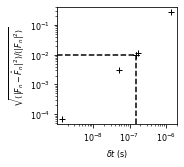

In [30]:
# Define target error
fractional_error_required = 0.01

# Parameters for my DEM
rho, E, nu = 2530, 74e9, 0.22
r, v0 = 0.001, 0.3617
T = ((2 * rho**2 * (1 - nu**2)**2) / (E**2 * v0))**0.2 * r
t_max = 5

# Calculate the theoretical collision time
c = damping_constant / T
solution = solve_ivp(lambda t, y: kuwabara_ode_function(c, t, y), [0, t_max], [0, 1],
                     dense_output=True, events=end_contact, rtol=1e-6)
collision_time = solution.t_events[0][0]

timesteps, fractional_rms_errors = [], []
# Function to calculate and record excess error in force estimation due to simulation with a given timestep
def calculate_excess_error(dt):
    # Extract the theoretical forces during the collision
    times = np.arange(0, collision_time + dt, dt)
    x, v = solution.sol(times)
    force = np.maximum(x, 0)**0.5 * (x + c * v)
    rms_force = np.sqrt((force**2).sum())

    # Simulate a collision using the given fixed timestep, calculating the RMS error in forces
    x_hat, v_hat, a_hat = 0., 1., 0.
    ssr = 0.
    for t_id in np.arange(1, times.size):
        v_hat += 0.5 * a_hat * dt
        x_hat += v_hat * dt
        a_hat = -np.maximum(x_hat, 0)**0.5 * (x_hat + c * v_hat)
        v_hat += 0.5 * a_hat * dt
        ssr += (force[t_id] + a_hat)**2
    # Record the timestep and the associated RMS error, as a fraction of the true RMS forces
    global timesteps, fractional_rms_errors
    timesteps.append(dt)
    fractional_rms_errors.append(np.sqrt(ssr) / rms_force)
    # Return the excess fractional error
    return np.sqrt(ssr) / rms_force - fractional_error_required

# Find the largest timestep for which fractional error is sufficiently small
timestep_solution = root_scalar(calculate_excess_error, bracket=[1e-3, 1], rtol=0.01)
timestep = T * timestep_solution.root
print("Timestep required: " + str(timestep) + " s")
# Plot RMS errors as a function of timestep
fig = plt.figure(figsize=[6 / 2.52, 5.5 / 2.52])
ax = fig.add_axes([0.27, 0.2, 0.7, 0.75], xscale='log', yscale='log')
ax.plot(T * np.array(timesteps), fractional_rms_errors, '+k')
xlim, ylim = ax.get_xlim(), ax.get_ylim()
ax.plot([xlim[0], timestep], [1e-2, 1e-2], '--k',
        [timestep, timestep], [ylim[0], 1e-2], '--k')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(r"$\delta t$ (s)", fontsize=8)
ax.set_ylabel(r"$\sqrt{\langle |F_n - \hat{F}_n|^2 \rangle / \langle |F_n|^2 \rangle}$", fontsize=8)
ax.tick_params(axis='both', which='both', labelsize=8)
plt.savefig(figure_folder + 'timestep.pdf')
plt.show()

## Appendix D: Coarse-graining

The coarse-graining process calculates local weighted averages of the properties of discrete particles, while respecting mass and momentum conservation. In our implementation, we average over horizontal directions $x$ and $y$ and over all timesteps $t_j$ while resolving the base-normal direction $z$, using truncated Gaussian weight functions of width equal to the median particle diameter $d$: 
\begin{equation}
w(\mathbf{x}_i; z) = \begin{cases}
\frac{\exp(-2(z_i - z)^2/d^2)}{X Y d \Delta t \erf(K\sqrt{2})}\sqrt{\frac{2}{\pi}}&\text{ if } |z_i - z| < Kd \\
0 & \text{ otherwise,}
\end{cases}
\end{equation}
where $X$ and $Y$ are the downslope and cross-slope extents of the cross-graining domain, $\Delta t$ is the time duration simulated, and $K$ is a cutoff. We take $X$ and $Y$ to be $n_x d$ and $n_y d$ for the simulations with periodic boundaries in the cross-slope direction, and $n_x d$ and $n_y d/2$ when simulating flow in a channel. We take $K=3$ to calculate the kinematic profiles $\phi(z)$, $\mathbf{u}(z)$ and $T(z)$, while taking $K$ to be infinite in calculating the profiles $P_C(z)$, $n_I(z)$, $\langle \dot{\delta}_n^2 \rangle(z)$ and $\langle ||\dot{\mathbf{\delta}}_t||^2 \rangle(z)$.

The kinematic profiles are defined from the timestep $\delta t$ and particle positions $\mathbf{x}_i(t_j)$, volumes $V_i$, and velocities $\mathbf{u}_i(t_j)$, excluding all fixed, basal particles, as
\begin{align}
\phi(z) &= \sum_i \sum_j w(\mathbf{x}_i(t_j); z) V_i \delta t, \\
\mathbf{u}(z) &= \sum_i \sum_j w(\mathbf{x}_i(t_j); z) V_i \mathbf{u}_i(t_j) \delta t / \phi(z), \\
T(z) &= \frac{1}{3}\sum_i \sum_j w(\mathbf{x}_i(t_j); z) V_i ||\mathbf{u}_i(t_j) - \mathbf{u}(z)||^2 \delta t/ \phi(z),
\end{align}
while the probability profile $P_C(z)$ was defined to be
\begin{equation}
P_c(z) = \frac{\sum_i \sum_j w(\mathbf{x}_i(t_j); z) \iota_{C(t_j)}(i)}{\sum_i \sum_j w(\mathbf{x}_i(t_j); z)},
\end{equation}
where basal particles are included in the sum and $\iota_{C(t_j)}(i)$ is 1 if particle $i$ is in the time-$t_j$ base-connected set $C(t_j)$ and 0 otherwise. The collisional profiles are defined from each collision's contact point $\mathbf{x}^c_i$ and relative normal and tangential velocities $\dot{\delta}_{i,n}$ and $\dot{\mathbf{\delta}}_{i,t}$, by
\begin{align}
n_I(z) &= \sum_i w(\mathbf{x}^c_i; z), \\
\langle \dot{\delta}_n^2 \rangle(z) &= \sum_i w(\mathbf{x}^c_i; z) \dot{\delta}_{i,n}^2 / n_I(z), \\
\langle ||\dot{\mathbf{\delta}}_t||^2 \rangle(z) &= \sum_i w(\mathbf{x}^c_i; z) ||\dot{\delta}_{i,t}||^2 / n_I(z).
\end{align}
For the simulations of channel flow, all the sums above are restricted to particles with $y_i(t_j) > n_y d / 2$ or to collisions with $y^c_i(t_j) > n_y d / 2$. All profiles are calculated at $16n_z$ values of $z$, separated by intervals of $d/4$ and starting from $z = -7d/8$, just above the fixed boundary at $z=-d$.

## Appendix E: Comparison with experimental velocity profiles

Having chosen simulation parameters to match experiments, we compare the velocity profiles observed in simulations, both at the sidewall and in the flow's bulk, to those observed at the sidewall in experiments. We also illustrate how downslope velocities vary throughout the simulated channel.

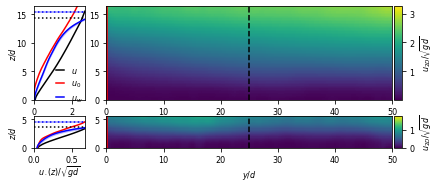

In [31]:
# Plot Figure for publication, of downslope velocities within simulated and experimental channels
fig = plt.figure(figsize=[15 / 2.52, 6 / 2.52])
for ax_y, sim_id, exp_set in [(0.44, 'th22.0h16', 'g0.44_h40'), (0.16, 'th24.5h04', 'g0.46_h10')]:    
    # Extract relevant variables from the cross-sectional statistics for the simulation
    sim = data.loc['steady', '10dx50d_wall', sim_id]
    cs_filename = data_folder.format('10dx50d_wall', sim_id) + 'cross_section.stat'
    with open(cs_filename, 'r') as cs_file:
        n = np.array(cs_file.readline().split(" n ")[1].split()[:3]).astype(int)
        n = dict(zip(['x', 'y', 'z'], n))
    cross_section = pd.read_csv(cs_filename, sep=' ', skiprows=[0,2], usecols=[1,2,3,5,6,17,20])
    cross_section['y'] = (cross_section.Y / d).round(decimals=3)
    cross_section['z'] = (cross_section.Z / d).round(decimals=3)
    cross_section['U'] = cross_section.MomentumX / (rho * cross_section.Nu)
    cross_section = cross_section.set_index(['y', 'z']).unstack('y')
    
    # Extract relevant variables for the three experiments in comparable conditions
    u_exp, h_exp = [], []
    for repeat in range(3):
        exp_id = exp_set + '_{}'.format(repeat)
        pf = pd.read_csv(experimental_profile_filename.format(exp_id),
                         skiprows=[1], sep='\s*,\s*', engine='python')
        u_exp.append(pf.u)
        h_exp.append(exp_data.h[exp_id] / d)
    u_exp, h_exp = np.vstack(u_exp), np.array(h_exp)
    u_exp_bar, u_exp_err = u_exp.mean(axis=0), u_exp.std(axis=0) / np.sqrt(3)
    h_exp_bar, h_exp_err = h_exp.mean(), h_exp.std() / np.sqrt(3)
    
    # Plot velocity profiles
    ax_pf = fig.add_axes([0.07, ax_y, 0.12, (sim.h + 2) / 30])
    ax_pf.set_xlim([0, 2 * sim.q / sim.H])
    ax_pf.set_ylim([0, sim.h + 2])
    lines = ax_pf.plot(sim.pf_k['u'], sim.pf_k['z'], '-k',
                       cross_section.U[0.125] / np.sqrt(g * d), cross_section.Z[0.125] / d, '-r',
                       u_exp_bar, pf.z, '-b')
    labels = [r'$u$', r'$u_0$', r'$u_w$']
    ax_pf.plot(ax_pf.get_xlim(), sim.h * np.ones(2), ':k',
               ax_pf.get_xlim(), h_exp_bar * np.ones(2), ':b')
    ax_pf.fill_between(ax_pf.get_xlim(),
                      (h_exp_bar - h_exp_err) * np.ones(2),
                      (h_exp_bar + h_exp_err) * np.ones(2),
                      color='b', alpha=0.2)
    ax_pf.fill_betweenx(pf.z, u_exp_bar - u_exp_err, u_exp_bar + u_exp_err, color='b', alpha=0.2)
    ax_pf.set_ylabel(r'$z / d$', fontsize=8)
    ax_pf.yaxis.set_label_coords(-0.3, 0.5)
    ax_pf.tick_params(axis='both', which='both', labelsize=8)

    # Plot downslope velocities throughout the channel's cross-section
    ax_cs = fig.add_axes([0.24, ax_y, 2./3., (sim.h + 2) / 30])
    ax_cs.set_ylim([0, sim.h + 2])
    cs = ax_cs.pcolormesh(cross_section.Y / d, cross_section.Z / d,
                          cross_section.U / np.sqrt(g * d),
                          shading='nearest', linewidth=0, rasterized=True)
    ax_cs.plot(0.125 * np.ones(2), ax_cs.get_ylim(), '-r',
               25 * np.ones(2), ax_cs.get_ylim(), '--k')
    ax_cs.tick_params(axis='both', which='both', labelsize=8)
    
    ax_c = fig.add_axes([0.91, ax_y, 0.02, (sim.h + 2) / 30])
    fig.colorbar(cs, ax_c)
    ax_c.set_ylabel(r'$u_{2D} / \sqrt{gd}$', fontsize=8)
    ax_c.tick_params(axis='both', which='both', labelsize=8)

ax_pf.set_xlabel(r'$u_\cdot(z) / \sqrt{gd}$', fontsize=8)
ax_pf.xaxis.set_label_coords(0.5, -0.5)
ax_cs.set_xlabel(r'$y / d$', fontsize=8)
fig.legend(lines, labels, loc=[0.12, 0.43], frameon=False, fontsize=8, handlelength=1.0)
fig.savefig(figure_folder + "cross_section.pdf")
plt.show()

## Appendix F: Intermediate-frequency signals

In [32]:
# Plot Figure for publication, of the relation to the relative magnitude of intermediate-frequency signals of:
# - the contact network's base-normal decay length
# - the bulk inertial number
# - the slope angle

labels = ['a', 'b', 'c']
x_positions = [0.58, 0.12]

fig = plt.figure(figsize=[15 / 2.52, 5 / 2.52])

# Plot P_F_z(10\sqrt(gd))/P_F^0 against decay length
ax_lambda = fig.add_axes([0.1, 0.225, 0.2, 0.7], xscale='log', yscale='log')
ax_lambda.scatter(data.loc['steady'].l_d, data.loc['steady'].P_F_z_i_ratio,
                  marker='o', s=0.2*data.loc['steady'].A,
                  c=data.loc['steady'].nz, cmap='plasma', vmin=0, vmax=16)

# Label axes
ax_lambda.set_xlabel(r'$\lambda$', fontsize=8)
ax_lambda.xaxis.set_label_coords(0.5, -0.175)
ax_lambda.set_ylabel(r'$\langle P_{F_z} \rangle_{\Delta f} (10\sqrt{g/d}) / P_F^0$', fontsize=8)
ax_lambda.tick_params(axis='both', which='both', labelsize=8)

print("Spearman's rank correlation between $\lambda$ and $P_{F_z}(10\sqrt{g/d}) / P_F^0$:")
print(data.loc['steady'].P_F_z_i_ratio.corr(data.loc['steady'].l_d, method='spearman'))

# Plot P_F_z(10\sqrt(gd))/P_F^0 and P_F_y(10\sqrt(gd))/P_F^0 against I
P_F_yz_ratio = data.loc['steady'].P_F_y_i_ratio.median()
print("Median of $P_{F_y}(10\sqrt{g/d}) / P_F^0$:")
print(P_F_yz_ratio)

ax_I = fig.add_axes([0.4, 0.225, 0.2, 0.7],
                    xscale='log', yscale='log',
                    xticks=[0.1, 0.4])
ax_I.scatter(data.loc['steady'].I_hat, data.loc['steady'].P_F_y_i_ratio,
             marker='x', s=0.2*data.loc['steady'].A,
             c=data.loc['steady'].nz, cmap='plasma', vmin=0, vmax=16)
sc_I = ax_I.scatter(data.loc['steady'].I_hat, data.loc['steady'].P_F_z_i_ratio,
                    marker='o', s=0.2*data.loc['steady'].A,
                    c=data.loc['steady'].nz, cmap='plasma', vmin=0, vmax=16)

# Add a legend for element size
handles, labels = sc_I.legend_elements(prop="sizes", func=lambda s:5 * s)
fig.legend(handles, labels, loc=[0.2, 0.25], fontsize=8, frameon=False,
           title = r'$A/d^2$', title_fontsize = 8)

fig.text(0.52, 0.865, r'$j$ :', fontsize=8)
fig.legend(handles = [Line2D([], [], marker='x', color='k', markersize=5,
                             linestyle='None', label=r'$y$'),
                      Line2D([], [], marker='o', color='k', markersize=5,
                             linestyle='None', label='$z$')],
           loc=[0.53, 0.74], fontsize=8, frameon=False, handletextpad=-0.2)
# Label axes
ax_I.xaxis.set_major_formatter(ScalarFormatter())
ax_I.xaxis.set_minor_formatter(NullFormatter())
ax_I.set_xlabel(r'$\hat{I}$', fontsize=8)
ax_I.xaxis.set_label_coords(0.5, -0.175)
ax_I.set_ylabel(r'$\langle P_{F_j} \rangle_{\Delta f} (10\sqrt{g/d}) / P_F^0$', fontsize=8)
ax_I.tick_params(axis='both', which='both', labelsize=8)

# Plot tan \theta against $P_{F_x}(.) / P_{F_x}(.)$ for $f_c$ and $10\sqrt{g/d}
P_F_xz_ratio = data.loc['steady'].P_F_xz_ratio.median()
print("Median of $P_{F_x}(f_c) / P_{F_z}(f_c)$:")
print(P_F_xz_ratio)

grad_lim = np.array([0.398, 0.462])
ax_g = fig.add_axes([0.7, 0.225, 0.2, 0.7],
                    xscale='log', xlim=grad_lim, xticks=[0.4, 0.45],
                    yscale='log', ylim=[0.15, 1.2], yticks=[0.2, 0.5, 1.0])
ax_g.scatter(data.loc['steady'].grad, data.loc['steady'].P_F_xz_ratio,
             marker='^', s=0.2*data.loc['steady'].A,
             c=data.loc['steady'].nz, cmap='plasma', vmin=0, vmax=16)
ax_g.scatter(data.loc['steady'].grad, data.loc['steady'].P_F_i_xz_ratio,
             marker='s', s=0.2*data.loc['steady'].A,
             c=data.loc['steady'].nz, cmap='plasma', vmin=0, vmax=16)
ax_g.plot(grad_lim, grad_lim**2, '--k')
ax_g.text(0.44, 0.16, r'$\tan^2 \theta$', fontsize=8)

fig.text(0.72, 0.865, r'$f$ :', fontsize=8)
fig.legend(handles = [Line2D([], [], marker='^', color='k', markersize=5,
                             linestyle='None', label=r'$f_c$'),
                      Line2D([], [], marker='s', color='k', markersize=5,
                             linestyle='None', label='$10\sqrt{g/d}$')],
           loc=[0.73, 0.82], fontsize=8, frameon=False, handletextpad=-0.2,
           ncol=2, columnspacing=0.2)
# Label axes
ax_g.xaxis.set_major_formatter(ScalarFormatter())
ax_g.xaxis.set_minor_formatter(NullFormatter())
ax_g.set_xlabel(r'$\tan \theta$', fontsize=8)
ax_g.xaxis.set_label_coords(0.5, -0.175)
ax_g.yaxis.set_major_formatter(ScalarFormatter())
ax_g.yaxis.set_minor_formatter(NullFormatter())
ax_g.set_ylabel(r'$\langle P_{F_x} \rangle_{\Delta f} (f) / \langle P_{F_z} \rangle_{\Delta f} (f)$', fontsize=8)
ax_g.tick_params(axis='both', which='both', labelsize=8)

cax = fig.add_axes([0.92, 0.225, 0.01, 0.55])
cbar = fig.colorbar(sc_I, cax=cax)
cbar.set_label(r'$n_z$', fontsize=8)
cax.tick_params(labelsize=8)

plt.savefig(figure_folder + 'intermediate_frequencies.pdf')
plt.close()

Spearman's rank correlation between $\lambda$ and $P_{F_z}(10\sqrt{g/d}) / P_F^0$:
0.9813125695216908
Median of $P_{F_y}(10\sqrt{g/d}) / P_F^0$:
0.2807066480751146
Median of $P_{F_x}(f_c) / P_{F_z}(f_c)$:
0.6269317901029228


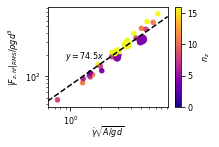

In [33]:
gamma_dot = 2 * data.q / (data.h * data.H) * np.sqrt(data.A)
F_hf_RMS = np.sqrt(2 * data.P_F0 * data.f_c)
gamma_dot_lim = np.array([0.8 * gamma_dot.min(), 1.25 * gamma_dot.max()])
ratio_bar = (F_hf_RMS / gamma_dot).mean()

fig = plt.figure(figsize=[6 / 2.52, 5 / 2.52])

# Plot P_F_z(10\sqrt(gd))/P_F^0 against decay length
ax = fig.add_axes([0.125, 0.15, 0.7, 0.7],
                  xscale='log', xlim=gamma_dot_lim,
                  yscale='log', ylim=[0.8 * F_hf_RMS.min(), 1.25 * F_hf_RMS.max()])
ax.scatter(data.loc['steady'].l_d, data.loc['steady'].P_F_z_i_ratio,
           marker='o', s=0.2*data.loc['steady'].A,
           c=data.loc['steady'].nz, cmap='plasma', vmin=0, vmax=16)

# Label axes
ax.set_xlabel(r'$\dot{\gamma} \sqrt{A / g d}$', fontsize=8)
ax.xaxis.set_label_coords(0.5, -0.175)
ax.set_ylabel(r'$|F_{z, hf}|_{RMS} / \rho g d^3$', fontsize=8)
ax.tick_params(axis='both', which='both', labelsize=8)

ax.scatter(gamma_dot, F_hf_RMS, 
           s=0.2*data.loc[mode].A, c=data.loc[mode].nz,
           cmap='plasma', vmin=0, vmax=16)
ax.plot(gamma_dot_lim, ratio_bar * gamma_dot_lim, '--k')
ax.text(1.5 * gamma_dot_lim[0], 4 * ratio_bar * gamma_dot_lim[0],
        rf'$y = {ratio_bar:.1f}x$',
       fontsize=8)

cax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
cbar = fig.colorbar(sc_I, cax=cax)
cbar.set_label(r'$n_z$', fontsize=8)
cax.tick_params(labelsize=8)